# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                  'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

## 2 Susceptibility in absolute and sentence-relative values

Build our data.

In [3]:
model = Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        # Prepare these arrays for stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        
        for feature in Substitution.__features__:
            sentence_values, _ = substitution.source_destination_features(feature)
            sentence_values_rel, _ = substitution.source_destination_features(
                feature, sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            # Stopword-check the arrays.
            words = getattr(substitution.source, source_type)[dslice]
            for i, (word, lemma, token, tag) in enumerate(zip(words, lemmas, tokens, tags)):
                if (token in stopwords) or (lemma in stopwords):
                    # Drop stopwords from this analysis since we exclude stopword-substitutions.
                    continue
                data.append({'cluster_id': substitution.source.cluster.sid,
                             'destination_id': substitution.destination.sid,
                             'occurrence': substitution.occurrence,
                             'source_id': substitution.source.sid,
                             'feature': feature,
                             'word': word,
                             'POS': tag,
                             'target': i == substitution.position,
                             'value': sentence_values[i],
                             'value_rel': sentence_values_rel[i]})

original_susties = pd.DataFrame(data)
del data

Got 67981 substitutions for model Model(time=Time.continuous, source=Source.all, past=Past.last_bin, durl=Durl.all, max_distance=2)


  0% (    1 of 67981) |            | Elapsed Time: 0:00:04 ETA:  3 days, 5:42:09

  0% (  102 of 67981) |                    | Elapsed Time: 0:00:05 ETA:  0:11:13

  0% (  174 of 67981) |                    | Elapsed Time: 0:00:06 ETA:  0:13:06

  0% (  276 of 67981) |                    | Elapsed Time: 0:00:07 ETA:  0:12:20

  0% (  372 of 67981) |                    | Elapsed Time: 0:00:08 ETA:  0:12:11

  0% (  472 of 67981) |                    | Elapsed Time: 0:00:09 ETA:  0:11:57

  0% (  569 of 67981) |                    | Elapsed Time: 0:00:10 ETA:  0:11:53

  0% (  666 of 67981) |                    | Elapsed Time: 0:00:11 ETA:  0:11:49

  1% (  768 of 67981) |                    | Elapsed Time: 0:00:12 ETA:  0:11:41

  1% (  850 of 67981) |                    | Elapsed Time: 0:00:13 ETA:  0:11:40

  1% (  948 of 67981) |                    | Elapsed Time: 0:00:14 ETA:  0:11:41

  1% ( 1047 of 67981) |                    | Elapsed Time: 0:00:15 ETA:  0:11:18

  1% ( 1148 of 67981) |                    | Elapsed Time: 0:00:16 ETA:  0:11:17

  1% ( 1246 of 67981) |                    | Elapsed Time: 0:00:17 ETA:  0:11:14

  1% ( 1339 of 67981) |                    | Elapsed Time: 0:00:18 ETA:  0:11:19

  2% ( 1445 of 67981) |                    | Elapsed Time: 0:00:19 ETA:  0:11:11

  2% ( 1546 of 67981) |                    | Elapsed Time: 0:00:20 ETA:  0:11:07

  2% ( 1652 of 67981) |                    | Elapsed Time: 0:00:21 ETA:  0:11:03

  2% ( 1700 of 67981) |                    | Elapsed Time: 0:00:21 ETA:  0:10:57

  2% ( 1806 of 67981) |                    | Elapsed Time: 0:00:22 ETA:  0:10:50

  2% ( 1912 of 67981) |                    | Elapsed Time: 0:00:23 ETA:  0:10:43

  2% ( 2011 of 67981) |                    | Elapsed Time: 0:00:24 ETA:  0:10:44

  3% ( 2114 of 67981) |                    | Elapsed Time: 0:00:25 ETA:  0:10:39

  3% ( 2217 of 67981) |                    | Elapsed Time: 0:00:26 ETA:  0:10:30

  3% ( 2320 of 67981) |                    | Elapsed Time: 0:00:27 ETA:  0:10:31

  3% ( 2385 of 67981) |                    | Elapsed Time: 0:00:28 ETA:  0:10:59

  3% ( 2487 of 67981) |                    | Elapsed Time: 0:00:29 ETA:  0:11:00

  3% ( 2550 of 67981) |                    | Elapsed Time: 0:00:30 ETA:  0:11:03

  3% ( 2652 of 67981) |                    | Elapsed Time: 0:00:31 ETA:  0:11:06

  4% ( 2755 of 67981) |                    | Elapsed Time: 0:00:32 ETA:  0:11:08

  4% ( 2849 of 67981) |                    | Elapsed Time: 0:00:33 ETA:  0:11:10

  4% ( 2927 of 67981) |                    | Elapsed Time: 0:00:34 ETA:  0:11:31

  4% ( 3028 of 67981) |                    | Elapsed Time: 0:00:35 ETA:  0:11:32

  4% ( 3127 of 67981) |                    | Elapsed Time: 0:00:36 ETA:  0:11:35

  4% ( 3219 of 67981) |                    | Elapsed Time: 0:00:37 ETA:  0:11:10

  4% ( 3309 of 67981) |                    | Elapsed Time: 0:00:38 ETA:  0:11:20

  5% ( 3400 of 67981) |#                   | Elapsed Time: 0:00:39 ETA:  0:11:18

  5% ( 3497 of 67981) |#                   | Elapsed Time: 0:00:40 ETA:  0:11:21

  5% ( 3593 of 67981) |#                   | Elapsed Time: 0:00:41 ETA:  0:11:26

  5% ( 3690 of 67981) |#                   | Elapsed Time: 0:00:42 ETA:  0:11:23

  5% ( 3787 of 67981) |#                   | Elapsed Time: 0:00:43 ETA:  0:11:05

  5% ( 3885 of 67981) |#                   | Elapsed Time: 0:00:44 ETA:  0:11:06

  5% ( 3978 of 67981) |#                   | Elapsed Time: 0:00:45 ETA:  0:11:11

  5% ( 4069 of 67981) |#                   | Elapsed Time: 0:00:46 ETA:  0:11:10

  6% ( 4165 of 67981) |#                   | Elapsed Time: 0:00:47 ETA:  0:11:04

  6% ( 4249 of 67981) |#                   | Elapsed Time: 0:00:48 ETA:  0:11:08

  6% ( 4343 of 67981) |#                   | Elapsed Time: 0:00:49 ETA:  0:11:09

  6% ( 4433 of 67981) |#                   | Elapsed Time: 0:00:50 ETA:  0:11:13

  6% ( 4526 of 67981) |#                   | Elapsed Time: 0:00:51 ETA:  0:11:15

  6% ( 4618 of 67981) |#                   | Elapsed Time: 0:00:52 ETA:  0:11:18

  6% ( 4696 of 67981) |#                   | Elapsed Time: 0:00:53 ETA:  0:11:36

  6% ( 4736 of 67981) |#                   | Elapsed Time: 0:00:54 ETA:  0:12:40

  7% ( 4819 of 67981) |#                   | Elapsed Time: 0:00:55 ETA:  0:12:48

  7% ( 4900 of 67981) |#                   | Elapsed Time: 0:00:56 ETA:  0:13:04

  7% ( 4976 of 67981) |#                   | Elapsed Time: 0:00:57 ETA:  0:13:22

  7% ( 5070 of 67981) |#                   | Elapsed Time: 0:00:58 ETA:  0:13:21

  7% ( 5099 of 67981) |#                   | Elapsed Time: 0:00:58 ETA:  0:13:28

  7% ( 5192 of 67981) |#                   | Elapsed Time: 0:00:59 ETA:  0:13:27

  7% ( 5276 of 67981) |#                   | Elapsed Time: 0:01:00 ETA:  0:13:37

  7% ( 5372 of 67981) |#                   | Elapsed Time: 0:01:01 ETA:  0:13:12

  8% ( 5467 of 67981) |#                   | Elapsed Time: 0:01:02 ETA:  0:11:54

  8% ( 5560 of 67981) |#                   | Elapsed Time: 0:01:03 ETA:  0:11:42

  8% ( 5655 of 67981) |#                   | Elapsed Time: 0:01:04 ETA:  0:11:26

  8% ( 5746 of 67981) |#                   | Elapsed Time: 0:01:05 ETA:  0:11:10

  8% ( 5837 of 67981) |#                   | Elapsed Time: 0:01:06 ETA:  0:11:12

  8% ( 5928 of 67981) |#                   | Elapsed Time: 0:01:07 ETA:  0:11:12

  8% ( 5949 of 67981) |#                   | Elapsed Time: 0:01:07 ETA:  0:11:12

  8% ( 6038 of 67981) |#                   | Elapsed Time: 0:01:08 ETA:  0:11:06

  9% ( 6124 of 67981) |#                   | Elapsed Time: 0:01:09 ETA:  0:11:15

  9% ( 6218 of 67981) |#                   | Elapsed Time: 0:01:10 ETA:  0:11:15

  9% ( 6312 of 67981) |#                   | Elapsed Time: 0:01:11 ETA:  0:11:13

  9% ( 6406 of 67981) |#                   | Elapsed Time: 0:01:12 ETA:  0:11:13

  9% ( 6502 of 67981) |#                   | Elapsed Time: 0:01:13 ETA:  0:11:07

  9% ( 6596 of 67981) |#                   | Elapsed Time: 0:01:14 ETA:  0:11:04

  9% ( 6683 of 67981) |#                   | Elapsed Time: 0:01:15 ETA:  0:11:07

  9% ( 6769 of 67981) |#                   | Elapsed Time: 0:01:16 ETA:  0:11:13

 10% ( 6799 of 67981) |##                  | Elapsed Time: 0:01:17 ETA:  0:11:12

 10% ( 6899 of 67981) |##                  | Elapsed Time: 0:01:18 ETA:  0:10:58

 10% ( 6993 of 67981) |##                  | Elapsed Time: 0:01:19 ETA:  0:10:57

 10% ( 7099 of 67981) |##                  | Elapsed Time: 0:01:20 ETA:  0:10:45

 10% ( 7201 of 67981) |##                  | Elapsed Time: 0:01:21 ETA:  0:10:37

 10% ( 7283 of 67981) |##                  | Elapsed Time: 0:01:22 ETA:  0:10:49

 10% ( 7347 of 67981) |##                  | Elapsed Time: 0:01:23 ETA:  0:11:18

 10% ( 7413 of 67981) |##                  | Elapsed Time: 0:01:24 ETA:  0:11:39

 10% ( 7466 of 67981) |##                  | Elapsed Time: 0:01:25 ETA:  0:12:15

 11% ( 7515 of 67981) |##                  | Elapsed Time: 0:01:26 ETA:  0:12:56

 11% ( 7572 of 67981) |##                  | Elapsed Time: 0:01:27 ETA:  0:13:50

 11% ( 7636 of 67981) |##                  | Elapsed Time: 0:01:28 ETA:  0:14:32

 11% ( 7648 of 67981) |##                  | Elapsed Time: 0:01:28 ETA:  0:15:41

 11% ( 7710 of 67981) |##                  | Elapsed Time: 0:01:29 ETA:  0:17:02

 11% ( 7739 of 67981) |##                  | Elapsed Time: 0:01:30 ETA:  0:19:10

 11% ( 7811 of 67981) |##                  | Elapsed Time: 0:01:31 ETA:  0:18:49

 11% ( 7884 of 67981) |##                  | Elapsed Time: 0:01:32 ETA:  0:18:30

 11% ( 7975 of 67981) |##                  | Elapsed Time: 0:01:33 ETA:  0:16:59

 11% ( 8058 of 67981) |##                  | Elapsed Time: 0:01:34 ETA:  0:15:46

 11% ( 8157 of 67981) |##                  | Elapsed Time: 0:01:35 ETA:  0:14:30

 12% ( 8250 of 67981) |##                  | Elapsed Time: 0:01:36 ETA:  0:13:43

 12% ( 8344 of 67981) |##                  | Elapsed Time: 0:01:37 ETA:  0:13:09

 12% ( 8406 of 67981) |##                  | Elapsed Time: 0:01:38 ETA:  0:13:07

 12% ( 8498 of 67981) |##                  | Elapsed Time: 0:01:39 ETA:  0:11:51

 12% ( 8597 of 67981) |##                  | Elapsed Time: 0:01:40 ETA:  0:11:20

 12% ( 8709 of 67981) |##                  | Elapsed Time: 0:01:41 ETA:  0:10:57

 12% ( 8778 of 67981) |##                  | Elapsed Time: 0:01:42 ETA:  0:11:11

 13% ( 8854 of 67981) |##                  | Elapsed Time: 0:01:43 ETA:  0:11:35

 13% ( 8921 of 67981) |##                  | Elapsed Time: 0:01:44 ETA:  0:12:06

 13% ( 9000 of 67981) |##                  | Elapsed Time: 0:01:45 ETA:  0:12:25

 13% ( 9068 of 67981) |##                  | Elapsed Time: 0:01:46 ETA:  0:12:17

 13% ( 9144 of 67981) |##                  | Elapsed Time: 0:01:47 ETA:  0:12:21

 13% ( 9233 of 67981) |##                  | Elapsed Time: 0:01:48 ETA:  0:12:11

 13% ( 9319 of 67981) |##                  | Elapsed Time: 0:01:49 ETA:  0:12:26

 13% ( 9348 of 67981) |##                  | Elapsed Time: 0:01:50 ETA:  0:13:03

 13% ( 9444 of 67981) |##                  | Elapsed Time: 0:01:51 ETA:  0:12:25

 14% ( 9539 of 67981) |##                  | Elapsed Time: 0:01:52 ETA:  0:12:00

 14% ( 9624 of 67981) |##                  | Elapsed Time: 0:01:53 ETA:  0:11:37

 14% ( 9704 of 67981) |##                  | Elapsed Time: 0:01:54 ETA:  0:11:34

 14% ( 9780 of 67981) |##                  | Elapsed Time: 0:01:55 ETA:  0:11:23

 14% ( 9870 of 67981) |##                  | Elapsed Time: 0:01:56 ETA:  0:11:06

 14% ( 9946 of 67981) |##                  | Elapsed Time: 0:01:57 ETA:  0:11:18

 14% (10013 of 67981) |##                  | Elapsed Time: 0:01:58 ETA:  0:11:39

 14% (10078 of 67981) |##                  | Elapsed Time: 0:01:59 ETA:  0:12:03

 14% (10160 of 67981) |##                  | Elapsed Time: 0:02:00 ETA:  0:12:19

 15% (10198 of 67981) |###                 | Elapsed Time: 0:02:00 ETA:  0:12:34

 15% (10290 of 67981) |###                 | Elapsed Time: 0:02:01 ETA:  0:12:23

 15% (10381 of 67981) |###                 | Elapsed Time: 0:02:02 ETA:  0:12:09

 15% (10474 of 67981) |###                 | Elapsed Time: 0:02:03 ETA:  0:11:47

 15% (10557 of 67981) |###                 | Elapsed Time: 0:02:04 ETA:  0:11:55

 15% (10641 of 67981) |###                 | Elapsed Time: 0:02:05 ETA:  0:11:44

 15% (10719 of 67981) |###                 | Elapsed Time: 0:02:06 ETA:  0:11:30

 15% (10809 of 67981) |###                 | Elapsed Time: 0:02:07 ETA:  0:11:00

 16% (10901 of 67981) |###                 | Elapsed Time: 0:02:08 ETA:  0:10:48

 16% (10991 of 67981) |###                 | Elapsed Time: 0:02:09 ETA:  0:10:46

 16% (11047 of 67981) |###                 | Elapsed Time: 0:02:10 ETA:  0:10:52

 16% (11143 of 67981) |###                 | Elapsed Time: 0:02:11 ETA:  0:10:45

 16% (11218 of 67981) |###                 | Elapsed Time: 0:02:12 ETA:  0:11:03

 16% (11304 of 67981) |###                 | Elapsed Time: 0:02:13 ETA:  0:10:58

 16% (11389 of 67981) |###                 | Elapsed Time: 0:02:14 ETA:  0:10:56

 16% (11458 of 67981) |###                 | Elapsed Time: 0:02:15 ETA:  0:11:05

 16% (11485 of 67981) |###                 | Elapsed Time: 0:02:16 ETA:  0:12:41

 17% (11568 of 67981) |###                 | Elapsed Time: 0:02:17 ETA:  0:12:51

 17% (11662 of 67981) |###                 | Elapsed Time: 0:02:18 ETA:  0:12:43

 17% (11757 of 67981) |###                 | Elapsed Time: 0:02:19 ETA:  0:12:25

 17% (11858 of 67981) |###                 | Elapsed Time: 0:02:20 ETA:  0:12:19

 17% (11897 of 67981) |###                 | Elapsed Time: 0:02:21 ETA:  0:12:05

 17% (11984 of 67981) |###                 | Elapsed Time: 0:02:22 ETA:  0:12:04

 17% (12080 of 67981) |###                 | Elapsed Time: 0:02:23 ETA:  0:11:50

 17% (12176 of 67981) |###                 | Elapsed Time: 0:02:24 ETA:  0:11:17

 18% (12263 of 67981) |###                 | Elapsed Time: 0:02:25 ETA:  0:09:53

 18% (12354 of 67981) |###                 | Elapsed Time: 0:02:26 ETA:  0:09:45

 18% (12456 of 67981) |###                 | Elapsed Time: 0:02:27 ETA:  0:09:36

 18% (12559 of 67981) |###                 | Elapsed Time: 0:02:28 ETA:  0:09:29

 18% (12666 of 67981) |###                 | Elapsed Time: 0:02:29 ETA:  0:09:22

 18% (12747 of 67981) |###                 | Elapsed Time: 0:02:29 ETA:  0:09:16

 18% (12849 of 67981) |###                 | Elapsed Time: 0:02:30 ETA:  0:09:02

 19% (12948 of 67981) |###                 | Elapsed Time: 0:02:31 ETA:  0:08:58

 19% (13056 of 67981) |###                 | Elapsed Time: 0:02:32 ETA:  0:08:47

 19% (13159 of 67981) |###                 | Elapsed Time: 0:02:33 ETA:  0:08:34

 19% (13259 of 67981) |###                 | Elapsed Time: 0:02:34 ETA:  0:08:26

 19% (13358 of 67981) |###                 | Elapsed Time: 0:02:35 ETA:  0:08:28

 19% (13460 of 67981) |###                 | Elapsed Time: 0:02:36 ETA:  0:08:28

 19% (13558 of 67981) |###                 | Elapsed Time: 0:02:37 ETA:  0:08:33

 20% (13597 of 67981) |####                | Elapsed Time: 0:02:38 ETA:  0:08:32

 20% (13699 of 67981) |####                | Elapsed Time: 0:02:39 ETA:  0:08:32

 20% (13789 of 67981) |####                | Elapsed Time: 0:02:40 ETA:  0:08:38

 20% (13858 of 67981) |####                | Elapsed Time: 0:02:41 ETA:  0:09:11

 20% (13925 of 67981) |####                | Elapsed Time: 0:02:42 ETA:  0:09:43

 20% (14025 of 67981) |####                | Elapsed Time: 0:02:43 ETA:  0:09:42

 20% (14129 of 67981) |####                | Elapsed Time: 0:02:44 ETA:  0:09:36

 20% (14237 of 67981) |####                | Elapsed Time: 0:02:45 ETA:  0:09:29

 21% (14340 of 67981) |####                | Elapsed Time: 0:02:46 ETA:  0:09:24

 21% (14446 of 67981) |####                | Elapsed Time: 0:02:47 ETA:  0:09:16

 21% (14553 of 67981) |####                | Elapsed Time: 0:02:48 ETA:  0:09:10

 21% (14653 of 67981) |####                | Elapsed Time: 0:02:49 ETA:  0:09:01

 21% (14753 of 67981) |####                | Elapsed Time: 0:02:50 ETA:  0:08:35

 21% (14856 of 67981) |####                | Elapsed Time: 0:02:51 ETA:  0:08:08

 22% (14959 of 67981) |####                | Elapsed Time: 0:02:52 ETA:  0:08:05

 22% (15063 of 67981) |####                | Elapsed Time: 0:02:53 ETA:  0:08:04

 22% (15162 of 67981) |####                | Elapsed Time: 0:02:54 ETA:  0:08:09

 22% (15271 of 67981) |####                | Elapsed Time: 0:02:55 ETA:  0:08:04

 22% (15296 of 67981) |####                | Elapsed Time: 0:02:55 ETA:  0:08:05

 22% (15404 of 67981) |####                | Elapsed Time: 0:02:56 ETA:  0:08:03

 22% (15513 of 67981) |####                | Elapsed Time: 0:02:57 ETA:  0:07:55

 22% (15618 of 67981) |####                | Elapsed Time: 0:02:58 ETA:  0:07:50

 23% (15722 of 67981) |####                | Elapsed Time: 0:02:59 ETA:  0:07:48

 23% (15825 of 67981) |####                | Elapsed Time: 0:03:00 ETA:  0:07:46

 23% (15927 of 67981) |####                | Elapsed Time: 0:03:01 ETA:  0:07:47

 23% (16033 of 67981) |####                | Elapsed Time: 0:03:02 ETA:  0:07:40

 23% (16146 of 67981) |####                | Elapsed Time: 0:03:03 ETA:  0:07:46

 23% (16244 of 67981) |####                | Elapsed Time: 0:03:04 ETA:  0:07:53

 23% (16270 of 67981) |####                | Elapsed Time: 0:03:05 ETA:  0:09:04

 24% (16358 of 67981) |####                | Elapsed Time: 0:03:06 ETA:  0:09:20

 24% (16456 of 67981) |####                | Elapsed Time: 0:03:07 ETA:  0:09:26

 24% (16560 of 67981) |####                | Elapsed Time: 0:03:08 ETA:  0:09:24

 24% (16664 of 67981) |####                | Elapsed Time: 0:03:09 ETA:  0:09:21

 24% (16731 of 67981) |####                | Elapsed Time: 0:03:10 ETA:  0:10:03

 24% (16807 of 67981) |####                | Elapsed Time: 0:03:11 ETA:  0:10:35

 24% (16878 of 67981) |####                | Elapsed Time: 0:03:12 ETA:  0:10:47

 24% (16952 of 67981) |####                | Elapsed Time: 0:03:13 ETA:  0:11:15

 25% (16996 of 67981) |#####               | Elapsed Time: 0:03:14 ETA:  0:10:17

 25% (17071 of 67981) |#####               | Elapsed Time: 0:03:15 ETA:  0:10:32

 25% (17143 of 67981) |#####               | Elapsed Time: 0:03:16 ETA:  0:11:03

 25% (17222 of 67981) |#####               | Elapsed Time: 0:03:17 ETA:  0:11:35

 25% (17302 of 67981) |#####               | Elapsed Time: 0:03:18 ETA:  0:12:08

 25% (17380 of 67981) |#####               | Elapsed Time: 0:03:19 ETA:  0:11:50

 25% (17458 of 67981) |#####               | Elapsed Time: 0:03:20 ETA:  0:11:46

 25% (17527 of 67981) |#####               | Elapsed Time: 0:03:21 ETA:  0:11:49

 25% (17623 of 67981) |#####               | Elapsed Time: 0:03:22 ETA:  0:11:18

 26% (17716 of 67981) |#####               | Elapsed Time: 0:03:23 ETA:  0:10:52

 26% (17804 of 67981) |#####               | Elapsed Time: 0:03:24 ETA:  0:10:35

 26% (17846 of 67981) |#####               | Elapsed Time: 0:03:25 ETA:  0:10:17

 26% (17938 of 67981) |#####               | Elapsed Time: 0:03:26 ETA:  0:10:01

 26% (18027 of 67981) |#####               | Elapsed Time: 0:03:27 ETA:  0:09:50

 26% (18120 of 67981) |#####               | Elapsed Time: 0:03:28 ETA:  0:09:32

 26% (18216 of 67981) |#####               | Elapsed Time: 0:03:29 ETA:  0:09:13

 26% (18319 of 67981) |#####               | Elapsed Time: 0:03:30 ETA:  0:08:38

 27% (18419 of 67981) |#####               | Elapsed Time: 0:03:31 ETA:  0:08:34

 27% (18516 of 67981) |#####               | Elapsed Time: 0:03:32 ETA:  0:08:30

 27% (18611 of 67981) |#####               | Elapsed Time: 0:03:33 ETA:  0:08:23

 27% (18695 of 67981) |#####               | Elapsed Time: 0:03:33 ETA:  0:08:18

 27% (18789 of 67981) |#####               | Elapsed Time: 0:03:34 ETA:  0:08:15

 27% (18886 of 67981) |#####               | Elapsed Time: 0:03:35 ETA:  0:08:07

 27% (18978 of 67981) |#####               | Elapsed Time: 0:03:36 ETA:  0:08:07

 28% (19074 of 67981) |#####               | Elapsed Time: 0:03:37 ETA:  0:08:07

 28% (19159 of 67981) |#####               | Elapsed Time: 0:03:38 ETA:  0:08:21

 28% (19246 of 67981) |#####               | Elapsed Time: 0:03:39 ETA:  0:08:31

 28% (19340 of 67981) |#####               | Elapsed Time: 0:03:40 ETA:  0:08:32

 28% (19451 of 67981) |#####               | Elapsed Time: 0:03:41 ETA:  0:08:17

 28% (19545 of 67981) |#####               | Elapsed Time: 0:03:42 ETA:  0:08:22

 28% (19635 of 67981) |#####               | Elapsed Time: 0:03:43 ETA:  0:08:28

 29% (19722 of 67981) |#####               | Elapsed Time: 0:03:44 ETA:  0:08:32

 29% (19814 of 67981) |#####               | Elapsed Time: 0:03:45 ETA:  0:08:35

 29% (19905 of 67981) |#####               | Elapsed Time: 0:03:47 ETA:  0:08:28

 29% (20001 of 67981) |#####               | Elapsed Time: 0:03:48 ETA:  0:08:18

 29% (20100 of 67981) |#####               | Elapsed Time: 0:03:49 ETA:  0:08:12

 29% (20190 of 67981) |#####               | Elapsed Time: 0:03:50 ETA:  0:08:32

 29% (20281 of 67981) |#####               | Elapsed Time: 0:03:51 ETA:  0:08:35

 29% (20363 of 67981) |#####               | Elapsed Time: 0:03:52 ETA:  0:08:43

 30% (20395 of 67981) |######              | Elapsed Time: 0:03:52 ETA:  0:08:41

 30% (20473 of 67981) |######              | Elapsed Time: 0:03:53 ETA:  0:08:49

 30% (20546 of 67981) |######              | Elapsed Time: 0:03:54 ETA:  0:09:07

 30% (20634 of 67981) |######              | Elapsed Time: 0:03:55 ETA:  0:09:09

 30% (20721 of 67981) |######              | Elapsed Time: 0:03:56 ETA:  0:09:18

 30% (20807 of 67981) |######              | Elapsed Time: 0:03:57 ETA:  0:09:32

 30% (20885 of 67981) |######              | Elapsed Time: 0:03:58 ETA:  0:09:44

 30% (20968 of 67981) |######              | Elapsed Time: 0:03:59 ETA:  0:09:50

 30% (21052 of 67981) |######              | Elapsed Time: 0:04:00 ETA:  0:09:47

 31% (21149 of 67981) |######              | Elapsed Time: 0:04:01 ETA:  0:09:35

 31% (21245 of 67981) |######              | Elapsed Time: 0:04:02 ETA:  0:09:07

 31% (21324 of 67981) |######              | Elapsed Time: 0:04:03 ETA:  0:09:16

 31% (21420 of 67981) |######              | Elapsed Time: 0:04:04 ETA:  0:09:04

 31% (21514 of 67981) |######              | Elapsed Time: 0:04:05 ETA:  0:08:54

 31% (21541 of 67981) |######              | Elapsed Time: 0:04:06 ETA:  0:10:20

 31% (21626 of 67981) |######              | Elapsed Time: 0:04:07 ETA:  0:10:15

 31% (21706 of 67981) |######              | Elapsed Time: 0:04:08 ETA:  0:10:19

 32% (21790 of 67981) |######              | Elapsed Time: 0:04:09 ETA:  0:10:36

 32% (21876 of 67981) |######              | Elapsed Time: 0:04:10 ETA:  0:10:41

 32% (21954 of 67981) |######              | Elapsed Time: 0:04:11 ETA:  0:10:38

 32% (22036 of 67981) |######              | Elapsed Time: 0:04:12 ETA:  0:10:36

 32% (22094 of 67981) |######              | Elapsed Time: 0:04:13 ETA:  0:10:54

 32% (22201 of 67981) |######              | Elapsed Time: 0:04:14 ETA:  0:10:37

 32% (22281 of 67981) |######              | Elapsed Time: 0:04:15 ETA:  0:09:08

 32% (22374 of 67981) |######              | Elapsed Time: 0:04:16 ETA:  0:08:59

 33% (22472 of 67981) |######              | Elapsed Time: 0:04:17 ETA:  0:08:40

 33% (22569 of 67981) |######              | Elapsed Time: 0:04:18 ETA:  0:08:26

 33% (22653 of 67981) |######              | Elapsed Time: 0:04:19 ETA:  0:08:27

 33% (22734 of 67981) |######              | Elapsed Time: 0:04:20 ETA:  0:08:23

 33% (22823 of 67981) |######              | Elapsed Time: 0:04:21 ETA:  0:08:13

 33% (22906 of 67981) |######              | Elapsed Time: 0:04:22 ETA:  0:08:15

 33% (22944 of 67981) |######              | Elapsed Time: 0:04:23 ETA:  0:08:35

 33% (23024 of 67981) |######              | Elapsed Time: 0:04:24 ETA:  0:08:34

 33% (23113 of 67981) |######              | Elapsed Time: 0:04:25 ETA:  0:08:37

 34% (23201 of 67981) |######              | Elapsed Time: 0:04:26 ETA:  0:08:47

 34% (23303 of 67981) |######              | Elapsed Time: 0:04:27 ETA:  0:08:40

 34% (23397 of 67981) |######              | Elapsed Time: 0:04:28 ETA:  0:08:28

 34% (23478 of 67981) |######              | Elapsed Time: 0:04:29 ETA:  0:08:27

 34% (23557 of 67981) |######              | Elapsed Time: 0:04:30 ETA:  0:08:36

 34% (23639 of 67981) |######              | Elapsed Time: 0:04:31 ETA:  0:08:36

 34% (23729 of 67981) |######              | Elapsed Time: 0:04:32 ETA:  0:08:30

 35% (23794 of 67981) |#######             | Elapsed Time: 0:04:32 ETA:  0:08:11

 35% (23896 of 67981) |#######             | Elapsed Time: 0:04:33 ETA:  0:07:57

 35% (23984 of 67981) |#######             | Elapsed Time: 0:04:34 ETA:  0:07:56

 35% (24079 of 67981) |#######             | Elapsed Time: 0:04:35 ETA:  0:08:02

 35% (24172 of 67981) |#######             | Elapsed Time: 0:04:36 ETA:  0:08:02

 35% (24275 of 67981) |#######             | Elapsed Time: 0:04:37 ETA:  0:07:40

 35% (24386 of 67981) |#######             | Elapsed Time: 0:04:38 ETA:  0:07:10

 36% (24482 of 67981) |#######             | Elapsed Time: 0:04:39 ETA:  0:06:59

 36% (24568 of 67981) |#######             | Elapsed Time: 0:04:40 ETA:  0:07:01

 36% (24644 of 67981) |#######             | Elapsed Time: 0:04:41 ETA:  0:07:11

 36% (24729 of 67981) |#######             | Elapsed Time: 0:04:42 ETA:  0:07:25

 36% (24826 of 67981) |#######             | Elapsed Time: 0:04:43 ETA:  0:07:17

 36% (24918 of 67981) |#######             | Elapsed Time: 0:04:44 ETA:  0:07:19

 36% (25001 of 67981) |#######             | Elapsed Time: 0:04:45 ETA:  0:07:27

 36% (25088 of 67981) |#######             | Elapsed Time: 0:04:46 ETA:  0:07:40

 37% (25172 of 67981) |#######             | Elapsed Time: 0:04:47 ETA:  0:08:06

 37% (25256 of 67981) |#######             | Elapsed Time: 0:04:48 ETA:  0:08:16

 37% (25361 of 67981) |#######             | Elapsed Time: 0:04:49 ETA:  0:07:56

 37% (25459 of 67981) |#######             | Elapsed Time: 0:04:50 ETA:  0:07:45

 37% (25493 of 67981) |#######             | Elapsed Time: 0:04:51 ETA:  0:07:37

 37% (25593 of 67981) |#######             | Elapsed Time: 0:04:52 ETA:  0:07:32

 37% (25687 of 67981) |#######             | Elapsed Time: 0:04:53 ETA:  0:07:29

 37% (25761 of 67981) |#######             | Elapsed Time: 0:04:54 ETA:  0:07:37

 37% (25827 of 67981) |#######             | Elapsed Time: 0:04:55 ETA:  0:07:57

 38% (25911 of 67981) |#######             | Elapsed Time: 0:04:56 ETA:  0:07:55

 38% (25992 of 67981) |#######             | Elapsed Time: 0:04:57 ETA:  0:07:58

 38% (26071 of 67981) |#######             | Elapsed Time: 0:04:58 ETA:  0:08:25

 38% (26152 of 67981) |#######             | Elapsed Time: 0:04:59 ETA:  0:08:44

 38% (26252 of 67981) |#######             | Elapsed Time: 0:05:00 ETA:  0:08:30

 38% (26343 of 67981) |#######             | Elapsed Time: 0:05:01 ETA:  0:08:34

 38% (26430 of 67981) |#######             | Elapsed Time: 0:05:02 ETA:  0:08:41

 38% (26512 of 67981) |#######             | Elapsed Time: 0:05:03 ETA:  0:08:31

 39% (26621 of 67981) |#######             | Elapsed Time: 0:05:04 ETA:  0:07:46

 39% (26721 of 67981) |#######             | Elapsed Time: 0:05:05 ETA:  0:07:29

 39% (26819 of 67981) |#######             | Elapsed Time: 0:05:06 ETA:  0:07:12

 39% (26892 of 67981) |#######             | Elapsed Time: 0:05:07 ETA:  0:07:16

 39% (26972 of 67981) |#######             | Elapsed Time: 0:05:08 ETA:  0:07:16

 39% (27054 of 67981) |#######             | Elapsed Time: 0:05:09 ETA:  0:07:32

 39% (27142 of 67981) |#######             | Elapsed Time: 0:05:10 ETA:  0:07:39

 40% (27193 of 67981) |########            | Elapsed Time: 0:05:10 ETA:  0:07:32

 40% (27302 of 67981) |########            | Elapsed Time: 0:05:11 ETA:  0:07:04

 40% (27409 of 67981) |########            | Elapsed Time: 0:05:12 ETA:  0:07:05

 40% (27508 of 67981) |########            | Elapsed Time: 0:05:13 ETA:  0:07:05

 40% (27619 of 67981) |########            | Elapsed Time: 0:05:14 ETA:  0:06:52

 40% (27729 of 67981) |########            | Elapsed Time: 0:05:15 ETA:  0:06:19

 40% (27832 of 67981) |########            | Elapsed Time: 0:05:16 ETA:  0:06:00

 41% (27931 of 67981) |########            | Elapsed Time: 0:05:17 ETA:  0:05:46

 41% (28023 of 67981) |########            | Elapsed Time: 0:05:19 ETA:  0:06:58

 41% (28043 of 67981) |########            | Elapsed Time: 0:05:19 ETA:  0:06:59

 41% (28136 of 67981) |########            | Elapsed Time: 0:05:20 ETA:  0:07:13

 41% (28230 of 67981) |########            | Elapsed Time: 0:05:21 ETA:  0:07:25

 41% (28306 of 67981) |########            | Elapsed Time: 0:05:22 ETA:  0:07:47

 41% (28376 of 67981) |########            | Elapsed Time: 0:05:23 ETA:  0:08:28

 41% (28461 of 67981) |########            | Elapsed Time: 0:05:24 ETA:  0:08:55

 41% (28538 of 67981) |########            | Elapsed Time: 0:05:25 ETA:  0:09:27

 42% (28602 of 67981) |########            | Elapsed Time: 0:05:26 ETA:  0:10:12

 42% (28672 of 67981) |########            | Elapsed Time: 0:05:27 ETA:  0:08:58

 42% (28745 of 67981) |########            | Elapsed Time: 0:05:28 ETA:  0:09:08

 42% (28813 of 67981) |########            | Elapsed Time: 0:05:29 ETA:  0:09:40

 42% (28876 of 67981) |########            | Elapsed Time: 0:05:30 ETA:  0:10:22

 42% (28892 of 67981) |########            | Elapsed Time: 0:05:31 ETA:  0:10:34

 42% (28950 of 67981) |########            | Elapsed Time: 0:05:32 ETA:  0:10:53

 42% (29008 of 67981) |########            | Elapsed Time: 0:05:33 ETA:  0:11:40

 42% (29110 of 67981) |########            | Elapsed Time: 0:05:34 ETA:  0:10:53

 42% (29195 of 67981) |########            | Elapsed Time: 0:05:35 ETA:  0:10:17

 43% (29295 of 67981) |########            | Elapsed Time: 0:05:36 ETA:  0:09:29

 43% (29396 of 67981) |########            | Elapsed Time: 0:05:37 ETA:  0:08:49

 43% (29504 of 67981) |########            | Elapsed Time: 0:05:38 ETA:  0:07:58

 43% (29607 of 67981) |########            | Elapsed Time: 0:05:39 ETA:  0:07:12

 43% (29704 of 67981) |########            | Elapsed Time: 0:05:40 ETA:  0:06:55

 43% (29742 of 67981) |########            | Elapsed Time: 0:05:40 ETA:  0:06:22

 43% (29847 of 67981) |########            | Elapsed Time: 0:05:41 ETA:  0:05:40

 44% (29944 of 67981) |########            | Elapsed Time: 0:05:42 ETA:  0:05:44

 44% (30044 of 67981) |########            | Elapsed Time: 0:05:43 ETA:  0:05:31

 44% (30141 of 67981) |########            | Elapsed Time: 0:05:44 ETA:  0:05:33

 44% (30241 of 67981) |########            | Elapsed Time: 0:05:45 ETA:  0:05:33

 44% (30346 of 67981) |########            | Elapsed Time: 0:05:46 ETA:  0:05:35

 44% (30452 of 67981) |########            | Elapsed Time: 0:05:47 ETA:  0:05:32

 44% (30539 of 67981) |########            | Elapsed Time: 0:05:48 ETA:  0:05:39

 45% (30592 of 67981) |#########           | Elapsed Time: 0:05:49 ETA:  0:05:48

 45% (30679 of 67981) |#########           | Elapsed Time: 0:05:50 ETA:  0:06:02

 45% (30779 of 67981) |#########           | Elapsed Time: 0:05:51 ETA:  0:05:58

 45% (30874 of 67981) |#########           | Elapsed Time: 0:05:52 ETA:  0:06:01

 45% (30959 of 67981) |#########           | Elapsed Time: 0:05:53 ETA:  0:06:11

 45% (31048 of 67981) |#########           | Elapsed Time: 0:05:54 ETA:  0:06:20

 45% (31148 of 67981) |#########           | Elapsed Time: 0:05:55 ETA:  0:06:24

 45% (31246 of 67981) |#########           | Elapsed Time: 0:05:56 ETA:  0:06:33

 46% (31345 of 67981) |#########           | Elapsed Time: 0:05:57 ETA:  0:06:22

 46% (31442 of 67981) |#########           | Elapsed Time: 0:05:58 ETA:  0:06:12

 46% (31527 of 67981) |#########           | Elapsed Time: 0:05:59 ETA:  0:06:25

 46% (31616 of 67981) |#########           | Elapsed Time: 0:06:00 ETA:  0:06:30

 46% (31703 of 67981) |#########           | Elapsed Time: 0:06:01 ETA:  0:06:27

 46% (31790 of 67981) |#########           | Elapsed Time: 0:06:02 ETA:  0:06:28

 46% (31898 of 67981) |#########           | Elapsed Time: 0:06:03 ETA:  0:06:17

 47% (32019 of 67981) |#########           | Elapsed Time: 0:06:04 ETA:  0:05:51

 47% (32123 of 67981) |#########           | Elapsed Time: 0:06:05 ETA:  0:05:45

 47% (32186 of 67981) |#########           | Elapsed Time: 0:06:06 ETA:  0:06:09

 47% (32291 of 67981) |#########           | Elapsed Time: 0:06:07 ETA:  0:05:53

 47% (32365 of 67981) |#########           | Elapsed Time: 0:06:08 ETA:  0:06:07

 47% (32462 of 67981) |#########           | Elapsed Time: 0:06:09 ETA:  0:05:57

 47% (32552 of 67981) |#########           | Elapsed Time: 0:06:10 ETA:  0:05:53

 48% (32641 of 67981) |#########           | Elapsed Time: 0:06:11 ETA:  0:06:10

 48% (32729 of 67981) |#########           | Elapsed Time: 0:06:12 ETA:  0:06:44

 48% (32830 of 67981) |#########           | Elapsed Time: 0:06:13 ETA:  0:06:46

 48% (32937 of 67981) |#########           | Elapsed Time: 0:06:14 ETA:  0:05:59

 48% (33044 of 67981) |#########           | Elapsed Time: 0:06:15 ETA:  0:05:50

 48% (33141 of 67981) |#########           | Elapsed Time: 0:06:16 ETA:  0:05:40

 48% (33232 of 67981) |#########           | Elapsed Time: 0:06:17 ETA:  0:05:45

 49% (33346 of 67981) |#########           | Elapsed Time: 0:06:18 ETA:  0:05:23

 49% (33462 of 67981) |#########           | Elapsed Time: 0:06:19 ETA:  0:04:58

 49% (33569 of 67981) |#########           | Elapsed Time: 0:06:20 ETA:  0:04:43

 49% (33656 of 67981) |#########           | Elapsed Time: 0:06:21 ETA:  0:04:53

 49% (33776 of 67981) |#########           | Elapsed Time: 0:06:22 ETA:  0:04:42

 49% (33887 of 67981) |#########           | Elapsed Time: 0:06:23 ETA:  0:04:38

 49% (33975 of 67981) |#########           | Elapsed Time: 0:06:24 ETA:  0:04:34

 50% (33991 of 67981) |##########          | Elapsed Time: 0:06:25 ETA:  0:04:36

 50% (34086 of 67981) |##########          | Elapsed Time: 0:06:26 ETA:  0:04:32

 50% (34186 of 67981) |##########          | Elapsed Time: 0:06:27 ETA:  0:04:41

 50% (34287 of 67981) |##########          | Elapsed Time: 0:06:28 ETA:  0:04:52

 50% (34390 of 67981) |##########          | Elapsed Time: 0:06:29 ETA:  0:04:54

 50% (34494 of 67981) |##########          | Elapsed Time: 0:06:30 ETA:  0:04:38

 50% (34606 of 67981) |##########          | Elapsed Time: 0:06:31 ETA:  0:04:44

 51% (34706 of 67981) |##########          | Elapsed Time: 0:06:32 ETA:  0:04:52

 51% (34798 of 67981) |##########          | Elapsed Time: 0:06:33 ETA:  0:04:48

 51% (34841 of 67981) |##########          | Elapsed Time: 0:06:33 ETA:  0:04:47

 51% (34930 of 67981) |##########          | Elapsed Time: 0:06:34 ETA:  0:04:51

 51% (34998 of 67981) |##########          | Elapsed Time: 0:06:35 ETA:  0:05:17

 51% (35087 of 67981) |##########          | Elapsed Time: 0:06:36 ETA:  0:05:26

 51% (35161 of 67981) |##########          | Elapsed Time: 0:06:37 ETA:  0:05:52

 51% (35245 of 67981) |##########          | Elapsed Time: 0:06:38 ETA:  0:06:12

 51% (35336 of 67981) |##########          | Elapsed Time: 0:06:39 ETA:  0:06:33

 52% (35424 of 67981) |##########          | Elapsed Time: 0:06:40 ETA:  0:06:45

 52% (35519 of 67981) |##########          | Elapsed Time: 0:06:41 ETA:  0:06:40

 52% (35628 of 67981) |##########          | Elapsed Time: 0:06:42 ETA:  0:06:17

 52% (35691 of 67981) |##########          | Elapsed Time: 0:06:43 ETA:  0:06:11

 52% (35794 of 67981) |##########          | Elapsed Time: 0:06:44 ETA:  0:05:36

 52% (35846 of 67981) |##########          | Elapsed Time: 0:06:46 ETA:  0:07:31

 52% (35912 of 67981) |##########          | Elapsed Time: 0:06:47 ETA:  0:07:40

 52% (35984 of 67981) |##########          | Elapsed Time: 0:06:48 ETA:  0:07:55

 53% (36064 of 67981) |##########          | Elapsed Time: 0:06:49 ETA:  0:08:08

 53% (36151 of 67981) |##########          | Elapsed Time: 0:06:50 ETA:  0:08:08

 53% (36246 of 67981) |##########          | Elapsed Time: 0:06:51 ETA:  0:08:07

 53% (36326 of 67981) |##########          | Elapsed Time: 0:06:52 ETA:  0:08:44

 53% (36409 of 67981) |##########          | Elapsed Time: 0:06:53 ETA:  0:08:50

 53% (36515 of 67981) |##########          | Elapsed Time: 0:06:54 ETA:  0:08:45

 53% (36540 of 67981) |##########          | Elapsed Time: 0:06:54 ETA:  0:06:39

 53% (36630 of 67981) |##########          | Elapsed Time: 0:06:55 ETA:  0:06:10

 54% (36720 of 67981) |##########          | Elapsed Time: 0:06:56 ETA:  0:05:49

 54% (36806 of 67981) |##########          | Elapsed Time: 0:06:57 ETA:  0:05:41

 54% (36910 of 67981) |##########          | Elapsed Time: 0:06:58 ETA:  0:05:23

 54% (37009 of 67981) |##########          | Elapsed Time: 0:06:59 ETA:  0:05:18

 54% (37117 of 67981) |##########          | Elapsed Time: 0:07:00 ETA:  0:04:51

 54% (37227 of 67981) |##########          | Elapsed Time: 0:07:01 ETA:  0:04:26

 54% (37326 of 67981) |##########          | Elapsed Time: 0:07:02 ETA:  0:04:31

 55% (37390 of 67981) |###########         | Elapsed Time: 0:07:03 ETA:  0:04:35

 55% (37477 of 67981) |###########         | Elapsed Time: 0:07:04 ETA:  0:04:37

 55% (37596 of 67981) |###########         | Elapsed Time: 0:07:05 ETA:  0:04:12

 55% (37708 of 67981) |###########         | Elapsed Time: 0:07:06 ETA:  0:03:52

 55% (37783 of 67981) |###########         | Elapsed Time: 0:07:07 ETA:  0:04:13

 55% (37846 of 67981) |###########         | Elapsed Time: 0:07:08 ETA:  0:04:42

 55% (37912 of 67981) |###########         | Elapsed Time: 0:07:09 ETA:  0:05:19

 55% (38000 of 67981) |###########         | Elapsed Time: 0:07:10 ETA:  0:05:39

 56% (38093 of 67981) |###########         | Elapsed Time: 0:07:11 ETA:  0:05:43

 56% (38182 of 67981) |###########         | Elapsed Time: 0:07:12 ETA:  0:05:44

 56% (38240 of 67981) |###########         | Elapsed Time: 0:07:13 ETA:  0:06:07

 56% (38296 of 67981) |###########         | Elapsed Time: 0:07:14 ETA:  0:07:19

 56% (38369 of 67981) |###########         | Elapsed Time: 0:07:15 ETA:  0:08:09

 56% (38481 of 67981) |###########         | Elapsed Time: 0:07:16 ETA:  0:07:19

 56% (38593 of 67981) |###########         | Elapsed Time: 0:07:17 ETA:  0:06:20

 56% (38679 of 67981) |###########         | Elapsed Time: 0:07:18 ETA:  0:05:58

 56% (38742 of 67981) |###########         | Elapsed Time: 0:07:19 ETA:  0:06:24

 57% (38815 of 67981) |###########         | Elapsed Time: 0:07:20 ETA:  0:06:47

 57% (38908 of 67981) |###########         | Elapsed Time: 0:07:21 ETA:  0:06:41

 57% (39003 of 67981) |###########         | Elapsed Time: 0:07:22 ETA:  0:06:04

 57% (39090 of 67981) |###########         | Elapsed Time: 0:07:23 ETA:  0:05:22

 57% (39186 of 67981) |###########         | Elapsed Time: 0:07:24 ETA:  0:05:00

 57% (39276 of 67981) |###########         | Elapsed Time: 0:07:25 ETA:  0:05:19

 57% (39372 of 67981) |###########         | Elapsed Time: 0:07:26 ETA:  0:05:34

 58% (39481 of 67981) |###########         | Elapsed Time: 0:07:27 ETA:  0:05:10

 58% (39605 of 67981) |###########         | Elapsed Time: 0:07:28 ETA:  0:04:15

 58% (39714 of 67981) |###########         | Elapsed Time: 0:07:29 ETA:  0:03:46

 58% (39806 of 67981) |###########         | Elapsed Time: 0:07:30 ETA:  0:03:46

 58% (39900 of 67981) |###########         | Elapsed Time: 0:07:31 ETA:  0:03:45

 58% (39939 of 67981) |###########         | Elapsed Time: 0:07:31 ETA:  0:03:43

 58% (40044 of 67981) |###########         | Elapsed Time: 0:07:32 ETA:  0:03:35

 59% (40144 of 67981) |###########         | Elapsed Time: 0:07:33 ETA:  0:03:27

 59% (40249 of 67981) |###########         | Elapsed Time: 0:07:34 ETA:  0:03:19

 59% (40355 of 67981) |###########         | Elapsed Time: 0:07:35 ETA:  0:03:20

 59% (40442 of 67981) |###########         | Elapsed Time: 0:07:36 ETA:  0:03:48

 59% (40531 of 67981) |###########         | Elapsed Time: 0:07:37 ETA:  0:04:03

 59% (40625 of 67981) |###########         | Elapsed Time: 0:07:38 ETA:  0:04:01

 59% (40717 of 67981) |###########         | Elapsed Time: 0:07:39 ETA:  0:04:02

 60% (40789 of 67981) |############        | Elapsed Time: 0:07:40 ETA:  0:03:56

 60% (40891 of 67981) |############        | Elapsed Time: 0:07:41 ETA:  0:03:58

 60% (40957 of 67981) |############        | Elapsed Time: 0:07:42 ETA:  0:04:26

 60% (41031 of 67981) |############        | Elapsed Time: 0:07:43 ETA:  0:04:54

 60% (41099 of 67981) |############        | Elapsed Time: 0:07:44 ETA:  0:05:32

 60% (41187 of 67981) |############        | Elapsed Time: 0:07:45 ETA:  0:05:30

 60% (41270 of 67981) |############        | Elapsed Time: 0:07:46 ETA:  0:05:36

 60% (41338 of 67981) |############        | Elapsed Time: 0:07:47 ETA:  0:06:06

 60% (41412 of 67981) |############        | Elapsed Time: 0:07:48 ETA:  0:06:26

 61% (41506 of 67981) |############        | Elapsed Time: 0:07:49 ETA:  0:06:30

 61% (41603 of 67981) |############        | Elapsed Time: 0:07:50 ETA:  0:06:40

 61% (41639 of 67981) |############        | Elapsed Time: 0:07:50 ETA:  0:06:13

 61% (41730 of 67981) |############        | Elapsed Time: 0:07:51 ETA:  0:05:51

 61% (41793 of 67981) |############        | Elapsed Time: 0:07:52 ETA:  0:05:55

 61% (41865 of 67981) |############        | Elapsed Time: 0:07:53 ETA:  0:06:15

 61% (41954 of 67981) |############        | Elapsed Time: 0:07:54 ETA:  0:06:06

 61% (42027 of 67981) |############        | Elapsed Time: 0:07:56 ETA:  0:06:03

 61% (42100 of 67981) |############        | Elapsed Time: 0:07:57 ETA:  0:06:03

 62% (42188 of 67981) |############        | Elapsed Time: 0:07:58 ETA:  0:06:09

 62% (42287 of 67981) |############        | Elapsed Time: 0:07:59 ETA:  0:06:00

 62% (42376 of 67981) |############        | Elapsed Time: 0:08:00 ETA:  0:05:59

 62% (42489 of 67981) |############        | Elapsed Time: 0:08:01 ETA:  0:05:30

 62% (42580 of 67981) |############        | Elapsed Time: 0:08:02 ETA:  0:05:07

 62% (42677 of 67981) |############        | Elapsed Time: 0:08:03 ETA:  0:04:57

 62% (42758 of 67981) |############        | Elapsed Time: 0:08:04 ETA:  0:04:42

 63% (42845 of 67981) |############        | Elapsed Time: 0:08:05 ETA:  0:04:43

 63% (42902 of 67981) |############        | Elapsed Time: 0:08:06 ETA:  0:05:14

 63% (42981 of 67981) |############        | Elapsed Time: 0:08:07 ETA:  0:05:36

 63% (43071 of 67981) |############        | Elapsed Time: 0:08:08 ETA:  0:05:34

 63% (43173 of 67981) |############        | Elapsed Time: 0:08:09 ETA:  0:05:25

 63% (43261 of 67981) |############        | Elapsed Time: 0:08:10 ETA:  0:05:21

 63% (43338 of 67981) |############        | Elapsed Time: 0:08:11 ETA:  0:05:30

 63% (43431 of 67981) |############        | Elapsed Time: 0:08:12 ETA:  0:05:34

 64% (43520 of 67981) |############        | Elapsed Time: 0:08:13 ETA:  0:05:25

 64% (43583 of 67981) |############        | Elapsed Time: 0:08:14 ETA:  0:05:35

 64% (43649 of 67981) |############        | Elapsed Time: 0:08:15 ETA:  0:05:25

 64% (43737 of 67981) |############        | Elapsed Time: 0:08:16 ETA:  0:05:14

 64% (43833 of 67981) |############        | Elapsed Time: 0:08:17 ETA:  0:05:07

 64% (43903 of 67981) |############        | Elapsed Time: 0:08:18 ETA:  0:05:41

 64% (44002 of 67981) |############        | Elapsed Time: 0:08:19 ETA:  0:05:28

 64% (44073 of 67981) |############        | Elapsed Time: 0:08:20 ETA:  0:05:38

 64% (44147 of 67981) |############        | Elapsed Time: 0:08:21 ETA:  0:05:58

 65% (44188 of 67981) |#############       | Elapsed Time: 0:08:22 ETA:  0:06:14

 65% (44247 of 67981) |#############       | Elapsed Time: 0:08:23 ETA:  0:06:23

 65% (44363 of 67981) |#############       | Elapsed Time: 0:08:24 ETA:  0:05:25

 65% (44459 of 67981) |#############       | Elapsed Time: 0:08:25 ETA:  0:05:14

 65% (44531 of 67981) |#############       | Elapsed Time: 0:08:26 ETA:  0:05:41

 65% (44617 of 67981) |#############       | Elapsed Time: 0:08:27 ETA:  0:05:21

 65% (44708 of 67981) |#############       | Elapsed Time: 0:08:28 ETA:  0:05:29

 65% (44759 of 67981) |#############       | Elapsed Time: 0:08:29 ETA:  0:05:53

 65% (44861 of 67981) |#############       | Elapsed Time: 0:08:30 ETA:  0:05:18

 66% (44960 of 67981) |#############       | Elapsed Time: 0:08:31 ETA:  0:04:53

 66% (45038 of 67981) |#############       | Elapsed Time: 0:08:32 ETA:  0:04:22

 66% (45115 of 67981) |#############       | Elapsed Time: 0:08:33 ETA:  0:04:57

 66% (45198 of 67981) |#############       | Elapsed Time: 0:08:34 ETA:  0:05:10

 66% (45255 of 67981) |#############       | Elapsed Time: 0:08:35 ETA:  0:05:25

 66% (45341 of 67981) |#############       | Elapsed Time: 0:08:36 ETA:  0:05:26

 66% (45410 of 67981) |#############       | Elapsed Time: 0:08:37 ETA:  0:05:53

 66% (45466 of 67981) |#############       | Elapsed Time: 0:08:38 ETA:  0:05:46

 66% (45509 of 67981) |#############       | Elapsed Time: 0:08:40 ETA:  0:10:06

 67% (45599 of 67981) |#############       | Elapsed Time: 0:08:42 ETA:  0:10:31

 67% (45668 of 67981) |#############       | Elapsed Time: 0:08:43 ETA:  0:10:56

 67% (45700 of 67981) |#############       | Elapsed Time: 0:08:44 ETA:  0:12:25

 67% (45754 of 67981) |#############       | Elapsed Time: 0:08:45 ETA:  0:13:31

 67% (45849 of 67981) |#############       | Elapsed Time: 0:08:46 ETA:  0:12:05

 67% (45888 of 67981) |#############       | Elapsed Time: 0:08:46 ETA:  0:12:28

 67% (45992 of 67981) |#############       | Elapsed Time: 0:08:47 ETA:  0:11:09

 67% (46066 of 67981) |#############       | Elapsed Time: 0:08:48 ETA:  0:10:35

 67% (46135 of 67981) |#############       | Elapsed Time: 0:08:49 ETA:  0:06:40

 67% (46214 of 67981) |#############       | Elapsed Time: 0:08:50 ETA:  0:06:45

 68% (46292 of 67981) |#############       | Elapsed Time: 0:08:51 ETA:  0:06:30

 68% (46367 of 67981) |#############       | Elapsed Time: 0:08:52 ETA:  0:05:30

 68% (46436 of 67981) |#############       | Elapsed Time: 0:08:53 ETA:  0:05:09

 68% (46512 of 67981) |#############       | Elapsed Time: 0:08:54 ETA:  0:05:33

 68% (46595 of 67981) |#############       | Elapsed Time: 0:08:55 ETA:  0:05:41

 68% (46673 of 67981) |#############       | Elapsed Time: 0:08:56 ETA:  0:06:14

 68% (46737 of 67981) |#############       | Elapsed Time: 0:08:57 ETA:  0:06:01

 68% (46828 of 67981) |#############       | Elapsed Time: 0:08:58 ETA:  0:05:28

 68% (46905 of 67981) |#############       | Elapsed Time: 0:08:59 ETA:  0:05:29

 69% (46986 of 67981) |#############       | Elapsed Time: 0:09:00 ETA:  0:05:24

 69% (47043 of 67981) |#############       | Elapsed Time: 0:09:01 ETA:  0:05:45

 69% (47151 of 67981) |#############       | Elapsed Time: 0:09:02 ETA:  0:04:56

 69% (47245 of 67981) |#############       | Elapsed Time: 0:09:03 ETA:  0:04:34

 69% (47320 of 67981) |#############       | Elapsed Time: 0:09:04 ETA:  0:04:42

 69% (47425 of 67981) |#############       | Elapsed Time: 0:09:05 ETA:  0:04:23

 69% (47499 of 67981) |#############       | Elapsed Time: 0:09:06 ETA:  0:04:32

 70% (47587 of 67981) |##############      | Elapsed Time: 0:09:07 ETA:  0:04:31

 70% (47669 of 67981) |##############      | Elapsed Time: 0:09:08 ETA:  0:04:25

 70% (47769 of 67981) |##############      | Elapsed Time: 0:09:09 ETA:  0:04:04

 70% (47853 of 67981) |##############      | Elapsed Time: 0:09:10 ETA:  0:03:37

 70% (47936 of 67981) |##############      | Elapsed Time: 0:09:11 ETA:  0:04:00

 70% (48044 of 67981) |##############      | Elapsed Time: 0:09:12 ETA:  0:03:46

 70% (48139 of 67981) |##############      | Elapsed Time: 0:09:13 ETA:  0:03:26

 70% (48212 of 67981) |##############      | Elapsed Time: 0:09:14 ETA:  0:03:44

 71% (48298 of 67981) |##############      | Elapsed Time: 0:09:15 ETA:  0:03:32

 71% (48385 of 67981) |##############      | Elapsed Time: 0:09:16 ETA:  0:03:35

 71% (48437 of 67981) |##############      | Elapsed Time: 0:09:17 ETA:  0:03:20

 71% (48522 of 67981) |##############      | Elapsed Time: 0:09:18 ETA:  0:03:35

 71% (48608 of 67981) |##############      | Elapsed Time: 0:09:19 ETA:  0:03:31

 71% (48711 of 67981) |##############      | Elapsed Time: 0:09:20 ETA:  0:03:10

 71% (48786 of 67981) |##############      | Elapsed Time: 0:09:21 ETA:  0:03:46

 71% (48871 of 67981) |##############      | Elapsed Time: 0:09:22 ETA:  0:03:56

 72% (48981 of 67981) |##############      | Elapsed Time: 0:09:23 ETA:  0:03:16

 72% (49095 of 67981) |##############      | Elapsed Time: 0:09:24 ETA:  0:02:48

 72% (49208 of 67981) |##############      | Elapsed Time: 0:09:25 ETA:  0:02:24

 72% (49287 of 67981) |##############      | Elapsed Time: 0:09:25 ETA:  0:02:19

 72% (49368 of 67981) |##############      | Elapsed Time: 0:09:26 ETA:  0:02:23

 72% (49435 of 67981) |##############      | Elapsed Time: 0:09:27 ETA:  0:02:38

 72% (49519 of 67981) |##############      | Elapsed Time: 0:09:28 ETA:  0:02:54

 72% (49620 of 67981) |##############      | Elapsed Time: 0:09:29 ETA:  0:02:26

 73% (49724 of 67981) |##############      | Elapsed Time: 0:09:30 ETA:  0:02:09

 73% (49814 of 67981) |##############      | Elapsed Time: 0:09:31 ETA:  0:02:25

 73% (49899 of 67981) |##############      | Elapsed Time: 0:09:32 ETA:  0:02:50

 73% (49970 of 67981) |##############      | Elapsed Time: 0:09:33 ETA:  0:03:30

 73% (50064 of 67981) |##############      | Elapsed Time: 0:09:34 ETA:  0:03:38

 73% (50136 of 67981) |##############      | Elapsed Time: 0:09:35 ETA:  0:03:38

 73% (50214 of 67981) |##############      | Elapsed Time: 0:09:36 ETA:  0:03:26

 73% (50305 of 67981) |##############      | Elapsed Time: 0:09:37 ETA:  0:03:19

 74% (50415 of 67981) |##############      | Elapsed Time: 0:09:38 ETA:  0:03:09

 74% (50497 of 67981) |##############      | Elapsed Time: 0:09:39 ETA:  0:03:30

 74% (50586 of 67981) |##############      | Elapsed Time: 0:09:40 ETA:  0:03:31

 74% (50684 of 67981) |##############      | Elapsed Time: 0:09:41 ETA:  0:03:16

 74% (50761 of 67981) |##############      | Elapsed Time: 0:09:42 ETA:  0:03:09

 74% (50865 of 67981) |##############      | Elapsed Time: 0:09:43 ETA:  0:02:59

 74% (50950 of 67981) |##############      | Elapsed Time: 0:09:44 ETA:  0:02:50

 75% (50986 of 67981) |###############     | Elapsed Time: 0:09:45 ETA:  0:02:45

 75% (51046 of 67981) |###############     | Elapsed Time: 0:09:46 ETA:  0:03:16

 75% (51140 of 67981) |###############     | Elapsed Time: 0:09:47 ETA:  0:03:31

 75% (51236 of 67981) |###############     | Elapsed Time: 0:09:48 ETA:  0:03:15

 75% (51302 of 67981) |###############     | Elapsed Time: 0:09:49 ETA:  0:03:39

 75% (51381 of 67981) |###############     | Elapsed Time: 0:09:50 ETA:  0:03:59

 75% (51484 of 67981) |###############     | Elapsed Time: 0:09:51 ETA:  0:03:29

 75% (51576 of 67981) |###############     | Elapsed Time: 0:09:52 ETA:  0:03:46

 75% (51655 of 67981) |###############     | Elapsed Time: 0:09:53 ETA:  0:03:59

 76% (51718 of 67981) |###############     | Elapsed Time: 0:09:54 ETA:  0:04:15

 76% (51790 of 67981) |###############     | Elapsed Time: 0:09:55 ETA:  0:04:00

 76% (51836 of 67981) |###############     | Elapsed Time: 0:09:56 ETA:  0:04:06

 76% (51905 of 67981) |###############     | Elapsed Time: 0:09:57 ETA:  0:04:39

 76% (51988 of 67981) |###############     | Elapsed Time: 0:09:58 ETA:  0:04:18

 76% (52071 of 67981) |###############     | Elapsed Time: 0:09:59 ETA:  0:04:13

 76% (52130 of 67981) |###############     | Elapsed Time: 0:10:00 ETA:  0:05:12

 76% (52215 of 67981) |###############     | Elapsed Time: 0:10:01 ETA:  0:05:16

 76% (52305 of 67981) |###############     | Elapsed Time: 0:10:02 ETA:  0:04:51

 77% (52402 of 67981) |###############     | Elapsed Time: 0:10:03 ETA:  0:04:07

 77% (52496 of 67981) |###############     | Elapsed Time: 0:10:04 ETA:  0:03:39

 77% (52582 of 67981) |###############     | Elapsed Time: 0:10:05 ETA:  0:03:42

 77% (52686 of 67981) |###############     | Elapsed Time: 0:10:06 ETA:  0:03:11

 77% (52770 of 67981) |###############     | Elapsed Time: 0:10:07 ETA:  0:03:09

 77% (52861 of 67981) |###############     | Elapsed Time: 0:10:08 ETA:  0:02:32

 77% (52943 of 67981) |###############     | Elapsed Time: 0:10:09 ETA:  0:02:34

 78% (53028 of 67981) |###############     | Elapsed Time: 0:10:10 ETA:  0:02:38

 78% (53113 of 67981) |###############     | Elapsed Time: 0:10:11 ETA:  0:02:49

 78% (53192 of 67981) |###############     | Elapsed Time: 0:10:12 ETA:  0:03:06

 78% (53269 of 67981) |###############     | Elapsed Time: 0:10:13 ETA:  0:03:19

 78% (53361 of 67981) |###############     | Elapsed Time: 0:10:14 ETA:  0:03:17

 78% (53418 of 67981) |###############     | Elapsed Time: 0:10:15 ETA:  0:03:56

 78% (53506 of 67981) |###############     | Elapsed Time: 0:10:16 ETA:  0:03:50

 78% (53536 of 67981) |###############     | Elapsed Time: 0:10:16 ETA:  0:03:58

 78% (53603 of 67981) |###############     | Elapsed Time: 0:10:17 ETA:  0:04:33

 78% (53675 of 67981) |###############     | Elapsed Time: 0:10:18 ETA:  0:04:50

 79% (53714 of 67981) |###############     | Elapsed Time: 0:10:19 ETA:  0:06:02

 79% (53735 of 67981) |###############     | Elapsed Time: 0:10:20 ETA:  0:07:45

 79% (53789 of 67981) |###############     | Elapsed Time: 0:10:22 ETA:  0:09:01

 79% (53799 of 67981) |###############     | Elapsed Time: 0:10:23 ETA:  0:12:46

 79% (53866 of 67981) |###############     | Elapsed Time: 0:10:24 ETA:  0:12:02

 79% (53942 of 67981) |###############     | Elapsed Time: 0:10:25 ETA:  0:12:38

 79% (54002 of 67981) |###############     | Elapsed Time: 0:10:26 ETA:  0:12:47

 79% (54082 of 67981) |###############     | Elapsed Time: 0:10:27 ETA:  0:11:56

 79% (54170 of 67981) |###############     | Elapsed Time: 0:10:28 ETA:  0:11:11

 79% (54230 of 67981) |###############     | Elapsed Time: 0:10:29 ETA:  0:10:27

 79% (54309 of 67981) |###############     | Elapsed Time: 0:10:30 ETA:  0:08:23

 80% (54385 of 67981) |################    | Elapsed Time: 0:10:31 ETA:  0:06:53

 80% (54467 of 67981) |################    | Elapsed Time: 0:10:32 ETA:  0:04:53

 80% (54543 of 67981) |################    | Elapsed Time: 0:10:33 ETA:  0:04:39

 80% (54640 of 67981) |################    | Elapsed Time: 0:10:34 ETA:  0:04:10

 80% (54696 of 67981) |################    | Elapsed Time: 0:10:35 ETA:  0:04:14

 80% (54767 of 67981) |################    | Elapsed Time: 0:10:36 ETA:  0:04:29

 80% (54826 of 67981) |################    | Elapsed Time: 0:10:37 ETA:  0:05:08

 80% (54910 of 67981) |################    | Elapsed Time: 0:10:38 ETA:  0:04:23

 80% (55006 of 67981) |################    | Elapsed Time: 0:10:39 ETA:  0:03:56

 81% (55091 of 67981) |################    | Elapsed Time: 0:10:40 ETA:  0:03:59

 81% (55182 of 67981) |################    | Elapsed Time: 0:10:41 ETA:  0:03:48

 81% (55235 of 67981) |################    | Elapsed Time: 0:10:42 ETA:  0:03:44

 81% (55292 of 67981) |################    | Elapsed Time: 0:10:43 ETA:  0:04:36

 81% (55361 of 67981) |################    | Elapsed Time: 0:10:44 ETA:  0:04:18

 81% (55436 of 67981) |################    | Elapsed Time: 0:10:45 ETA:  0:03:59

 81% (55495 of 67981) |################    | Elapsed Time: 0:10:46 ETA:  0:04:14

 81% (55559 of 67981) |################    | Elapsed Time: 0:10:47 ETA:  0:04:41

 81% (55626 of 67981) |################    | Elapsed Time: 0:10:48 ETA:  0:05:39

 81% (55708 of 67981) |################    | Elapsed Time: 0:10:49 ETA:  0:05:43

 82% (55791 of 67981) |################    | Elapsed Time: 0:10:50 ETA:  0:05:54

 82% (55849 of 67981) |################    | Elapsed Time: 0:10:51 ETA:  0:06:22

 82% (55929 of 67981) |################    | Elapsed Time: 0:10:52 ETA:  0:05:43

 82% (56010 of 67981) |################    | Elapsed Time: 0:10:53 ETA:  0:05:26

 82% (56061 of 67981) |################    | Elapsed Time: 0:10:54 ETA:  0:06:04

 82% (56085 of 67981) |################    | Elapsed Time: 0:10:54 ETA:  0:05:21

 82% (56172 of 67981) |################    | Elapsed Time: 0:10:55 ETA:  0:04:43

 82% (56255 of 67981) |################    | Elapsed Time: 0:10:56 ETA:  0:04:03

 82% (56314 of 67981) |################    | Elapsed Time: 0:10:57 ETA:  0:04:36

 82% (56394 of 67981) |################    | Elapsed Time: 0:10:58 ETA:  0:04:42

 83% (56467 of 67981) |################    | Elapsed Time: 0:10:59 ETA:  0:04:18

 83% (56531 of 67981) |################    | Elapsed Time: 0:11:00 ETA:  0:04:44

 83% (56592 of 67981) |################    | Elapsed Time: 0:11:01 ETA:  0:05:12

 83% (56660 of 67981) |################    | Elapsed Time: 0:11:02 ETA:  0:04:43

 83% (56728 of 67981) |################    | Elapsed Time: 0:11:04 ETA:  0:05:04

 83% (56820 of 67981) |################    | Elapsed Time: 0:11:05 ETA:  0:04:56

 83% (56891 of 67981) |################    | Elapsed Time: 0:11:06 ETA:  0:05:13

 83% (56935 of 67981) |################    | Elapsed Time: 0:11:06 ETA:  0:05:03

 83% (56997 of 67981) |################    | Elapsed Time: 0:11:07 ETA:  0:05:31

 83% (57060 of 67981) |################    | Elapsed Time: 0:11:10 ETA:  0:09:38

 84% (57149 of 67981) |################    | Elapsed Time: 0:11:11 ETA:  0:08:43

 84% (57207 of 67981) |################    | Elapsed Time: 0:11:12 ETA:  0:09:03

 84% (57282 of 67981) |################    | Elapsed Time: 0:11:13 ETA:  0:08:49

 84% (57361 of 67981) |################    | Elapsed Time: 0:11:14 ETA:  0:08:18

 84% (57429 of 67981) |################    | Elapsed Time: 0:11:15 ETA:  0:09:04

 84% (57502 of 67981) |################    | Elapsed Time: 0:11:16 ETA:  0:09:01

 84% (57562 of 67981) |################    | Elapsed Time: 0:11:17 ETA:  0:09:02

 84% (57650 of 67981) |################    | Elapsed Time: 0:11:18 ETA:  0:08:10

 84% (57718 of 67981) |################    | Elapsed Time: 0:11:20 ETA:  0:04:29

 85% (57784 of 67981) |#################   | Elapsed Time: 0:11:21 ETA:  0:04:40

 85% (57851 of 67981) |#################   | Elapsed Time: 0:11:22 ETA:  0:04:53

 85% (57922 of 67981) |#################   | Elapsed Time: 0:11:23 ETA:  0:05:07

 85% (57983 of 67981) |#################   | Elapsed Time: 0:11:24 ETA:  0:05:18

 85% (58057 of 67981) |#################   | Elapsed Time: 0:11:25 ETA:  0:05:13

 85% (58145 of 67981) |#################   | Elapsed Time: 0:11:26 ETA:  0:04:24

 85% (58224 of 67981) |#################   | Elapsed Time: 0:11:27 ETA:  0:04:38

 85% (58255 of 67981) |#################   | Elapsed Time: 0:11:29 ETA:  0:09:08

 85% (58342 of 67981) |#################   | Elapsed Time: 0:11:30 ETA:  0:08:01

 85% (58405 of 67981) |#################   | Elapsed Time: 0:11:32 ETA:  0:09:04

 85% (58451 of 67981) |#################   | Elapsed Time: 0:11:33 ETA:  0:09:46

 86% (58487 of 67981) |#################   | Elapsed Time: 0:11:34 ETA:  0:11:04

 86% (58530 of 67981) |#################   | Elapsed Time: 0:11:35 ETA:  0:11:52

 86% (58556 of 67981) |#################   | Elapsed Time: 0:11:36 ETA:  0:14:07

 86% (58625 of 67981) |#################   | Elapsed Time: 0:11:37 ETA:  0:15:23

 86% (58634 of 67981) |#################   | Elapsed Time: 0:11:37 ETA:  0:17:56

 86% (58703 of 67981) |#################   | Elapsed Time: 0:11:38 ETA:  0:11:21

 86% (58736 of 67981) |#################   | Elapsed Time: 0:11:40 ETA:  0:14:59

 86% (58783 of 67981) |#################   | Elapsed Time: 0:11:41 ETA:  0:16:13

 86% (58835 of 67981) |#################   | Elapsed Time: 0:11:42 ETA:  0:15:46

 86% (58893 of 67981) |#################   | Elapsed Time: 0:11:43 ETA:  0:14:33

 86% (58984 of 67981) |#################   | Elapsed Time: 0:11:44 ETA:  0:12:01

 86% (59045 of 67981) |#################   | Elapsed Time: 0:11:46 ETA:  0:10:17

 86% (59076 of 67981) |#################   | Elapsed Time: 0:11:47 ETA:  0:11:52

 86% (59121 of 67981) |#################   | Elapsed Time: 0:11:48 ETA:  0:12:54

 86% (59138 of 67981) |#################   | Elapsed Time: 0:11:49 ETA:  0:16:10

 87% (59190 of 67981) |#################   | Elapsed Time: 0:11:50 ETA:  0:14:33

 87% (59223 of 67981) |#################   | Elapsed Time: 0:11:51 ETA:  0:14:11

 87% (59254 of 67981) |#################   | Elapsed Time: 0:11:53 ETA:  0:16:26

 87% (59312 of 67981) |#################   | Elapsed Time: 0:11:54 ETA:  0:16:25

 87% (59364 of 67981) |#################   | Elapsed Time: 0:11:55 ETA:  0:20:12

 87% (59442 of 67981) |#################   | Elapsed Time: 0:11:56 ETA:  0:18:55

 87% (59484 of 67981) |#################   | Elapsed Time: 0:11:57 ETA:  0:16:32

 87% (59551 of 67981) |#################   | Elapsed Time: 0:11:58 ETA:  0:13:51

 87% (59626 of 67981) |#################   | Elapsed Time: 0:11:59 ETA:  0:10:23

 87% (59663 of 67981) |#################   | Elapsed Time: 0:12:00 ETA:  0:11:05

 87% (59752 of 67981) |#################   | Elapsed Time: 0:12:01 ETA:  0:08:11

 87% (59823 of 67981) |#################   | Elapsed Time: 0:12:02 ETA:  0:06:08

 88% (59879 of 67981) |#################   | Elapsed Time: 0:12:03 ETA:  0:05:57

 88% (59960 of 67981) |#################   | Elapsed Time: 0:12:04 ETA:  0:04:12

 88% (60040 of 67981) |#################   | Elapsed Time: 0:12:05 ETA:  0:04:08

 88% (60133 of 67981) |#################   | Elapsed Time: 0:12:06 ETA:  0:03:49

 88% (60215 of 67981) |#################   | Elapsed Time: 0:12:07 ETA:  0:03:27

 88% (60275 of 67981) |#################   | Elapsed Time: 0:12:08 ETA:  0:03:48

 88% (60334 of 67981) |#################   | Elapsed Time: 0:12:09 ETA:  0:03:52

 88% (60423 of 67981) |#################   | Elapsed Time: 0:12:10 ETA:  0:03:17

 89% (60514 of 67981) |#################   | Elapsed Time: 0:12:11 ETA:  0:02:25

 89% (60601 of 67981) |#################   | Elapsed Time: 0:12:12 ETA:  0:02:16

 89% (60677 of 67981) |#################   | Elapsed Time: 0:12:13 ETA:  0:02:17

 89% (60726 of 67981) |#################   | Elapsed Time: 0:12:14 ETA:  0:03:21

 89% (60773 of 67981) |#################   | Elapsed Time: 0:12:15 ETA:  0:04:17

 89% (60848 of 67981) |#################   | Elapsed Time: 0:12:16 ETA:  0:03:51

 89% (60916 of 67981) |#################   | Elapsed Time: 0:12:17 ETA:  0:03:28

 89% (60989 of 67981) |#################   | Elapsed Time: 0:12:18 ETA:  0:03:23

 89% (61037 of 67981) |#################   | Elapsed Time: 0:12:19 ETA:  0:04:25

 89% (61095 of 67981) |#################   | Elapsed Time: 0:12:20 ETA:  0:05:21

 89% (61154 of 67981) |#################   | Elapsed Time: 0:12:21 ETA:  0:06:15

 90% (61183 of 67981) |##################  | Elapsed Time: 0:12:22 ETA:  0:06:46

 90% (61244 of 67981) |##################  | Elapsed Time: 0:12:23 ETA:  0:06:19

 90% (61308 of 67981) |##################  | Elapsed Time: 0:12:24 ETA:  0:05:43

 90% (61378 of 67981) |##################  | Elapsed Time: 0:12:25 ETA:  0:05:50

 90% (61449 of 67981) |##################  | Elapsed Time: 0:12:26 ETA:  0:05:41

 90% (61498 of 67981) |##################  | Elapsed Time: 0:12:27 ETA:  0:06:32

 90% (61571 of 67981) |##################  | Elapsed Time: 0:12:28 ETA:  0:05:36

 90% (61616 of 67981) |##################  | Elapsed Time: 0:12:29 ETA:  0:06:02

 90% (61699 of 67981) |##################  | Elapsed Time: 0:12:30 ETA:  0:05:11

 90% (61768 of 67981) |##################  | Elapsed Time: 0:12:31 ETA:  0:04:59

 90% (61833 of 67981) |##################  | Elapsed Time: 0:12:32 ETA:  0:04:51

 91% (61904 of 67981) |##################  | Elapsed Time: 0:12:33 ETA:  0:04:38

 91% (61976 of 67981) |##################  | Elapsed Time: 0:12:34 ETA:  0:04:34

 91% (62021 of 67981) |##################  | Elapsed Time: 0:12:35 ETA:  0:05:48

 91% (62033 of 67981) |##################  | Elapsed Time: 0:12:35 ETA:  0:06:07

 91% (62104 of 67981) |##################  | Elapsed Time: 0:12:37 ETA:  0:06:17

 91% (62170 of 67981) |##################  | Elapsed Time: 0:12:38 ETA:  0:05:33

 91% (62255 of 67981) |##################  | Elapsed Time: 0:12:39 ETA:  0:05:34

 91% (62305 of 67981) |##################  | Elapsed Time: 0:12:40 ETA:  0:06:12

 91% (62383 of 67981) |##################  | Elapsed Time: 0:12:41 ETA:  0:05:43

 91% (62455 of 67981) |##################  | Elapsed Time: 0:12:42 ETA:  0:05:40

 91% (62526 of 67981) |##################  | Elapsed Time: 0:12:43 ETA:  0:05:44

 92% (62600 of 67981) |##################  | Elapsed Time: 0:12:44 ETA:  0:04:19

 92% (62705 of 67981) |##################  | Elapsed Time: 0:12:45 ETA:  0:02:42

 92% (62781 of 67981) |##################  | Elapsed Time: 0:12:46 ETA:  0:02:31

 92% (62853 of 67981) |##################  | Elapsed Time: 0:12:47 ETA:  0:02:29

 92% (62883 of 67981) |##################  | Elapsed Time: 0:12:47 ETA:  0:02:42

 92% (62949 of 67981) |##################  | Elapsed Time: 0:12:48 ETA:  0:02:24

 92% (63019 of 67981) |##################  | Elapsed Time: 0:12:49 ETA:  0:02:47

 92% (63082 of 67981) |##################  | Elapsed Time: 0:12:50 ETA:  0:03:00

 92% (63165 of 67981) |##################  | Elapsed Time: 0:12:51 ETA:  0:02:38

 93% (63243 of 67981) |##################  | Elapsed Time: 0:12:52 ETA:  0:02:36

 93% (63298 of 67981) |##################  | Elapsed Time: 0:12:53 ETA:  0:03:53

 93% (63362 of 67981) |##################  | Elapsed Time: 0:12:54 ETA:  0:04:15

 93% (63451 of 67981) |##################  | Elapsed Time: 0:12:56 ETA:  0:03:40

 93% (63528 of 67981) |##################  | Elapsed Time: 0:12:57 ETA:  0:03:27

 93% (63607 of 67981) |##################  | Elapsed Time: 0:12:58 ETA:  0:03:05

 93% (63680 of 67981) |##################  | Elapsed Time: 0:12:59 ETA:  0:02:47

 93% (63711 of 67981) |##################  | Elapsed Time: 0:13:00 ETA:  0:03:37

 93% (63733 of 67981) |##################  | Elapsed Time: 0:13:00 ETA:  0:04:02

 93% (63812 of 67981) |##################  | Elapsed Time: 0:13:01 ETA:  0:03:55

 93% (63902 of 67981) |##################  | Elapsed Time: 0:13:02 ETA:  0:03:11

 94% (63974 of 67981) |##################  | Elapsed Time: 0:13:03 ETA:  0:02:52

 94% (64058 of 67981) |##################  | Elapsed Time: 0:13:04 ETA:  0:02:56

 94% (64118 of 67981) |##################  | Elapsed Time: 0:13:05 ETA:  0:03:22

 94% (64160 of 67981) |##################  | Elapsed Time: 0:13:06 ETA:  0:04:36

 94% (64202 of 67981) |##################  | Elapsed Time: 0:13:07 ETA:  0:05:52

 94% (64267 of 67981) |##################  | Elapsed Time: 0:13:08 ETA:  0:04:38

 94% (64327 of 67981) |##################  | Elapsed Time: 0:13:09 ETA:  0:04:46

 94% (64386 of 67981) |##################  | Elapsed Time: 0:13:10 ETA:  0:05:36

 94% (64446 of 67981) |##################  | Elapsed Time: 0:13:11 ETA:  0:06:22

 94% (64484 of 67981) |##################  | Elapsed Time: 0:13:13 ETA:  0:07:50

 94% (64536 of 67981) |##################  | Elapsed Time: 0:13:14 ETA:  0:09:16

 95% (64582 of 67981) |################### | Elapsed Time: 0:13:15 ETA:  0:09:31

 95% (64613 of 67981) |################### | Elapsed Time: 0:13:16 ETA:  0:10:32

 95% (64634 of 67981) |################### | Elapsed Time: 0:13:17 ETA:  0:14:09

 95% (64666 of 67981) |################### | Elapsed Time: 0:13:18 ETA:  0:16:24

 95% (64687 of 67981) |################### | Elapsed Time: 0:13:19 ETA:  0:20:18

 95% (64716 of 67981) |################### | Elapsed Time: 0:13:20 ETA:  0:24:05

 95% (64756 of 67981) |################### | Elapsed Time: 0:13:21 ETA:  0:23:26

 95% (64786 of 67981) |################### | Elapsed Time: 0:13:23 ETA:  0:29:09

 95% (64829 of 67981) |################### | Elapsed Time: 0:13:24 ETA:  0:29:16

 95% (64895 of 67981) |################### | Elapsed Time: 0:13:25 ETA:  0:24:21

 95% (64964 of 67981) |################### | Elapsed Time: 0:13:26 ETA:  0:19:24

 95% (65029 of 67981) |################### | Elapsed Time: 0:13:28 ETA:  0:16:35

 95% (65068 of 67981) |################### | Elapsed Time: 0:13:29 ETA:  0:16:03

 95% (65128 of 67981) |################### | Elapsed Time: 0:13:30 ETA:  0:12:59

 95% (65198 of 67981) |################### | Elapsed Time: 0:13:31 ETA:  0:10:43

 95% (65245 of 67981) |################### | Elapsed Time: 0:13:32 ETA:  0:10:22

 96% (65301 of 67981) |################### | Elapsed Time: 0:13:33 ETA:  0:07:57

 96% (65324 of 67981) |################### | Elapsed Time: 0:13:34 ETA:  0:08:29

 96% (65378 of 67981) |################### | Elapsed Time: 0:13:35 ETA:  0:09:01

 96% (65420 of 67981) |################### | Elapsed Time: 0:13:36 ETA:  0:10:38

 96% (65432 of 67981) |################### | Elapsed Time: 0:13:36 ETA:  0:10:29

 96% (65462 of 67981) |################### | Elapsed Time: 0:13:37 ETA:  0:11:18

 96% (65525 of 67981) |################### | Elapsed Time: 0:13:38 ETA:  0:11:05

 96% (65577 of 67981) |################### | Elapsed Time: 0:13:39 ETA:  0:12:13

 96% (65633 of 67981) |################### | Elapsed Time: 0:13:40 ETA:  0:11:35

 96% (65687 of 67981) |################### | Elapsed Time: 0:13:41 ETA:  0:11:41

 96% (65748 of 67981) |################### | Elapsed Time: 0:13:42 ETA:  0:09:21

 96% (65815 of 67981) |################### | Elapsed Time: 0:13:43 ETA:  0:08:39

 96% (65868 of 67981) |################### | Elapsed Time: 0:13:44 ETA:  0:07:55

 97% (65946 of 67981) |################### | Elapsed Time: 0:13:45 ETA:  0:06:30

 97% (66006 of 67981) |################### | Elapsed Time: 0:13:46 ETA:  0:05:11

 97% (66072 of 67981) |################### | Elapsed Time: 0:13:47 ETA:  0:05:04

 97% (66132 of 67981) |################### | Elapsed Time: 0:13:48 ETA:  0:04:47

 97% (66188 of 67981) |################### | Elapsed Time: 0:13:50 ETA:  0:04:47

 97% (66238 of 67981) |################### | Elapsed Time: 0:13:51 ETA:  0:04:58

 97% (66282 of 67981) |################### | Elapsed Time: 0:13:51 ETA:  0:05:11

 97% (66339 of 67981) |################### | Elapsed Time: 0:13:52 ETA:  0:05:31

 97% (66395 of 67981) |################### | Elapsed Time: 0:13:53 ETA:  0:05:22

 97% (66457 of 67981) |################### | Elapsed Time: 0:13:54 ETA:  0:06:04

 97% (66505 of 67981) |################### | Elapsed Time: 0:13:56 ETA:  0:06:34

 97% (66563 of 67981) |################### | Elapsed Time: 0:13:57 ETA:  0:06:55

 98% (66622 of 67981) |################### | Elapsed Time: 0:13:58 ETA:  0:06:56

 98% (66655 of 67981) |################### | Elapsed Time: 0:13:59 ETA:  0:08:10

 98% (66706 of 67981) |################### | Elapsed Time: 0:14:00 ETA:  0:08:00

 98% (66767 of 67981) |################### | Elapsed Time: 0:14:01 ETA:  0:07:46

 98% (66820 of 67981) |################### | Elapsed Time: 0:14:02 ETA:  0:07:56

 98% (66867 of 67981) |################### | Elapsed Time: 0:14:03 ETA:  0:08:15

 98% (66922 of 67981) |################### | Elapsed Time: 0:14:04 ETA:  0:08:26

 98% (66948 of 67981) |################### | Elapsed Time: 0:14:05 ETA:  0:09:29

 98% (66994 of 67981) |################### | Elapsed Time: 0:14:06 ETA:  0:10:05

 98% (67034 of 67981) |################### | Elapsed Time: 0:14:07 ETA:  0:11:20

 98% (67080 of 67981) |################### | Elapsed Time: 0:14:08 ETA:  0:10:19

 98% (67132 of 67981) |################### | Elapsed Time: 0:14:09 ETA:  0:09:50

 98% (67182 of 67981) |################### | Elapsed Time: 0:14:10 ETA:  0:10:29

 98% (67217 of 67981) |################### | Elapsed Time: 0:14:11 ETA:  0:11:35

 98% (67266 of 67981) |################### | Elapsed Time: 0:14:12 ETA:  0:11:49

 98% (67297 of 67981) |################### | Elapsed Time: 0:14:13 ETA:  0:13:49

 99% (67306 of 67981) |################### | Elapsed Time: 0:14:15 ETA:  0:17:23

 99% (67360 of 67981) |################### | Elapsed Time: 0:14:16 ETA:  0:16:48

 99% (67400 of 67981) |################### | Elapsed Time: 0:14:17 ETA:  0:16:50

 99% (67421 of 67981) |################### | Elapsed Time: 0:14:18 ETA:  0:19:12

 99% (67444 of 67981) |################### | Elapsed Time: 0:14:19 ETA:  0:23:16

 99% (67490 of 67981) |################### | Elapsed Time: 0:14:20 ETA:  0:23:28

 99% (67517 of 67981) |################### | Elapsed Time: 0:14:21 ETA:  0:24:31

 99% (67555 of 67981) |################### | Elapsed Time: 0:14:22 ETA:  0:25:52

 99% (67584 of 67981) |################### | Elapsed Time: 0:14:24 ETA:  0:27:38

 99% (67613 of 67981) |################### | Elapsed Time: 0:14:25 ETA:  0:23:07

 99% (67655 of 67981) |################### | Elapsed Time: 0:14:26 ETA:  0:24:27

 99% (67728 of 67981) |################### | Elapsed Time: 0:14:27 ETA:  0:20:16

 99% (67769 of 67981) |################### | Elapsed Time: 0:14:28 ETA:  0:18:09

 99% (67816 of 67981) |################### | Elapsed Time: 0:14:29 ETA:  0:15:55

 99% (67853 of 67981) |################### | Elapsed Time: 0:14:30 ETA:  0:16:47

 99% (67886 of 67981) |################### | Elapsed Time: 0:14:31 ETA:  0:16:13

 99% (67912 of 67981) |################### | Elapsed Time: 0:14:32 ETA:  0:16:53

 99% (67929 of 67981) |################### | Elapsed Time: 0:14:33 ETA:  0:16:48

 99% (67955 of 67981) |################### | Elapsed Time: 0:14:34 ETA:  0:16:50

100% (67981 of 67981) |####################| Elapsed Time: 0:14:36 Time: 0:14:36


Assign proper weight to each substitution.

In [4]:
susty_words = original_susties.copy()
divide_target_sum = lambda x: x / (susty_words.loc[x.index].target *
                                   susty_words.loc[x.index].weight).sum()

# Weight is 1, at first.
susty_words['weight'] = 1
# Divided by the number of substitutions that share a durl.
susty_words['weight'] = susty_words\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_target_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_target_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
susty_words['weight'] = susty_words\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_target_sum)

# Finally, add a weight measure for word appearances that we use in the POS analysis,
# weighing a word by the number of words that appear with it in its sentence.
susty_words['weight_appeared'] = susty_words\
    .groupby(['source_id', 'destination_id', 'occurrence', 'feature'])['weight']\
    .transform(lambda x: x / len(x))

Compute susceptibility for each feature value and each feature sentence_relative value.

In [5]:
susty = lambda x: ((x * susty_words.loc[x.index, 'weight']).sum() /
                   susty_words.loc[x.index, 'weight'].sum())
susties = susty_words\
    .groupby(['feature', 'value'], as_index=False)['target']\
    .aggregate({'susty': susty})
susties_rel = susty_words\
    .groupby(['feature', 'value_rel'], as_index=False)['target']\
    .aggregate({'susty': susty})\
    .rename(columns={'value_rel': 'value'})

Bin and plot susceptibilities for each feature, in absolute value and sentence-relative.

In [6]:
def plot_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    x = data['value']
    s = data['susty']
    
    # Compute binning.
    x_bins, bins = pd.cut(x, BIN_COUNT, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    heights = np.zeros(BIN_COUNT)
    cis = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = s[x_bins == i].mean()
        cis[i] = 1.96 * s[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    sigmaphi = r'\sigma_{/phi' + (',r' if relative else '') + '}'
    plt.plot(middles, heights, '-', lw=2, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, heights - cis, heights + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, .5)

### 2.1 All feature susceptibilities

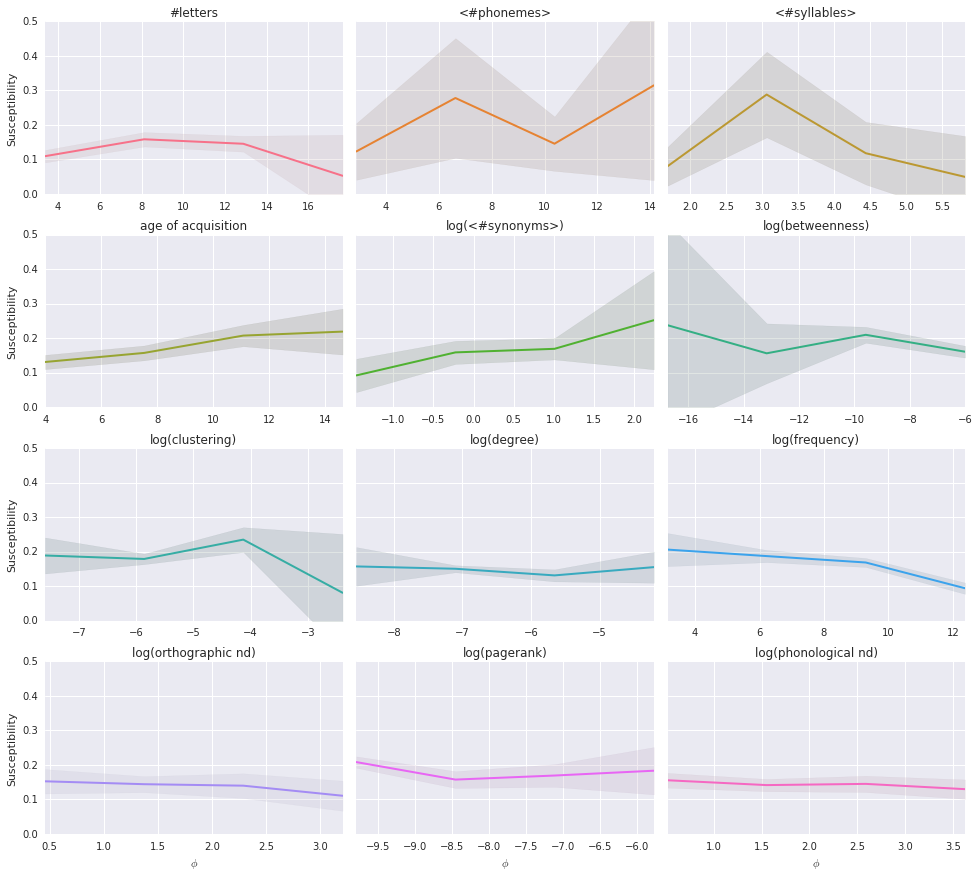

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=susties, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

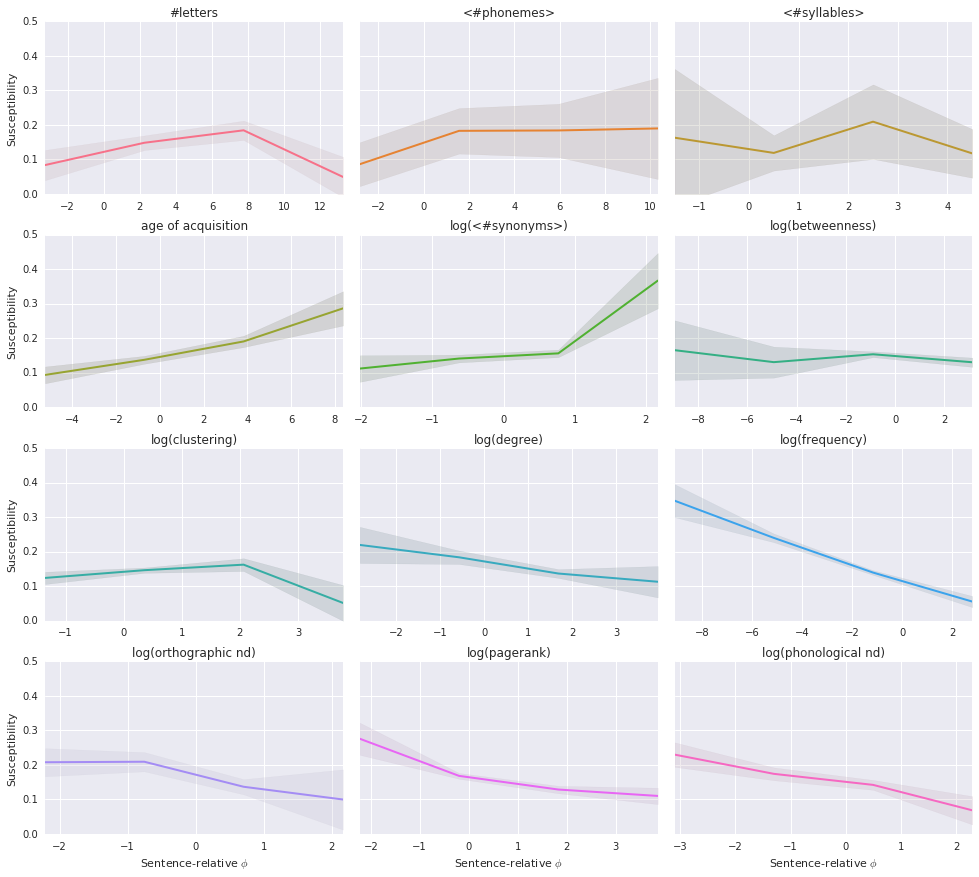

In [8]:
g = sb.FacetGrid(data=susties_rel, col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on how confidence intervals are computed here**

There are three ways I can conceive of the computation represented in the graphs above:
1. For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.
2. Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. This is the way CIs are computed above.
3. Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values. So for now I'm sticking with (2).

### 2.2 Feature susceptibilities, reduced to features we expose in the paper

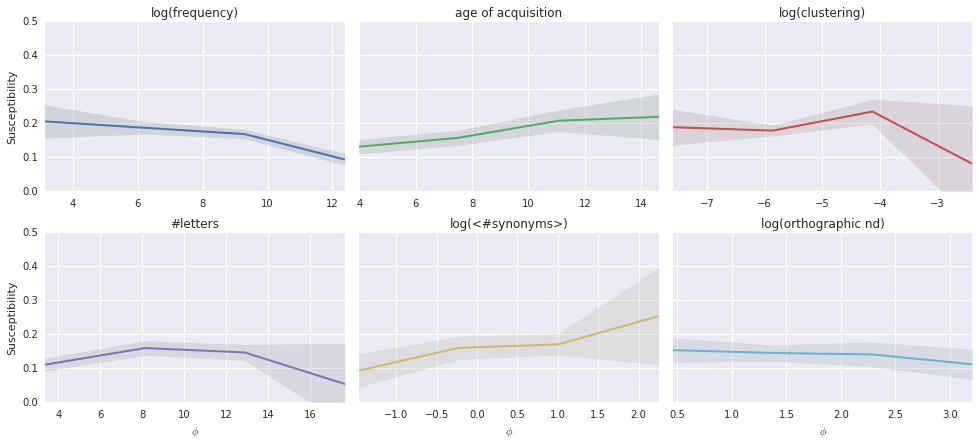

In [9]:
g = sb.FacetGrid(data=susties[susties['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

Now with sentence-relative values.

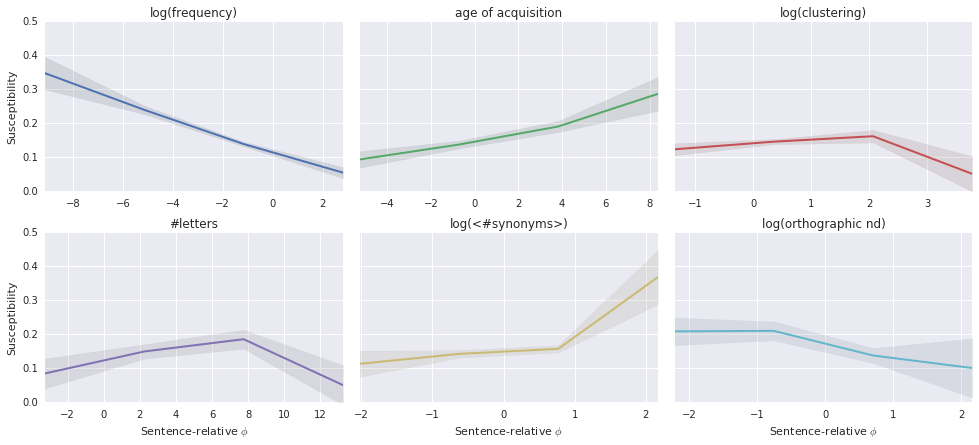

In [10]:
g = sb.FacetGrid(data=susties_rel[susties_rel['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=True, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_susties, relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'Sentence-relative $\phi$')
g.set_ylabels('Susceptibility')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

## 3 On which POS tags do substitutions fall?

In [11]:
poses = susty_words[susty_words.feature == 'aoa'][['POS', 'cluster_id', 'destination_id',
                                                   'occurrence', 'source_id', 'target',
                                                   'weight', 'weight_appeared', 'word']]
# Only take first letter of POS code to denote categories,
# and group stopword-like categories together.
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']
poses['rPOS'] = poses['POS']\
    .apply(lambda x: x[0])\
    .apply(lambda x: 'Stopword-like' if x in stop_poses else x)

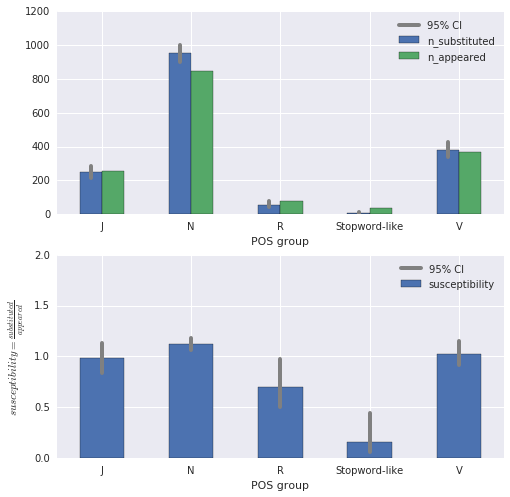

In [12]:
# Compute POS counts.
susty_pos = lambda x: ((x * poses.loc[x.index, 'weight']).sum() /
                       poses.loc[x.index, 'weight_appeared'].sum())
susties_pos = poses.groupby('rPOS')['target'].aggregate(
    {'susceptibility': susty_pos,
     'n_substituted': lambda x: (x * poses.loc[x.index, 'weight']).sum(),
     'n_appeared': lambda x: poses.loc[x.index, 'weight_appeared'].sum()}
).rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']].plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(), method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted, lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility'].plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], cis[i] * total_substituted / susties_pos.n_appeared.iloc[i],
                 lw=4, color='grey', label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-pos_susceptibilities'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [13]:
# Test the n_substituted proportions are different from the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 4 Susceptibility in terms of absolute fractiles

In [14]:
def plot_absolute_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')

    # Compute feature bins.
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            x_fractiles = pd.qcut(data.value, bin_count, labels=False)
            break
        except ValueError:
            pass

    # Compute bin counts
    heights = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = data[data.target & (x_fractiles == i)].weight.sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, bin_count + 1), heights, color=color)
    plt.fill_between(range(1, bin_count + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, bin_count + 1))
    plt.xlim(1, bin_count)
    plt.ylim(0, None)

### 4.1 All features susceptibilities

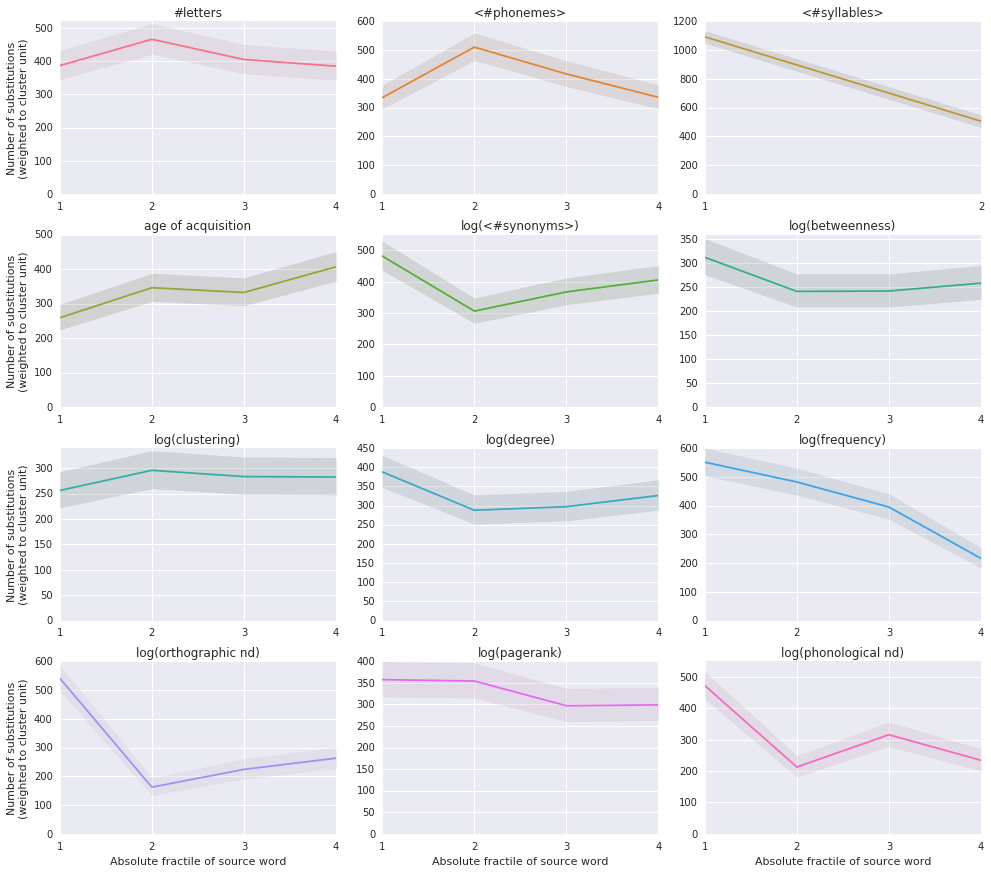

In [15]:
# Now plot.
g = sb.FacetGrid(data=susty_words, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're again in case (3) of the above explanation on confidence intervals (in section 2): it's really like a multinomial sampling, but not quite since not all absolute feature fractiles are available to sample from in all the sentences. Again, there's no way out of this, so we're going to use multinomial CIs.

### 4.2 Feature susceptibilities, reduced to features we expose in the paper

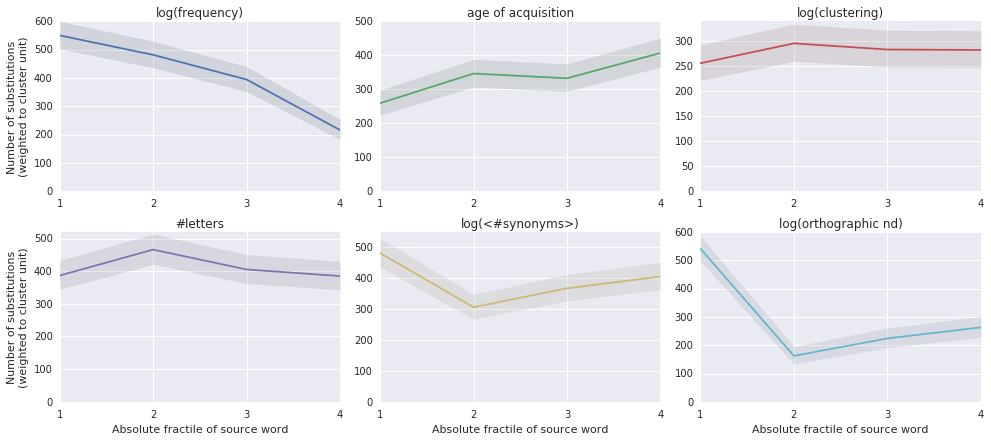

In [16]:
# Now plot.
g = sb.FacetGrid(data=susty_words[susty_words['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_absolute_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Absolute fractile of source word')
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-absolute'),
                  bbox_inches='tight', dpi=300)

## 5 Susceptibility in terms of sentence fractiles

Build our data.

In [17]:
data = []
for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, _ = substitution.features(feature)
            if np.isnan(source):
                # The source word has no feature value. We drop this substitution.
                continue
            sentence, _ = substitution.source_destination_features(feature)
            # Remove stopwords from this analysis, since we dropped substitutions on stopwords.
            dslice = slice(substitution.start,
                           substitution.start + len(substitution.destination.tokens))
            is_stopword = np.array([(lemma in stopwords) or (token in stopwords)
                                    for (lemma, token) in
                                    zip(substitution.source.lemmas[dslice],
                                        substitution.source.tokens[dslice])])
            sentence[is_stopword] = np.nan
            # Find the number of bins we'll use.
            values = set(sentence[np.isfinite(sentence)])
            if len(values) == 0 or len(values) == 1:
                # Only NaNs, or only one feature value. Drop this.
                continue
            start, stop = None, None
            power = 0
            while start is None:
                if int(BIN_COUNT / 2**power) * 2**power != BIN_COUNT:
                    raise ValueError('BIN_COUNT must be a power of 2')
                try:
                    start = 2**power * pd.qcut(sentence, int(BIN_COUNT / 2**power),
                                               labels=False)[substitution.position]
                    stop = start + 2**power
                except ValueError:
                    power += 1
            # And finally save the bin.
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'start': start,
                         'stop': stop})

original_fractiles = pd.DataFrame(data)
del data

  0% (    1 of 67981) |            | Elapsed Time: 0:00:01 ETA:  1 day, 11:04:00

  0% (    9 of 67981) |                    | Elapsed Time: 0:00:03 ETA:  2:54:50

  0% (   19 of 67981) |                    | Elapsed Time: 0:00:04 ETA:  2:26:23

  0% (   25 of 67981) |                    | Elapsed Time: 0:00:05 ETA:  2:40:55

  0% (   38 of 67981) |                    | Elapsed Time: 0:00:06 ETA:  2:18:08

  0% (   49 of 67981) |                    | Elapsed Time: 0:00:07 ETA:  2:10:10

  0% (   66 of 67981) |                    | Elapsed Time: 0:00:08 ETA:  1:53:40

  0% (   80 of 67981) |                    | Elapsed Time: 0:00:09 ETA:  1:48:09

  0% (   98 of 67981) |                    | Elapsed Time: 0:00:10 ETA:  1:40:11

  0% (  110 of 67981) |                    | Elapsed Time: 0:00:11 ETA:  1:40:00

  0% (  120 of 67981) |                    | Elapsed Time: 0:00:12 ETA:  1:35:54

  0% (  135 of 67981) |                    | Elapsed Time: 0:00:13 ETA:  1:31:07

  0% (  157 of 67981) |                    | Elapsed Time: 0:00:14 ETA:  1:19:30

  0% (  177 of 67981) |                    | Elapsed Time: 0:00:15 ETA:  1:15:01

  0% (  185 of 67981) |                    | Elapsed Time: 0:00:16 ETA:  1:19:05

  0% (  192 of 67981) |                    | Elapsed Time: 0:00:17 ETA:  1:25:20

  0% (  217 of 67981) |                    | Elapsed Time: 0:00:18 ETA:  1:18:32

  0% (  243 of 67981) |                    | Elapsed Time: 0:00:19 ETA:  1:14:04

  0% (  264 of 67981) |                    | Elapsed Time: 0:00:20 ETA:  1:09:28

  0% (  288 of 67981) |                    | Elapsed Time: 0:00:21 ETA:  1:03:35

  0% (  308 of 67981) |                    | Elapsed Time: 0:00:23 ETA:  1:01:57

  0% (  327 of 67981) |                    | Elapsed Time: 0:00:24 ETA:  1:02:58

  0% (  356 of 67981) |                    | Elapsed Time: 0:00:25 ETA:  0:59:31

  0% (  382 of 67981) |                    | Elapsed Time: 0:00:26 ETA:  0:52:26

  0% (  398 of 67981) |                    | Elapsed Time: 0:00:27 ETA:  0:50:34

  0% (  415 of 67981) |                    | Elapsed Time: 0:00:28 ETA:  0:52:26

  0% (  441 of 67981) |                    | Elapsed Time: 0:00:29 ETA:  0:52:19

  0% (  461 of 67981) |                    | Elapsed Time: 0:00:30 ETA:  0:52:39

  0% (  477 of 67981) |                    | Elapsed Time: 0:00:31 ETA:  0:54:57

  0% (  491 of 67981) |                    | Elapsed Time: 0:00:32 ETA:  0:56:30

  0% (  513 of 67981) |                    | Elapsed Time: 0:00:33 ETA:  0:55:46

  0% (  530 of 67981) |                    | Elapsed Time: 0:00:34 ETA:  0:59:42

  0% (  549 of 67981) |                    | Elapsed Time: 0:00:35 ETA:  1:02:28

  0% (  568 of 67981) |                    | Elapsed Time: 0:00:36 ETA:  1:01:03

  0% (  582 of 67981) |                    | Elapsed Time: 0:00:37 ETA:  1:02:47

  0% (  600 of 67981) |                    | Elapsed Time: 0:00:38 ETA:  1:06:02

  0% (  628 of 67981) |                    | Elapsed Time: 0:00:39 ETA:  1:02:45

  0% (  648 of 67981) |                    | Elapsed Time: 0:00:40 ETA:  1:01:17

  0% (  665 of 67981) |                    | Elapsed Time: 0:00:41 ETA:  1:00:03

  0% (  675 of 67981) |                    | Elapsed Time: 0:00:42 ETA:  1:06:18

  1% (  687 of 67981) |                    | Elapsed Time: 0:00:43 ETA:  1:08:42

  1% (  695 of 67981) |                    | Elapsed Time: 0:00:45 ETA:  1:14:04

  1% (  703 of 67981) |                    | Elapsed Time: 0:00:46 ETA:  1:20:10

  1% (  712 of 67981) |                    | Elapsed Time: 0:00:47 ETA:  1:22:26

  1% (  725 of 67981) |                    | Elapsed Time: 0:00:48 ETA:  1:25:37

  1% (  735 of 67981) |                    | Elapsed Time: 0:00:49 ETA:  1:40:02

  1% (  752 of 67981) |                    | Elapsed Time: 0:00:50 ETA:  1:43:49

  1% (  763 of 67981) |                    | Elapsed Time: 0:00:51 ETA:  1:51:54

  1% (  778 of 67981) |                    | Elapsed Time: 0:00:52 ETA:  1:43:31

  1% (  788 of 67981) |                    | Elapsed Time: 0:00:53 ETA:  1:47:35

  1% (  794 of 67981) |                    | Elapsed Time: 0:00:54 ETA:  1:49:57

  1% (  805 of 67981) |                    | Elapsed Time: 0:00:55 ETA:  1:46:47

  1% (  815 of 67981) |                    | Elapsed Time: 0:00:56 ETA:  1:46:27

  1% (  820 of 67981) |                    | Elapsed Time: 0:00:57 ETA:  1:55:52

  1% (  834 of 67981) |                    | Elapsed Time: 0:00:59 ETA:  1:53:27

  1% (  840 of 67981) |                    | Elapsed Time: 0:01:00 ETA:  2:09:55

  1% (  841 of 67981) |                    | Elapsed Time: 0:01:01 ETA:  2:26:16

  1% (  843 of 67981) |                    | Elapsed Time: 0:01:03 ETA:  3:17:22

  1% (  848 of 67981) |                    | Elapsed Time: 0:01:04 ETA:  3:30:29

  1% (  850 of 67981) |                    | Elapsed Time: 0:01:05 ETA:  3:37:35

  1% (  868 of 67981) |                    | Elapsed Time: 0:01:06 ETA:  3:12:27

  1% (  880 of 67981) |                    | Elapsed Time: 0:01:07 ETA:  3:05:22

  1% (  900 of 67981) |                    | Elapsed Time: 0:01:08 ETA:  2:30:16

  1% (  925 of 67981) |                    | Elapsed Time: 0:01:09 ETA:  2:09:50

  1% (  943 of 67981) |                    | Elapsed Time: 0:01:10 ETA:  1:51:53

  1% (  962 of 67981) |                    | Elapsed Time: 0:01:11 ETA:  1:34:44

  1% (  984 of 67981) |                    | Elapsed Time: 0:01:12 ETA:  1:10:56

  1% ( 1006 of 67981) |                    | Elapsed Time: 0:01:13 ETA:  1:02:45

  1% ( 1021 of 67981) |                    | Elapsed Time: 0:01:14 ETA:  1:00:51

  1% ( 1039 of 67981) |                    | Elapsed Time: 0:01:15 ETA:  1:00:57

  1% ( 1049 of 67981) |                    | Elapsed Time: 0:01:17 ETA:  1:02:09

  1% ( 1064 of 67981) |                    | Elapsed Time: 0:01:18 ETA:  1:04:48

  1% ( 1075 of 67981) |                    | Elapsed Time: 0:01:19 ETA:  1:15:40

  1% ( 1084 of 67981) |                    | Elapsed Time: 0:01:20 ETA:  1:20:42

  1% ( 1107 of 67981) |                    | Elapsed Time: 0:01:21 ETA:  1:18:08

  1% ( 1128 of 67981) |                    | Elapsed Time: 0:01:23 ETA:  1:19:32

  1% ( 1134 of 67981) |                    | Elapsed Time: 0:01:24 ETA:  1:32:45

  1% ( 1158 of 67981) |                    | Elapsed Time: 0:01:25 ETA:  1:25:23

  1% ( 1174 of 67981) |                    | Elapsed Time: 0:01:26 ETA:  1:28:09

  1% ( 1183 of 67981) |                    | Elapsed Time: 0:01:27 ETA:  1:28:13

  1% ( 1198 of 67981) |                    | Elapsed Time: 0:01:28 ETA:  1:27:23

  1% ( 1210 of 67981) |                    | Elapsed Time: 0:01:29 ETA:  1:21:39

  1% ( 1224 of 67981) |                    | Elapsed Time: 0:01:30 ETA:  1:18:29

  1% ( 1238 of 67981) |                    | Elapsed Time: 0:01:31 ETA:  1:25:21

  1% ( 1253 of 67981) |                    | Elapsed Time: 0:01:32 ETA:  1:28:27

  1% ( 1267 of 67981) |                    | Elapsed Time: 0:01:34 ETA:  1:20:50

  1% ( 1283 of 67981) |                    | Elapsed Time: 0:01:35 ETA:  1:25:59

  1% ( 1299 of 67981) |                    | Elapsed Time: 0:01:36 ETA:  1:24:19

  1% ( 1320 of 67981) |                    | Elapsed Time: 0:01:37 ETA:  1:17:09

  1% ( 1328 of 67981) |                    | Elapsed Time: 0:01:38 ETA:  1:21:28

  1% ( 1339 of 67981) |                    | Elapsed Time: 0:01:39 ETA:  1:21:55

  1% ( 1353 of 67981) |                    | Elapsed Time: 0:01:40 ETA:  1:21:41

  2% ( 1366 of 67981) |                    | Elapsed Time: 0:01:41 ETA:  1:20:38

  2% ( 1381 of 67981) |                    | Elapsed Time: 0:01:42 ETA:  1:21:19

  2% ( 1398 of 67981) |                    | Elapsed Time: 0:01:43 ETA:  1:18:51

  2% ( 1419 of 67981) |                    | Elapsed Time: 0:01:44 ETA:  1:15:58

  2% ( 1444 of 67981) |                    | Elapsed Time: 0:01:45 ETA:  1:11:20

  2% ( 1485 of 67981) |                    | Elapsed Time: 0:01:46 ETA:  1:02:19

  2% ( 1520 of 67981) |                    | Elapsed Time: 0:01:47 ETA:  0:53:04

  2% ( 1548 of 67981) |                    | Elapsed Time: 0:01:48 ETA:  0:48:25

  2% ( 1582 of 67981) |                    | Elapsed Time: 0:01:49 ETA:  0:44:00

  2% ( 1605 of 67981) |                    | Elapsed Time: 0:01:50 ETA:  0:42:12

  2% ( 1632 of 67981) |                    | Elapsed Time: 0:01:51 ETA:  0:39:45

  2% ( 1654 of 67981) |                    | Elapsed Time: 0:01:52 ETA:  0:38:46

  2% ( 1681 of 67981) |                    | Elapsed Time: 0:01:53 ETA:  0:38:06

  2% ( 1692 of 67981) |                    | Elapsed Time: 0:01:54 ETA:  0:40:25

  2% ( 1700 of 67981) |                    | Elapsed Time: 0:01:55 ETA:  0:43:43

  2% ( 1745 of 67981) |                    | Elapsed Time: 0:01:56 ETA:  0:41:39

  2% ( 1784 of 67981) |                    | Elapsed Time: 0:01:57 ETA:  0:39:39

  2% ( 1834 of 67981) |                    | Elapsed Time: 0:01:58 ETA:  0:37:05

  2% ( 1864 of 67981) |                    | Elapsed Time: 0:01:59 ETA:  0:35:54

  2% ( 1916 of 67981) |                    | Elapsed Time: 0:02:00 ETA:  0:32:31

  2% ( 1982 of 67981) |                    | Elapsed Time: 0:02:01 ETA:  0:27:56

  2% ( 2035 of 67981) |                    | Elapsed Time: 0:02:02 ETA:  0:25:29

  3% ( 2100 of 67981) |                    | Elapsed Time: 0:02:03 ETA:  0:21:42

  3% ( 2156 of 67981) |                    | Elapsed Time: 0:02:04 ETA:  0:20:37

  3% ( 2219 of 67981) |                    | Elapsed Time: 0:02:05 ETA:  0:19:43

  3% ( 2278 of 67981) |                    | Elapsed Time: 0:02:06 ETA:  0:18:48

  3% ( 2329 of 67981) |                    | Elapsed Time: 0:02:07 ETA:  0:18:42

  3% ( 2383 of 67981) |                    | Elapsed Time: 0:02:08 ETA:  0:17:45

  3% ( 2428 of 67981) |                    | Elapsed Time: 0:02:09 ETA:  0:18:00

  3% ( 2463 of 67981) |                    | Elapsed Time: 0:02:10 ETA:  0:19:17

  3% ( 2495 of 67981) |                    | Elapsed Time: 0:02:11 ETA:  0:20:17

  3% ( 2531 of 67981) |                    | Elapsed Time: 0:02:12 ETA:  0:21:46

  3% ( 2550 of 67981) |                    | Elapsed Time: 0:02:12 ETA:  0:22:21

  3% ( 2604 of 67981) |                    | Elapsed Time: 0:02:13 ETA:  0:22:55

  3% ( 2655 of 67981) |                    | Elapsed Time: 0:02:14 ETA:  0:23:28

  3% ( 2701 of 67981) |                    | Elapsed Time: 0:02:15 ETA:  0:23:46

  4% ( 2747 of 67981) |                    | Elapsed Time: 0:02:16 ETA:  0:24:42

  4% ( 2793 of 67981) |                    | Elapsed Time: 0:02:17 ETA:  0:24:34

  4% ( 2856 of 67981) |                    | Elapsed Time: 0:02:19 ETA:  0:22:38

  4% ( 2902 of 67981) |                    | Elapsed Time: 0:02:20 ETA:  0:21:44

  4% ( 2943 of 67981) |                    | Elapsed Time: 0:02:21 ETA:  0:21:27

  4% ( 2977 of 67981) |                    | Elapsed Time: 0:02:22 ETA:  0:22:09

  4% ( 3056 of 67981) |                    | Elapsed Time: 0:02:23 ETA:  0:20:46

  4% ( 3131 of 67981) |                    | Elapsed Time: 0:02:24 ETA:  0:19:34

  4% ( 3183 of 67981) |                    | Elapsed Time: 0:02:25 ETA:  0:19:16

  4% ( 3221 of 67981) |                    | Elapsed Time: 0:02:26 ETA:  0:19:17

  4% ( 3264 of 67981) |                    | Elapsed Time: 0:02:27 ETA:  0:19:29

  4% ( 3310 of 67981) |                    | Elapsed Time: 0:02:28 ETA:  0:20:15

  4% ( 3357 of 67981) |                    | Elapsed Time: 0:02:29 ETA:  0:20:10

  5% ( 3400 of 67981) |#                   | Elapsed Time: 0:02:30 ETA:  0:19:55

  5% ( 3426 of 67981) |#                   | Elapsed Time: 0:02:31 ETA:  0:20:33

  5% ( 3436 of 67981) |#                   | Elapsed Time: 0:02:32 ETA:  0:25:10

  5% ( 3462 of 67981) |#                   | Elapsed Time: 0:02:33 ETA:  0:29:17

  5% ( 3499 of 67981) |#                   | Elapsed Time: 0:02:34 ETA:  0:31:06

  5% ( 3522 of 67981) |#                   | Elapsed Time: 0:02:35 ETA:  0:32:49

  5% ( 3548 of 67981) |#                   | Elapsed Time: 0:02:36 ETA:  0:34:55

  5% ( 3582 of 67981) |#                   | Elapsed Time: 0:02:37 ETA:  0:36:40

  5% ( 3624 of 67981) |#                   | Elapsed Time: 0:02:38 ETA:  0:37:33

  5% ( 3663 of 67981) |#                   | Elapsed Time: 0:02:39 ETA:  0:38:23

  5% ( 3720 of 67981) |#                   | Elapsed Time: 0:02:40 ETA:  0:33:49

  5% ( 3752 of 67981) |#                   | Elapsed Time: 0:02:41 ETA:  0:30:58

  5% ( 3809 of 67981) |#                   | Elapsed Time: 0:02:42 ETA:  0:27:54

  5% ( 3838 of 67981) |#                   | Elapsed Time: 0:02:43 ETA:  0:28:46

  5% ( 3867 of 67981) |#                   | Elapsed Time: 0:02:44 ETA:  0:28:09

  5% ( 3926 of 67981) |#                   | Elapsed Time: 0:02:45 ETA:  0:25:26

  5% ( 3973 of 67981) |#                   | Elapsed Time: 0:02:46 ETA:  0:24:32

  5% ( 4013 of 67981) |#                   | Elapsed Time: 0:02:47 ETA:  0:24:33

  5% ( 4069 of 67981) |#                   | Elapsed Time: 0:02:48 ETA:  0:23:20

  6% ( 4113 of 67981) |#                   | Elapsed Time: 0:02:50 ETA:  0:24:03

  6% ( 4142 of 67981) |#                   | Elapsed Time: 0:02:51 ETA:  0:24:12

  6% ( 4164 of 67981) |#                   | Elapsed Time: 0:02:52 ETA:  0:26:53

  6% ( 4193 of 67981) |#                   | Elapsed Time: 0:02:53 ETA:  0:26:30

  6% ( 4218 of 67981) |#                   | Elapsed Time: 0:02:54 ETA:  0:26:52

  6% ( 4238 of 67981) |#                   | Elapsed Time: 0:02:55 ETA:  0:30:31

  6% ( 4249 of 67981) |#                   | Elapsed Time: 0:02:55 ETA:  0:32:23

  6% ( 4284 of 67981) |#                   | Elapsed Time: 0:02:56 ETA:  0:32:59

  6% ( 4304 of 67981) |#                   | Elapsed Time: 0:02:57 ETA:  0:38:42

  6% ( 4336 of 67981) |#                   | Elapsed Time: 0:02:58 ETA:  0:40:58

  6% ( 4371 of 67981) |#                   | Elapsed Time: 0:02:59 ETA:  0:39:50

  6% ( 4395 of 67981) |#                   | Elapsed Time: 0:03:00 ETA:  0:39:25

  6% ( 4427 of 67981) |#                   | Elapsed Time: 0:03:01 ETA:  0:38:42

  6% ( 4454 of 67981) |#                   | Elapsed Time: 0:03:02 ETA:  0:38:35

  6% ( 4486 of 67981) |#                   | Elapsed Time: 0:03:03 ETA:  0:36:37

  6% ( 4528 of 67981) |#                   | Elapsed Time: 0:03:04 ETA:  0:34:28

  6% ( 4573 of 67981) |#                   | Elapsed Time: 0:03:05 ETA:  0:33:12

  6% ( 4606 of 67981) |#                   | Elapsed Time: 0:03:06 ETA:  0:31:27

  6% ( 4647 of 67981) |#                   | Elapsed Time: 0:03:07 ETA:  0:30:26

  6% ( 4687 of 67981) |#                   | Elapsed Time: 0:03:08 ETA:  0:29:38

  6% ( 4727 of 67981) |#                   | Elapsed Time: 0:03:09 ETA:  0:28:01

  6% ( 4748 of 67981) |#                   | Elapsed Time: 0:03:10 ETA:  0:29:12

  7% ( 4776 of 67981) |#                   | Elapsed Time: 0:03:11 ETA:  0:29:08

  7% ( 4820 of 67981) |#                   | Elapsed Time: 0:03:13 ETA:  0:27:52

  7% ( 4875 of 67981) |#                   | Elapsed Time: 0:03:14 ETA:  0:26:41

  7% ( 4923 of 67981) |#                   | Elapsed Time: 0:03:15 ETA:  0:26:24

  7% ( 4976 of 67981) |#                   | Elapsed Time: 0:03:16 ETA:  0:24:47

  7% ( 5011 of 67981) |#                   | Elapsed Time: 0:03:17 ETA:  0:25:18

  7% ( 5050 of 67981) |#                   | Elapsed Time: 0:03:18 ETA:  0:25:22

  7% ( 5099 of 67981) |#                   | Elapsed Time: 0:03:19 ETA:  0:24:41

  7% ( 5149 of 67981) |#                   | Elapsed Time: 0:03:20 ETA:  0:22:34

  7% ( 5202 of 67981) |#                   | Elapsed Time: 0:03:21 ETA:  0:20:50

  7% ( 5236 of 67981) |#                   | Elapsed Time: 0:03:22 ETA:  0:21:30

  7% ( 5295 of 67981) |#                   | Elapsed Time: 0:03:23 ETA:  0:21:14

  7% ( 5358 of 67981) |#                   | Elapsed Time: 0:03:24 ETA:  0:20:21

  7% ( 5411 of 67981) |#                   | Elapsed Time: 0:03:25 ETA:  0:20:20

  8% ( 5465 of 67981) |#                   | Elapsed Time: 0:03:26 ETA:  0:19:24

  8% ( 5489 of 67981) |#                   | Elapsed Time: 0:03:27 ETA:  0:20:09

  8% ( 5522 of 67981) |#                   | Elapsed Time: 0:03:28 ETA:  0:21:01

  8% ( 5585 of 67981) |#                   | Elapsed Time: 0:03:29 ETA:  0:20:17

  8% ( 5645 of 67981) |#                   | Elapsed Time: 0:03:30 ETA:  0:19:52

  8% ( 5697 of 67981) |#                   | Elapsed Time: 0:03:31 ETA:  0:18:51

  8% ( 5754 of 67981) |#                   | Elapsed Time: 0:03:32 ETA:  0:18:58

  8% ( 5817 of 67981) |#                   | Elapsed Time: 0:03:33 ETA:  0:18:59

  8% ( 5876 of 67981) |#                   | Elapsed Time: 0:03:34 ETA:  0:18:40

  8% ( 5916 of 67981) |#                   | Elapsed Time: 0:03:35 ETA:  0:19:12

  8% ( 5949 of 67981) |#                   | Elapsed Time: 0:03:36 ETA:  0:18:21

  8% ( 5977 of 67981) |#                   | Elapsed Time: 0:03:37 ETA:  0:18:45

  8% ( 6001 of 67981) |#                   | Elapsed Time: 0:03:38 ETA:  0:20:52

  8% ( 6016 of 67981) |#                   | Elapsed Time: 0:03:39 ETA:  0:23:52

  8% ( 6064 of 67981) |#                   | Elapsed Time: 0:03:40 ETA:  0:24:11

  8% ( 6112 of 67981) |#                   | Elapsed Time: 0:03:41 ETA:  0:24:51

  9% ( 6153 of 67981) |#                   | Elapsed Time: 0:03:42 ETA:  0:26:40

  9% ( 6194 of 67981) |#                   | Elapsed Time: 0:03:43 ETA:  0:28:24

  9% ( 6213 of 67981) |#                   | Elapsed Time: 0:03:44 ETA:  0:30:43

  9% ( 6238 of 67981) |#                   | Elapsed Time: 0:03:45 ETA:  0:32:17

  9% ( 6260 of 67981) |#                   | Elapsed Time: 0:03:46 ETA:  0:32:50

  9% ( 6294 of 67981) |#                   | Elapsed Time: 0:03:47 ETA:  0:31:29

  9% ( 6324 of 67981) |#                   | Elapsed Time: 0:03:48 ETA:  0:29:46

  9% ( 6378 of 67981) |#                   | Elapsed Time: 0:03:49 ETA:  0:29:04

  9% ( 6440 of 67981) |#                   | Elapsed Time: 0:03:50 ETA:  0:27:38

  9% ( 6495 of 67981) |#                   | Elapsed Time: 0:03:51 ETA:  0:26:19

  9% ( 6525 of 67981) |#                   | Elapsed Time: 0:03:52 ETA:  0:27:19

  9% ( 6590 of 67981) |#                   | Elapsed Time: 0:03:53 ETA:  0:23:27

  9% ( 6637 of 67981) |#                   | Elapsed Time: 0:03:54 ETA:  0:21:55

  9% ( 6691 of 67981) |#                   | Elapsed Time: 0:03:55 ETA:  0:20:06

  9% ( 6728 of 67981) |#                   | Elapsed Time: 0:03:56 ETA:  0:19:55

  9% ( 6770 of 67981) |#                   | Elapsed Time: 0:03:57 ETA:  0:19:15

 10% ( 6799 of 67981) |##                  | Elapsed Time: 0:03:58 ETA:  0:20:04

 10% ( 6836 of 67981) |##                  | Elapsed Time: 0:03:59 ETA:  0:21:43

 10% ( 6875 of 67981) |##                  | Elapsed Time: 0:04:00 ETA:  0:22:49

 10% ( 6886 of 67981) |##                  | Elapsed Time: 0:04:01 ETA:  0:24:40

 10% ( 6893 of 67981) |##                  | Elapsed Time: 0:04:02 ETA:  0:30:25

 10% ( 6902 of 67981) |##                  | Elapsed Time: 0:04:03 ETA:  0:35:34

 10% ( 6908 of 67981) |##                  | Elapsed Time: 0:04:05 ETA:  0:47:14

 10% ( 6918 of 67981) |##                  | Elapsed Time: 0:04:06 ETA:  0:55:11

 10% ( 6933 of 67981) |##                  | Elapsed Time: 0:04:07 ETA:  1:04:51

 10% ( 6962 of 67981) |##                  | Elapsed Time: 0:04:08 ETA:  1:06:24

 10% ( 6999 of 67981) |##                  | Elapsed Time: 0:04:09 ETA:  1:06:01

 10% ( 7048 of 67981) |##                  | Elapsed Time: 0:04:10 ETA:  1:01:54

 10% ( 7101 of 67981) |##                  | Elapsed Time: 0:04:11 ETA:  0:48:14

 10% ( 7152 of 67981) |##                  | Elapsed Time: 0:04:12 ETA:  0:39:02

 10% ( 7185 of 67981) |##                  | Elapsed Time: 0:04:13 ETA:  0:35:08

 10% ( 7237 of 67981) |##                  | Elapsed Time: 0:04:14 ETA:  0:27:29

 10% ( 7267 of 67981) |##                  | Elapsed Time: 0:04:15 ETA:  0:25:17

 10% ( 7293 of 67981) |##                  | Elapsed Time: 0:04:16 ETA:  0:24:22

 10% ( 7330 of 67981) |##                  | Elapsed Time: 0:04:17 ETA:  0:23:45

 10% ( 7361 of 67981) |##                  | Elapsed Time: 0:04:18 ETA:  0:24:16

 10% ( 7388 of 67981) |##                  | Elapsed Time: 0:04:19 ETA:  0:26:09

 10% ( 7415 of 67981) |##                  | Elapsed Time: 0:04:20 ETA:  0:28:40

 10% ( 7464 of 67981) |##                  | Elapsed Time: 0:04:21 ETA:  0:28:49

 11% ( 7497 of 67981) |##                  | Elapsed Time: 0:04:22 ETA:  0:28:50

 11% ( 7519 of 67981) |##                  | Elapsed Time: 0:04:23 ETA:  0:32:22

 11% ( 7571 of 67981) |##                  | Elapsed Time: 0:04:24 ETA:  0:29:44

 11% ( 7618 of 67981) |##                  | Elapsed Time: 0:04:25 ETA:  0:27:31

 11% ( 7648 of 67981) |##                  | Elapsed Time: 0:04:26 ETA:  0:26:58

 11% ( 7700 of 67981) |##                  | Elapsed Time: 0:04:27 ETA:  0:24:57

 11% ( 7759 of 67981) |##                  | Elapsed Time: 0:04:28 ETA:  0:22:27

 11% ( 7804 of 67981) |##                  | Elapsed Time: 0:04:29 ETA:  0:21:24

 11% ( 7855 of 67981) |##                  | Elapsed Time: 0:04:30 ETA:  0:21:17

 11% ( 7884 of 67981) |##                  | Elapsed Time: 0:04:31 ETA:  0:21:34

 11% ( 7913 of 67981) |##                  | Elapsed Time: 0:04:32 ETA:  0:21:03

 11% ( 7943 of 67981) |##                  | Elapsed Time: 0:04:33 ETA:  0:22:33

 11% ( 7975 of 67981) |##                  | Elapsed Time: 0:04:34 ETA:  0:23:43

 11% ( 8005 of 67981) |##                  | Elapsed Time: 0:04:35 ETA:  0:24:49

 11% ( 8039 of 67981) |##                  | Elapsed Time: 0:04:36 ETA:  0:26:27

 11% ( 8063 of 67981) |##                  | Elapsed Time: 0:04:37 ETA:  0:30:10

 11% ( 8082 of 67981) |##                  | Elapsed Time: 0:04:38 ETA:  0:33:24

 11% ( 8112 of 67981) |##                  | Elapsed Time: 0:04:39 ETA:  0:36:32

 11% ( 8145 of 67981) |##                  | Elapsed Time: 0:04:40 ETA:  0:35:47

 12% ( 8197 of 67981) |##                  | Elapsed Time: 0:04:41 ETA:  0:32:45

 12% ( 8250 of 67981) |##                  | Elapsed Time: 0:04:42 ETA:  0:29:53

 12% ( 8302 of 67981) |##                  | Elapsed Time: 0:04:44 ETA:  0:27:44

 12% ( 8358 of 67981) |##                  | Elapsed Time: 0:04:45 ETA:  0:25:16

 12% ( 8409 of 67981) |##                  | Elapsed Time: 0:04:46 ETA:  0:23:49

 12% ( 8468 of 67981) |##                  | Elapsed Time: 0:04:47 ETA:  0:21:07

 12% ( 8498 of 67981) |##                  | Elapsed Time: 0:04:47 ETA:  0:18:43

 12% ( 8547 of 67981) |##                  | Elapsed Time: 0:04:48 ETA:  0:17:39

 12% ( 8616 of 67981) |##                  | Elapsed Time: 0:04:49 ETA:  0:15:55

 12% ( 8706 of 67981) |##                  | Elapsed Time: 0:04:50 ETA:  0:14:12

 12% ( 8766 of 67981) |##                  | Elapsed Time: 0:04:51 ETA:  0:13:56

 12% ( 8815 of 67981) |##                  | Elapsed Time: 0:04:52 ETA:  0:14:02

 13% ( 8879 of 67981) |##                  | Elapsed Time: 0:04:53 ETA:  0:13:43

 13% ( 8949 of 67981) |##                  | Elapsed Time: 0:04:54 ETA:  0:13:03

 13% ( 9011 of 67981) |##                  | Elapsed Time: 0:04:55 ETA:  0:12:55

 13% ( 9081 of 67981) |##                  | Elapsed Time: 0:04:56 ETA:  0:12:44

 13% ( 9144 of 67981) |##                  | Elapsed Time: 0:04:57 ETA:  0:12:18

 13% ( 9214 of 67981) |##                  | Elapsed Time: 0:04:58 ETA:  0:12:15

 13% ( 9284 of 67981) |##                  | Elapsed Time: 0:04:59 ETA:  0:12:50

 13% ( 9348 of 67981) |##                  | Elapsed Time: 0:05:00 ETA:  0:12:22

 13% ( 9421 of 67981) |##                  | Elapsed Time: 0:05:01 ETA:  0:11:38

 13% ( 9489 of 67981) |##                  | Elapsed Time: 0:05:02 ETA:  0:11:30

 14% ( 9560 of 67981) |##                  | Elapsed Time: 0:05:03 ETA:  0:11:28

 14% ( 9631 of 67981) |##                  | Elapsed Time: 0:05:04 ETA:  0:11:13

 14% ( 9705 of 67981) |##                  | Elapsed Time: 0:05:05 ETA:  0:11:05

 14% ( 9773 of 67981) |##                  | Elapsed Time: 0:05:06 ETA:  0:10:56

 14% ( 9845 of 67981) |##                  | Elapsed Time: 0:05:07 ETA:  0:10:52

 14% ( 9914 of 67981) |##                  | Elapsed Time: 0:05:08 ETA:  0:10:53

 14% ( 9986 of 67981) |##                  | Elapsed Time: 0:05:09 ETA:  0:10:58

 14% (10059 of 67981) |##                  | Elapsed Time: 0:05:10 ETA:  0:10:57

 14% (10098 of 67981) |##                  | Elapsed Time: 0:05:11 ETA:  0:11:42

 14% (10154 of 67981) |##                  | Elapsed Time: 0:05:12 ETA:  0:12:05

 15% (10198 of 67981) |###                 | Elapsed Time: 0:05:13 ETA:  0:12:22

 15% (10264 of 67981) |###                 | Elapsed Time: 0:05:14 ETA:  0:12:37

 15% (10337 of 67981) |###                 | Elapsed Time: 0:05:15 ETA:  0:12:26

 15% (10408 of 67981) |###                 | Elapsed Time: 0:05:16 ETA:  0:12:26

 15% (10480 of 67981) |###                 | Elapsed Time: 0:05:17 ETA:  0:12:19

 15% (10547 of 67981) |###                 | Elapsed Time: 0:05:18 ETA:  0:12:32

 15% (10618 of 67981) |###                 | Elapsed Time: 0:05:19 ETA:  0:12:36

 15% (10679 of 67981) |###                 | Elapsed Time: 0:05:20 ETA:  0:11:55

 15% (10751 of 67981) |###                 | Elapsed Time: 0:05:21 ETA:  0:11:27

 15% (10817 of 67981) |###                 | Elapsed Time: 0:05:22 ETA:  0:11:20

 16% (10883 of 67981) |###                 | Elapsed Time: 0:05:23 ETA:  0:11:18

 16% (10936 of 67981) |###                 | Elapsed Time: 0:05:24 ETA:  0:11:51

 16% (11002 of 67981) |###                 | Elapsed Time: 0:05:25 ETA:  0:11:59

 16% (11047 of 67981) |###                 | Elapsed Time: 0:05:26 ETA:  0:12:07

 16% (11112 of 67981) |###                 | Elapsed Time: 0:05:27 ETA:  0:12:04

 16% (11180 of 67981) |###                 | Elapsed Time: 0:05:28 ETA:  0:12:10

 16% (11234 of 67981) |###                 | Elapsed Time: 0:05:29 ETA:  0:12:21

 16% (11302 of 67981) |###                 | Elapsed Time: 0:05:30 ETA:  0:12:27

 16% (11365 of 67981) |###                 | Elapsed Time: 0:05:31 ETA:  0:12:35

 16% (11415 of 67981) |###                 | Elapsed Time: 0:05:32 ETA:  0:13:08

 16% (11465 of 67981) |###                 | Elapsed Time: 0:05:33 ETA:  0:13:12

 16% (11515 of 67981) |###                 | Elapsed Time: 0:05:34 ETA:  0:13:46

 17% (11573 of 67981) |###                 | Elapsed Time: 0:05:35 ETA:  0:14:03

 17% (11636 of 67981) |###                 | Elapsed Time: 0:05:36 ETA:  0:14:06

 17% (11694 of 67981) |###                 | Elapsed Time: 0:05:37 ETA:  0:14:26

 17% (11751 of 67981) |###                 | Elapsed Time: 0:05:38 ETA:  0:14:19

 17% (11807 of 67981) |###                 | Elapsed Time: 0:05:39 ETA:  0:14:46

 17% (11862 of 67981) |###                 | Elapsed Time: 0:05:40 ETA:  0:15:01

 17% (11897 of 67981) |###                 | Elapsed Time: 0:05:40 ETA:  0:14:53

 17% (11958 of 67981) |###                 | Elapsed Time: 0:05:41 ETA:  0:14:25

 17% (12001 of 67981) |###                 | Elapsed Time: 0:05:43 ETA:  0:14:45

 17% (12051 of 67981) |###                 | Elapsed Time: 0:05:44 ETA:  0:15:02

 17% (12099 of 67981) |###                 | Elapsed Time: 0:05:45 ETA:  0:15:42

 17% (12176 of 67981) |###                 | Elapsed Time: 0:05:46 ETA:  0:14:52

 18% (12245 of 67981) |###                 | Elapsed Time: 0:05:47 ETA:  0:14:21

 18% (12302 of 67981) |###                 | Elapsed Time: 0:05:48 ETA:  0:14:18

 18% (12356 of 67981) |###                 | Elapsed Time: 0:05:49 ETA:  0:14:35

 18% (12427 of 67981) |###                 | Elapsed Time: 0:05:50 ETA:  0:13:49

 18% (12502 of 67981) |###                 | Elapsed Time: 0:05:51 ETA:  0:13:18

 18% (12572 of 67981) |###                 | Elapsed Time: 0:05:52 ETA:  0:12:19

 18% (12653 of 67981) |###                 | Elapsed Time: 0:05:53 ETA:  0:11:22

 18% (12713 of 67981) |###                 | Elapsed Time: 0:05:54 ETA:  0:11:21

 18% (12747 of 67981) |###                 | Elapsed Time: 0:05:54 ETA:  0:11:50

 18% (12807 of 67981) |###                 | Elapsed Time: 0:05:55 ETA:  0:12:04

 18% (12876 of 67981) |###                 | Elapsed Time: 0:05:57 ETA:  0:11:41

 19% (12944 of 67981) |###                 | Elapsed Time: 0:05:58 ETA:  0:11:02

 19% (13017 of 67981) |###                 | Elapsed Time: 0:05:59 ETA:  0:10:59

 19% (13063 of 67981) |###                 | Elapsed Time: 0:06:00 ETA:  0:11:53

 19% (13101 of 67981) |###                 | Elapsed Time: 0:06:01 ETA:  0:12:57

 19% (13168 of 67981) |###                 | Elapsed Time: 0:06:02 ETA:  0:13:26

 19% (13233 of 67981) |###                 | Elapsed Time: 0:06:03 ETA:  0:12:49

 19% (13283 of 67981) |###                 | Elapsed Time: 0:06:04 ETA:  0:13:06

 19% (13328 of 67981) |###                 | Elapsed Time: 0:06:05 ETA:  0:13:48

 19% (13386 of 67981) |###                 | Elapsed Time: 0:06:06 ETA:  0:14:12

 19% (13456 of 67981) |###                 | Elapsed Time: 0:06:07 ETA:  0:14:06

 19% (13494 of 67981) |###                 | Elapsed Time: 0:06:08 ETA:  0:15:34

 19% (13558 of 67981) |###                 | Elapsed Time: 0:06:09 ETA:  0:14:43

 19% (13586 of 67981) |###                 | Elapsed Time: 0:06:10 ETA:  0:15:08

 20% (13597 of 67981) |####                | Elapsed Time: 0:06:10 ETA:  0:16:06

 20% (13627 of 67981) |####                | Elapsed Time: 0:06:11 ETA:  0:18:30

 20% (13672 of 67981) |####                | Elapsed Time: 0:06:12 ETA:  0:18:48

 20% (13701 of 67981) |####                | Elapsed Time: 0:06:13 ETA:  0:19:39

 20% (13773 of 67981) |####                | Elapsed Time: 0:06:14 ETA:  0:18:43

 20% (13843 of 67981) |####                | Elapsed Time: 0:06:15 ETA:  0:18:45

 20% (13878 of 67981) |####                | Elapsed Time: 0:06:16 ETA:  0:18:53

 20% (13928 of 67981) |####                | Elapsed Time: 0:06:17 ETA:  0:19:48

 20% (14005 of 67981) |####                | Elapsed Time: 0:06:18 ETA:  0:16:45

 20% (14081 of 67981) |####                | Elapsed Time: 0:06:19 ETA:  0:15:14

 20% (14144 of 67981) |####                | Elapsed Time: 0:06:20 ETA:  0:13:31

 20% (14207 of 67981) |####                | Elapsed Time: 0:06:21 ETA:  0:12:57

 20% (14259 of 67981) |####                | Elapsed Time: 0:06:22 ETA:  0:12:09

 21% (14304 of 67981) |####                | Elapsed Time: 0:06:23 ETA:  0:13:03

 21% (14338 of 67981) |####                | Elapsed Time: 0:06:24 ETA:  0:14:33

 21% (14371 of 67981) |####                | Elapsed Time: 0:06:25 ETA:  0:14:37

 21% (14446 of 67981) |####                | Elapsed Time: 0:06:27 ETA:  0:14:52

 21% (14513 of 67981) |####                | Elapsed Time: 0:06:28 ETA:  0:15:18

 21% (14589 of 67981) |####                | Elapsed Time: 0:06:29 ETA:  0:14:39

 21% (14671 of 67981) |####                | Elapsed Time: 0:06:30 ETA:  0:13:38

 21% (14745 of 67981) |####                | Elapsed Time: 0:06:31 ETA:  0:12:46

 21% (14789 of 67981) |####                | Elapsed Time: 0:06:32 ETA:  0:12:54

 21% (14805 of 67981) |####                | Elapsed Time: 0:06:33 ETA:  0:13:46

 21% (14831 of 67981) |####                | Elapsed Time: 0:06:34 ETA:  0:14:15

 21% (14839 of 67981) |####                | Elapsed Time: 0:06:35 ETA:  0:17:04

 21% (14886 of 67981) |####                | Elapsed Time: 0:06:36 ETA:  0:17:45

 21% (14941 of 67981) |####                | Elapsed Time: 0:06:37 ETA:  0:18:24

 22% (15016 of 67981) |####                | Elapsed Time: 0:06:38 ETA:  0:18:26

 22% (15071 of 67981) |####                | Elapsed Time: 0:06:39 ETA:  0:20:13

 22% (15107 of 67981) |####                | Elapsed Time: 0:06:40 ETA:  0:22:54

 22% (15122 of 67981) |####                | Elapsed Time: 0:06:41 ETA:  0:25:21

 22% (15138 of 67981) |####                | Elapsed Time: 0:06:42 ETA:  0:24:57

 22% (15155 of 67981) |####                | Elapsed Time: 0:06:43 ETA:  0:25:31

 22% (15198 of 67981) |####                | Elapsed Time: 0:06:44 ETA:  0:22:27

 22% (15221 of 67981) |####                | Elapsed Time: 0:06:45 ETA:  0:24:02

 22% (15242 of 67981) |####                | Elapsed Time: 0:06:46 ETA:  0:27:53

 22% (15296 of 67981) |####                | Elapsed Time: 0:06:47 ETA:  0:35:24

 22% (15325 of 67981) |####                | Elapsed Time: 0:06:48 ETA:  0:37:12

 22% (15351 of 67981) |####                | Elapsed Time: 0:06:50 ETA:  0:35:02

 22% (15398 of 67981) |####                | Elapsed Time: 0:06:51 ETA:  0:30:05

 22% (15475 of 67981) |####                | Elapsed Time: 0:06:52 ETA:  0:23:09

 22% (15516 of 67981) |####                | Elapsed Time: 0:07:37 ETA:  3:02:00

 22% (15597 of 67981) |####                | Elapsed Time: 0:07:38 ETA:  2:32:45

 23% (15681 of 67981) |####                | Elapsed Time: 0:07:39 ETA:  2:09:28

 23% (15767 of 67981) |####                | Elapsed Time: 0:07:40 ETA:  1:56:07

 23% (15848 of 67981) |####                | Elapsed Time: 0:07:41 ETA:  1:43:09

 23% (15928 of 67981) |####                | Elapsed Time: 0:07:42 ETA:  1:33:35

 23% (16002 of 67981) |####                | Elapsed Time: 0:07:43 ETA:  1:26:06

 23% (16079 of 67981) |####                | Elapsed Time: 0:07:44 ETA:  1:21:58

 23% (16146 of 67981) |####                | Elapsed Time: 0:07:45 ETA:  1:22:58

 23% (16233 of 67981) |####                | Elapsed Time: 0:07:46 ETA:  0:06:23

 24% (16316 of 67981) |####                | Elapsed Time: 0:07:47 ETA:  0:06:19

 24% (16398 of 67981) |####                | Elapsed Time: 0:07:48 ETA:  0:06:21

 24% (16473 of 67981) |####                | Elapsed Time: 0:07:49 ETA:  0:06:25

 24% (16565 of 67981) |####                | Elapsed Time: 0:07:50 ETA:  0:06:11

 24% (16647 of 67981) |####                | Elapsed Time: 0:07:51 ETA:  0:06:09

 24% (16709 of 67981) |####                | Elapsed Time: 0:07:52 ETA:  0:06:22

 24% (16785 of 67981) |####                | Elapsed Time: 0:07:53 ETA:  0:06:21

 24% (16857 of 67981) |####                | Elapsed Time: 0:07:54 ETA:  0:06:33

 24% (16930 of 67981) |####                | Elapsed Time: 0:07:55 ETA:  0:06:49

 25% (16996 of 67981) |#####               | Elapsed Time: 0:07:56 ETA:  0:07:04

 25% (17067 of 67981) |#####               | Elapsed Time: 0:07:57 ETA:  0:07:19

 25% (17130 of 67981) |#####               | Elapsed Time: 0:07:58 ETA:  0:07:34

 25% (17180 of 67981) |#####               | Elapsed Time: 0:07:59 ETA:  0:08:37

 25% (17261 of 67981) |#####               | Elapsed Time: 0:08:00 ETA:  0:08:36

 25% (17335 of 67981) |#####               | Elapsed Time: 0:08:01 ETA:  0:08:15

 25% (17406 of 67981) |#####               | Elapsed Time: 0:08:02 ETA:  0:08:22

 25% (17481 of 67981) |#####               | Elapsed Time: 0:08:03 ETA:  0:08:17

 25% (17532 of 67981) |#####               | Elapsed Time: 0:08:04 ETA:  0:08:53

 25% (17593 of 67981) |#####               | Elapsed Time: 0:08:05 ETA:  0:09:08

 25% (17661 of 67981) |#####               | Elapsed Time: 0:08:06 ETA:  0:09:10

 26% (17729 of 67981) |#####               | Elapsed Time: 0:08:07 ETA:  0:09:01

 26% (17795 of 67981) |#####               | Elapsed Time: 0:08:08 ETA:  0:08:35

 26% (17846 of 67981) |#####               | Elapsed Time: 0:08:09 ETA:  0:09:00

 26% (17923 of 67981) |#####               | Elapsed Time: 0:08:10 ETA:  0:08:55

 26% (18003 of 67981) |#####               | Elapsed Time: 0:08:11 ETA:  0:08:37

 26% (18085 of 67981) |#####               | Elapsed Time: 0:08:12 ETA:  0:08:23

 26% (18171 of 67981) |#####               | Elapsed Time: 0:08:13 ETA:  0:07:27

 26% (18254 of 67981) |#####               | Elapsed Time: 0:08:14 ETA:  0:06:55

 26% (18337 of 67981) |#####               | Elapsed Time: 0:08:15 ETA:  0:06:34

 27% (18419 of 67981) |#####               | Elapsed Time: 0:08:16 ETA:  0:06:16

 27% (18500 of 67981) |#####               | Elapsed Time: 0:08:17 ETA:  0:05:55

 27% (18575 of 67981) |#####               | Elapsed Time: 0:08:18 ETA:  0:05:46

 27% (18643 of 67981) |#####               | Elapsed Time: 0:08:19 ETA:  0:05:54

 27% (18695 of 67981) |#####               | Elapsed Time: 0:08:20 ETA:  0:06:01

 27% (18773 of 67981) |#####               | Elapsed Time: 0:08:21 ETA:  0:06:05

 27% (18841 of 67981) |#####               | Elapsed Time: 0:08:22 ETA:  0:06:27

 27% (18906 of 67981) |#####               | Elapsed Time: 0:08:23 ETA:  0:06:51

 27% (18974 of 67981) |#####               | Elapsed Time: 0:08:24 ETA:  0:07:11

 28% (19042 of 67981) |#####               | Elapsed Time: 0:08:25 ETA:  0:07:31

 28% (19129 of 67981) |#####               | Elapsed Time: 0:08:26 ETA:  0:07:21

 28% (19206 of 67981) |#####               | Elapsed Time: 0:08:27 ETA:  0:07:17

 28% (19261 of 67981) |#####               | Elapsed Time: 0:08:28 ETA:  0:07:37

 28% (19321 of 67981) |#####               | Elapsed Time: 0:08:29 ETA:  0:07:53

 28% (19404 of 67981) |#####               | Elapsed Time: 0:08:30 ETA:  0:07:45

 28% (19476 of 67981) |#####               | Elapsed Time: 0:08:31 ETA:  0:07:37

 28% (19545 of 67981) |#####               | Elapsed Time: 0:08:32 ETA:  0:07:27

 28% (19608 of 67981) |#####               | Elapsed Time: 0:08:33 ETA:  0:07:34

 28% (19670 of 67981) |#####               | Elapsed Time: 0:08:34 ETA:  0:07:41

 29% (19726 of 67981) |#####               | Elapsed Time: 0:08:35 ETA:  0:08:31

 29% (19789 of 67981) |#####               | Elapsed Time: 0:08:36 ETA:  0:08:54

 29% (19879 of 67981) |#####               | Elapsed Time: 0:08:37 ETA:  0:07:54

 29% (19957 of 67981) |#####               | Elapsed Time: 0:08:38 ETA:  0:07:25

 29% (20033 of 67981) |#####               | Elapsed Time: 0:08:39 ETA:  0:07:36

 29% (20111 of 67981) |#####               | Elapsed Time: 0:08:40 ETA:  0:07:25

 29% (20187 of 67981) |#####               | Elapsed Time: 0:08:41 ETA:  0:07:20

 29% (20264 of 67981) |#####               | Elapsed Time: 0:08:42 ETA:  0:06:58

 29% (20318 of 67981) |#####               | Elapsed Time: 0:08:43 ETA:  0:07:09

 30% (20395 of 67981) |######              | Elapsed Time: 0:08:44 ETA:  0:06:15

 30% (20473 of 67981) |######              | Elapsed Time: 0:08:45 ETA:  0:05:56

 30% (20553 of 67981) |######              | Elapsed Time: 0:08:46 ETA:  0:06:07

 30% (20631 of 67981) |######              | Elapsed Time: 0:08:47 ETA:  0:06:06

 30% (20711 of 67981) |######              | Elapsed Time: 0:08:48 ETA:  0:06:00

 30% (20791 of 67981) |######              | Elapsed Time: 0:08:49 ETA:  0:05:56

 30% (20866 of 67981) |######              | Elapsed Time: 0:08:50 ETA:  0:05:54

 30% (20945 of 67981) |######              | Elapsed Time: 0:08:51 ETA:  0:05:50

 30% (21010 of 67981) |######              | Elapsed Time: 0:08:52 ETA:  0:05:35

 30% (21073 of 67981) |######              | Elapsed Time: 0:08:53 ETA:  0:06:17

 31% (21141 of 67981) |######              | Elapsed Time: 0:08:54 ETA:  0:06:29

 31% (21212 of 67981) |######              | Elapsed Time: 0:08:55 ETA:  0:06:41

 31% (21245 of 67981) |######              | Elapsed Time: 0:08:55 ETA:  0:06:52

 31% (21312 of 67981) |######              | Elapsed Time: 0:08:56 ETA:  0:07:10

 31% (21387 of 67981) |######              | Elapsed Time: 0:08:58 ETA:  0:07:22

 31% (21462 of 67981) |######              | Elapsed Time: 0:08:59 ETA:  0:07:21

 31% (21528 of 67981) |######              | Elapsed Time: 0:09:00 ETA:  0:07:43

 31% (21595 of 67981) |######              | Elapsed Time: 0:09:01 ETA:  0:07:38

 31% (21660 of 67981) |######              | Elapsed Time: 0:09:02 ETA:  0:07:33

 31% (21727 of 67981) |######              | Elapsed Time: 0:09:03 ETA:  0:07:33

 32% (21797 of 67981) |######              | Elapsed Time: 0:09:04 ETA:  0:07:35

 32% (21888 of 67981) |######              | Elapsed Time: 0:09:05 ETA:  0:06:59

 32% (21957 of 67981) |######              | Elapsed Time: 0:09:06 ETA:  0:06:56

 32% (22040 of 67981) |######              | Elapsed Time: 0:09:07 ETA:  0:06:39

 32% (22094 of 67981) |######              | Elapsed Time: 0:09:07 ETA:  0:06:47

 32% (22169 of 67981) |######              | Elapsed Time: 0:09:08 ETA:  0:06:30

 32% (22244 of 67981) |######              | Elapsed Time: 0:09:09 ETA:  0:06:18

 32% (22329 of 67981) |######              | Elapsed Time: 0:09:10 ETA:  0:05:49

 32% (22423 of 67981) |######              | Elapsed Time: 0:09:11 ETA:  0:05:13

 33% (22519 of 67981) |######              | Elapsed Time: 0:09:12 ETA:  0:04:40

 33% (22612 of 67981) |######              | Elapsed Time: 0:09:13 ETA:  0:04:37

 33% (22708 of 67981) |######              | Elapsed Time: 0:09:14 ETA:  0:04:05

 33% (22807 of 67981) |######              | Elapsed Time: 0:09:15 ETA:  0:03:47

 33% (22904 of 67981) |######              | Elapsed Time: 0:09:16 ETA:  0:03:22

 33% (22944 of 67981) |######              | Elapsed Time: 0:09:17 ETA:  0:03:08

 33% (23036 of 67981) |######              | Elapsed Time: 0:09:18 ETA:  0:02:50

 34% (23119 of 67981) |######              | Elapsed Time: 0:09:19 ETA:  0:02:51

 34% (23203 of 67981) |######              | Elapsed Time: 0:09:20 ETA:  0:03:04

 34% (23284 of 67981) |######              | Elapsed Time: 0:09:21 ETA:  0:03:18

 34% (23356 of 67981) |######              | Elapsed Time: 0:09:22 ETA:  0:03:39

 34% (23455 of 67981) |######              | Elapsed Time: 0:09:23 ETA:  0:03:35

 34% (23559 of 67981) |######              | Elapsed Time: 0:09:24 ETA:  0:03:28

 34% (23663 of 67981) |######              | Elapsed Time: 0:09:25 ETA:  0:03:20

 34% (23728 of 67981) |######              | Elapsed Time: 0:09:26 ETA:  0:03:44

 35% (23794 of 67981) |#######             | Elapsed Time: 0:09:27 ETA:  0:04:06

 35% (23868 of 67981) |#######             | Elapsed Time: 0:09:28 ETA:  0:04:15

 35% (23949 of 67981) |#######             | Elapsed Time: 0:09:29 ETA:  0:04:13

 35% (24016 of 67981) |#######             | Elapsed Time: 0:09:30 ETA:  0:04:28

 35% (24081 of 67981) |#######             | Elapsed Time: 0:09:31 ETA:  0:04:35

 35% (24148 of 67981) |#######             | Elapsed Time: 0:09:32 ETA:  0:05:14

 35% (24218 of 67981) |#######             | Elapsed Time: 0:09:33 ETA:  0:05:59

 35% (24283 of 67981) |#######             | Elapsed Time: 0:09:34 ETA:  0:06:57

 35% (24365 of 67981) |#######             | Elapsed Time: 0:09:35 ETA:  0:06:27

 35% (24458 of 67981) |#######             | Elapsed Time: 0:09:36 ETA:  0:05:51

 36% (24540 of 67981) |#######             | Elapsed Time: 0:09:37 ETA:  0:05:39

 36% (24607 of 67981) |#######             | Elapsed Time: 0:09:38 ETA:  0:05:57

 36% (24644 of 67981) |#######             | Elapsed Time: 0:09:39 ETA:  0:05:59

 36% (24742 of 67981) |#######             | Elapsed Time: 0:09:40 ETA:  0:05:11

 36% (24842 of 67981) |#######             | Elapsed Time: 0:09:41 ETA:  0:04:28

 36% (24941 of 67981) |#######             | Elapsed Time: 0:09:42 ETA:  0:03:52

 36% (25069 of 67981) |#######             | Elapsed Time: 0:09:43 ETA:  0:02:46

 37% (25182 of 67981) |#######             | Elapsed Time: 0:09:44 ETA:  0:02:16

 37% (25253 of 67981) |#######             | Elapsed Time: 0:09:45 ETA:  0:02:38

 37% (25324 of 67981) |#######             | Elapsed Time: 0:09:46 ETA:  0:02:48

 37% (25396 of 67981) |#######             | Elapsed Time: 0:09:47 ETA:  0:02:42

 37% (25493 of 67981) |#######             | Elapsed Time: 0:09:48 ETA:  0:02:36

 37% (25589 of 67981) |#######             | Elapsed Time: 0:09:49 ETA:  0:02:38

 37% (25666 of 67981) |#######             | Elapsed Time: 0:09:50 ETA:  0:02:59

 37% (25734 of 67981) |#######             | Elapsed Time: 0:09:51 ETA:  0:04:08

 37% (25799 of 67981) |#######             | Elapsed Time: 0:09:52 ETA:  0:05:13

 38% (25868 of 67981) |#######             | Elapsed Time: 0:09:53 ETA:  0:05:12

 38% (25915 of 67981) |#######             | Elapsed Time: 0:09:54 ETA:  0:05:47

 38% (25981 of 67981) |#######             | Elapsed Time: 0:09:55 ETA:  0:05:56

 38% (26045 of 67981) |#######             | Elapsed Time: 0:09:56 ETA:  0:06:27

 38% (26110 of 67981) |#######             | Elapsed Time: 0:09:57 ETA:  0:06:41

 38% (26190 of 67981) |#######             | Elapsed Time: 0:09:58 ETA:  0:07:07

 38% (26266 of 67981) |#######             | Elapsed Time: 0:09:59 ETA:  0:07:08

 38% (26330 of 67981) |#######             | Elapsed Time: 0:10:00 ETA:  0:07:15

 38% (26343 of 67981) |#######             | Elapsed Time: 0:10:00 ETA:  0:07:16

 38% (26414 of 67981) |#######             | Elapsed Time: 0:10:01 ETA:  0:07:11

 38% (26485 of 67981) |#######             | Elapsed Time: 0:10:02 ETA:  0:06:27

 39% (26562 of 67981) |#######             | Elapsed Time: 0:10:03 ETA:  0:06:07

 39% (26628 of 67981) |#######             | Elapsed Time: 0:10:04 ETA:  0:06:01

 39% (26696 of 67981) |#######             | Elapsed Time: 0:10:05 ETA:  0:05:54

 39% (26768 of 67981) |#######             | Elapsed Time: 0:10:06 ETA:  0:06:06

 39% (26824 of 67981) |#######             | Elapsed Time: 0:10:07 ETA:  0:06:40

 39% (26883 of 67981) |#######             | Elapsed Time: 0:10:08 ETA:  0:06:48

 39% (26957 of 67981) |#######             | Elapsed Time: 0:10:09 ETA:  0:06:32

 39% (27043 of 67981) |#######             | Elapsed Time: 0:10:10 ETA:  0:06:07

 39% (27130 of 67981) |#######             | Elapsed Time: 0:10:11 ETA:  0:05:41

 40% (27193 of 67981) |########            | Elapsed Time: 0:10:12 ETA:  0:06:09

 40% (27251 of 67981) |########            | Elapsed Time: 0:10:13 ETA:  0:06:27

 40% (27311 of 67981) |########            | Elapsed Time: 0:10:14 ETA:  0:06:48

 40% (27365 of 67981) |########            | Elapsed Time: 0:10:15 ETA:  0:06:52

 40% (27415 of 67981) |########            | Elapsed Time: 0:10:16 ETA:  0:07:07

 40% (27472 of 67981) |########            | Elapsed Time: 0:10:17 ETA:  0:07:42

 40% (27532 of 67981) |########            | Elapsed Time: 0:10:19 ETA:  0:08:39

 40% (27616 of 67981) |########            | Elapsed Time: 0:10:20 ETA:  0:08:45

 40% (27700 of 67981) |########            | Elapsed Time: 0:10:21 ETA:  0:07:41

 40% (27786 of 67981) |########            | Elapsed Time: 0:10:22 ETA:  0:06:57

 40% (27850 of 67981) |########            | Elapsed Time: 0:10:23 ETA:  0:06:46

 41% (27916 of 67981) |########            | Elapsed Time: 0:10:24 ETA:  0:06:35

 41% (27987 of 67981) |########            | Elapsed Time: 0:10:25 ETA:  0:06:06

 41% (28043 of 67981) |########            | Elapsed Time: 0:10:25 ETA:  0:05:23

 41% (28114 of 67981) |########            | Elapsed Time: 0:10:26 ETA:  0:05:01

 41% (28191 of 67981) |########            | Elapsed Time: 0:10:27 ETA:  0:04:36

 41% (28267 of 67981) |########            | Elapsed Time: 0:10:28 ETA:  0:04:46

 41% (28337 of 67981) |########            | Elapsed Time: 0:10:29 ETA:  0:05:05

 41% (28405 of 67981) |########            | Elapsed Time: 0:10:30 ETA:  0:05:32

 41% (28480 of 67981) |########            | Elapsed Time: 0:10:31 ETA:  0:05:14

 42% (28563 of 67981) |########            | Elapsed Time: 0:10:32 ETA:  0:04:47

 42% (28629 of 67981) |########            | Elapsed Time: 0:10:33 ETA:  0:04:53

 42% (28714 of 67981) |########            | Elapsed Time: 0:10:34 ETA:  0:04:42

 42% (28798 of 67981) |########            | Elapsed Time: 0:10:35 ETA:  0:04:23

 42% (28892 of 67981) |########            | Elapsed Time: 0:10:36 ETA:  0:03:59

 42% (28976 of 67981) |########            | Elapsed Time: 0:10:37 ETA:  0:03:38

 42% (29054 of 67981) |########            | Elapsed Time: 0:10:38 ETA:  0:03:24

 42% (29118 of 67981) |########            | Elapsed Time: 0:10:39 ETA:  0:03:37

 42% (29190 of 67981) |########            | Elapsed Time: 0:10:40 ETA:  0:03:52

 43% (29280 of 67981) |########            | Elapsed Time: 0:10:41 ETA:  0:03:18

 43% (29355 of 67981) |########            | Elapsed Time: 0:10:42 ETA:  0:03:30

 43% (29429 of 67981) |########            | Elapsed Time: 0:10:43 ETA:  0:03:43

 43% (29505 of 67981) |########            | Elapsed Time: 0:10:44 ETA:  0:04:05

 43% (29580 of 67981) |########            | Elapsed Time: 0:10:45 ETA:  0:04:07

 43% (29652 of 67981) |########            | Elapsed Time: 0:10:46 ETA:  0:04:22

 43% (29721 of 67981) |########            | Elapsed Time: 0:10:47 ETA:  0:04:34

 43% (29742 of 67981) |########            | Elapsed Time: 0:10:48 ETA:  0:04:20

 43% (29806 of 67981) |########            | Elapsed Time: 0:10:49 ETA:  0:04:31

 43% (29872 of 67981) |########            | Elapsed Time: 0:10:50 ETA:  0:05:08

 44% (29935 of 67981) |########            | Elapsed Time: 0:10:51 ETA:  0:05:26

 44% (29998 of 67981) |########            | Elapsed Time: 0:10:52 ETA:  0:05:44

 44% (30043 of 67981) |########            | Elapsed Time: 0:10:53 ETA:  0:06:43

 44% (30102 of 67981) |########            | Elapsed Time: 0:10:54 ETA:  0:07:14

 44% (30157 of 67981) |########            | Elapsed Time: 0:10:55 ETA:  0:07:50

 44% (30220 of 67981) |########            | Elapsed Time: 0:10:56 ETA:  0:08:03

 44% (30283 of 67981) |########            | Elapsed Time: 0:10:57 ETA:  0:08:02

 44% (30339 of 67981) |########            | Elapsed Time: 0:10:58 ETA:  0:08:19

 44% (30370 of 67981) |########            | Elapsed Time: 0:10:59 ETA:  0:09:40

 44% (30431 of 67981) |########            | Elapsed Time: 0:11:00 ETA:  0:09:45

 44% (30504 of 67981) |########            | Elapsed Time: 0:11:01 ETA:  0:09:20

 44% (30562 of 67981) |########            | Elapsed Time: 0:11:02 ETA:  0:08:52

 45% (30592 of 67981) |#########           | Elapsed Time: 0:11:02 ETA:  0:08:46

 45% (30662 of 67981) |#########           | Elapsed Time: 0:11:03 ETA:  0:08:11

 45% (30734 of 67981) |#########           | Elapsed Time: 0:11:04 ETA:  0:07:49

 45% (30789 of 67981) |#########           | Elapsed Time: 0:11:05 ETA:  0:08:06

 45% (30861 of 67981) |#########           | Elapsed Time: 0:11:06 ETA:  0:07:29

 45% (30941 of 67981) |#########           | Elapsed Time: 0:11:07 ETA:  0:05:51

 45% (31005 of 67981) |#########           | Elapsed Time: 0:11:08 ETA:  0:05:44

 45% (31050 of 67981) |#########           | Elapsed Time: 0:11:09 ETA:  0:06:36

 45% (31100 of 67981) |#########           | Elapsed Time: 0:11:10 ETA:  0:06:47

 45% (31149 of 67981) |#########           | Elapsed Time: 0:11:11 ETA:  0:07:15

 45% (31204 of 67981) |#########           | Elapsed Time: 0:11:12 ETA:  0:07:43

 45% (31271 of 67981) |#########           | Elapsed Time: 0:11:13 ETA:  0:07:54

 46% (31320 of 67981) |#########           | Elapsed Time: 0:11:14 ETA:  0:08:06

 46% (31377 of 67981) |#########           | Elapsed Time: 0:11:15 ETA:  0:08:44

 46% (31442 of 67981) |#########           | Elapsed Time: 0:11:16 ETA:  0:09:09

 46% (31513 of 67981) |#########           | Elapsed Time: 0:11:17 ETA:  0:08:53

 46% (31579 of 67981) |#########           | Elapsed Time: 0:11:18 ETA:  0:08:04

 46% (31616 of 67981) |#########           | Elapsed Time: 0:11:19 ETA:  0:08:30

 46% (31684 of 67981) |#########           | Elapsed Time: 0:11:20 ETA:  0:07:49

 46% (31755 of 67981) |#########           | Elapsed Time: 0:11:21 ETA:  0:07:16

 46% (31813 of 67981) |#########           | Elapsed Time: 0:11:22 ETA:  0:07:32

 47% (31959 of 67981) |#########           | Elapsed Time: 0:11:23 ETA:  0:04:38

 47% (32099 of 67981) |#########           | Elapsed Time: 0:11:24 ETA:  0:02:42

 47% (32163 of 67981) |#########           | Elapsed Time: 0:11:25 ETA:  0:02:50

 47% (32234 of 67981) |#########           | Elapsed Time: 0:11:26 ETA:  0:02:47

 47% (32291 of 67981) |#########           | Elapsed Time: 0:11:27 ETA:  0:02:41

 47% (32362 of 67981) |#########           | Elapsed Time: 0:11:28 ETA:  0:02:01

 47% (32438 of 67981) |#########           | Elapsed Time: 0:11:29 ETA:  0:01:51

 47% (32498 of 67981) |#########           | Elapsed Time: 0:11:30 ETA:  0:02:01

 47% (32563 of 67981) |#########           | Elapsed Time: 0:11:31 ETA:  0:01:53

 47% (32616 of 67981) |#########           | Elapsed Time: 0:11:32 ETA:  0:03:46

 48% (32684 of 67981) |#########           | Elapsed Time: 0:11:33 ETA:  0:05:39

 48% (32742 of 67981) |#########           | Elapsed Time: 0:11:34 ETA:  0:05:50

 48% (32812 of 67981) |#########           | Elapsed Time: 0:11:35 ETA:  0:05:52

 48% (32881 of 67981) |#########           | Elapsed Time: 0:11:36 ETA:  0:05:49

 48% (32948 of 67981) |#########           | Elapsed Time: 0:11:37 ETA:  0:05:55

 48% (33019 of 67981) |#########           | Elapsed Time: 0:11:38 ETA:  0:06:02

 48% (33086 of 67981) |#########           | Elapsed Time: 0:11:39 ETA:  0:05:49

 48% (33141 of 67981) |#########           | Elapsed Time: 0:11:40 ETA:  0:05:38

 48% (33206 of 67981) |#########           | Elapsed Time: 0:11:41 ETA:  0:05:15

 48% (33261 of 67981) |#########           | Elapsed Time: 0:11:42 ETA:  0:05:36

 49% (33360 of 67981) |#########           | Elapsed Time: 0:11:43 ETA:  0:04:25

 49% (33465 of 67981) |#########           | Elapsed Time: 0:11:44 ETA:  0:03:32

 49% (33559 of 67981) |#########           | Elapsed Time: 0:11:45 ETA:  0:02:56

 49% (33617 of 67981) |#########           | Elapsed Time: 0:11:46 ETA:  0:03:10

 49% (33779 of 67981) |#########           | Elapsed Time: 0:11:47 ETA:  0:01:21

 49% (33892 of 67981) |#########           | Elapsed Time: 0:11:48 ETA:  0:00:35

 49% (33959 of 67981) |#########           | Elapsed Time: 0:11:49 ETA:  0:00:44

 50% (33991 of 67981) |##########          | Elapsed Time: 0:11:50 ETA:  0:00:28

 50% (34056 of 67981) |##########          | Elapsed Time: 0:11:51 ETA:  0:00:18

 50% (34124 of 67981) |##########          | Elapsed Time: 0:11:52 ETA:  0:00:47

 50% (34184 of 67981) |##########          | Elapsed Time: 0:11:53 ETA:  0:01:34

 50% (34258 of 67981) |##########          | Elapsed Time: 0:11:54 ETA:  0:01:56

 50% (34322 of 67981) |##########          | Elapsed Time: 0:11:55 ETA:  0:01:48

 50% (34410 of 67981) |##########          | Elapsed Time: 0:11:56 ETA:  0:03:24

 50% (34469 of 67981) |##########          | Elapsed Time: 0:11:57 ETA:  0:04:50

 50% (34528 of 67981) |##########          | Elapsed Time: 0:11:58 ETA:  0:05:02

 50% (34600 of 67981) |##########          | Elapsed Time: 0:11:59 ETA:  0:04:56

 51% (34683 of 67981) |##########          | Elapsed Time: 0:12:00 ETA:  0:04:27

 51% (34775 of 67981) |##########          | Elapsed Time: 0:12:01 ETA:  0:03:48

 51% (34841 of 67981) |##########          | Elapsed Time: 0:12:02 ETA:  0:03:22

 51% (34911 of 67981) |##########          | Elapsed Time: 0:12:03 ETA:  0:03:26

 51% (34979 of 67981) |##########          | Elapsed Time: 0:12:04 ETA:  0:03:16

 51% (35045 of 67981) |##########          | Elapsed Time: 0:12:05 ETA:  0:03:47

 51% (35103 of 67981) |##########          | Elapsed Time: 0:12:06 ETA:  0:03:47

 51% (35176 of 67981) |##########          | Elapsed Time: 0:12:07 ETA:  0:03:26

 51% (35254 of 67981) |##########          | Elapsed Time: 0:12:08 ETA:  0:03:16

 51% (35334 of 67981) |##########          | Elapsed Time: 0:12:09 ETA:  0:03:18

 52% (35406 of 67981) |##########          | Elapsed Time: 0:12:10 ETA:  0:03:47

 52% (35482 of 67981) |##########          | Elapsed Time: 0:12:11 ETA:  0:03:47

 52% (35549 of 67981) |##########          | Elapsed Time: 0:12:12 ETA:  0:03:51

 52% (35625 of 67981) |##########          | Elapsed Time: 0:12:13 ETA:  0:03:41

 52% (35691 of 67981) |##########          | Elapsed Time: 0:12:14 ETA:  0:03:27

 52% (35749 of 67981) |##########          | Elapsed Time: 0:12:15 ETA:  0:03:50

 52% (35804 of 67981) |##########          | Elapsed Time: 0:12:16 ETA:  0:04:30

 52% (35865 of 67981) |##########          | Elapsed Time: 0:12:17 ETA:  0:05:06

 52% (35935 of 67981) |##########          | Elapsed Time: 0:12:18 ETA:  0:05:09

 52% (36006 of 67981) |##########          | Elapsed Time: 0:12:19 ETA:  0:05:23

 53% (36077 of 67981) |##########          | Elapsed Time: 0:12:20 ETA:  0:05:14

 53% (36103 of 67981) |##########          | Elapsed Time: 0:12:24 ETA:  0:13:26

 53% (36174 of 67981) |##########          | Elapsed Time: 0:12:25 ETA:  0:12:56

 53% (36250 of 67981) |##########          | Elapsed Time: 0:12:26 ETA:  0:11:31

 53% (36315 of 67981) |##########          | Elapsed Time: 0:12:27 ETA:  0:11:13

 53% (36362 of 67981) |##########          | Elapsed Time: 0:12:28 ETA:  0:11:37

 53% (36426 of 67981) |##########          | Elapsed Time: 0:12:29 ETA:  0:11:29

 53% (36492 of 67981) |##########          | Elapsed Time: 0:12:30 ETA:  0:11:42

 53% (36540 of 67981) |##########          | Elapsed Time: 0:12:31 ETA:  0:12:10

 53% (36607 of 67981) |##########          | Elapsed Time: 0:12:32 ETA:  0:12:20

 53% (36677 of 67981) |##########          | Elapsed Time: 0:12:33 ETA:  0:05:02

 54% (36744 of 67981) |##########          | Elapsed Time: 0:12:34 ETA:  0:05:08

 54% (36814 of 67981) |##########          | Elapsed Time: 0:12:35 ETA:  0:05:19

 54% (36881 of 67981) |##########          | Elapsed Time: 0:12:36 ETA:  0:05:14

 54% (36955 of 67981) |##########          | Elapsed Time: 0:12:37 ETA:  0:04:19

 54% (37020 of 67981) |##########          | Elapsed Time: 0:12:38 ETA:  0:04:17

 54% (37090 of 67981) |##########          | Elapsed Time: 0:12:39 ETA:  0:04:05

 54% (37167 of 67981) |##########          | Elapsed Time: 0:12:40 ETA:  0:03:44

 54% (37244 of 67981) |##########          | Elapsed Time: 0:12:41 ETA:  0:03:26

 54% (37316 of 67981) |##########          | Elapsed Time: 0:12:42 ETA:  0:03:23

 55% (37390 of 67981) |###########         | Elapsed Time: 0:12:43 ETA:  0:03:12

 55% (37455 of 67981) |###########         | Elapsed Time: 0:12:44 ETA:  0:03:19

 55% (37534 of 67981) |###########         | Elapsed Time: 0:12:45 ETA:  0:03:00

 55% (37625 of 67981) |###########         | Elapsed Time: 0:12:46 ETA:  0:02:37

 55% (37725 of 67981) |###########         | Elapsed Time: 0:12:47 ETA:  0:01:49

 55% (37784 of 67981) |###########         | Elapsed Time: 0:12:48 ETA:  0:02:01

 55% (37847 of 67981) |###########         | Elapsed Time: 0:12:49 ETA:  0:02:19

 55% (37906 of 67981) |###########         | Elapsed Time: 0:12:50 ETA:  0:02:43

 55% (37997 of 67981) |###########         | Elapsed Time: 0:12:51 ETA:  0:02:15

 55% (38037 of 67981) |###########         | Elapsed Time: 0:12:52 ETA:  0:03:01

 56% (38084 of 67981) |###########         | Elapsed Time: 0:12:53 ETA:  0:03:27

 56% (38152 of 67981) |###########         | Elapsed Time: 0:12:54 ETA:  0:03:57

 56% (38196 of 67981) |###########         | Elapsed Time: 0:12:55 ETA:  0:05:18

 56% (38240 of 67981) |###########         | Elapsed Time: 0:12:56 ETA:  0:07:40

 56% (38286 of 67981) |###########         | Elapsed Time: 0:12:57 ETA:  0:08:28

 56% (38331 of 67981) |###########         | Elapsed Time: 0:12:58 ETA:  0:09:09

 56% (38375 of 67981) |###########         | Elapsed Time: 0:12:59 ETA:  0:11:52

 56% (38446 of 67981) |###########         | Elapsed Time: 0:13:00 ETA:  0:10:00

 56% (38496 of 67981) |###########         | Elapsed Time: 0:13:01 ETA:  0:09:49

 56% (38543 of 67981) |###########         | Elapsed Time: 0:13:02 ETA:  0:10:46

 56% (38615 of 67981) |###########         | Elapsed Time: 0:13:03 ETA:  0:09:09

 56% (38681 of 67981) |###########         | Elapsed Time: 0:13:04 ETA:  0:07:43

 56% (38748 of 67981) |###########         | Elapsed Time: 0:13:05 ETA:  0:07:12

 57% (38817 of 67981) |###########         | Elapsed Time: 0:13:06 ETA:  0:06:18

 57% (38883 of 67981) |###########         | Elapsed Time: 0:13:07 ETA:  0:05:32

 57% (38952 of 67981) |###########         | Elapsed Time: 0:13:08 ETA:  0:04:44

 57% (39017 of 67981) |###########         | Elapsed Time: 0:13:09 ETA:  0:04:53

 57% (39090 of 67981) |###########         | Elapsed Time: 0:13:10 ETA:  0:03:38

 57% (39157 of 67981) |###########         | Elapsed Time: 0:13:11 ETA:  0:03:46

 57% (39224 of 67981) |###########         | Elapsed Time: 0:13:12 ETA:  0:03:45

 57% (39287 of 67981) |###########         | Elapsed Time: 0:13:13 ETA:  0:03:53

 57% (39351 of 67981) |###########         | Elapsed Time: 0:13:14 ETA:  0:04:00

 57% (39407 of 67981) |###########         | Elapsed Time: 0:13:15 ETA:  0:04:19

 58% (39471 of 67981) |###########         | Elapsed Time: 0:13:16 ETA:  0:04:27

 58% (39540 of 67981) |###########         | Elapsed Time: 0:13:17 ETA:  0:04:18

 58% (39606 of 67981) |###########         | Elapsed Time: 0:13:18 ETA:  0:04:22

 58% (39670 of 67981) |###########         | Elapsed Time: 0:13:19 ETA:  0:04:23

 58% (39739 of 67981) |###########         | Elapsed Time: 0:13:20 ETA:  0:04:18

 58% (39841 of 67981) |###########         | Elapsed Time: 0:13:21 ETA:  0:03:16

 58% (39915 of 67981) |###########         | Elapsed Time: 0:13:22 ETA:  0:02:57

 58% (39939 of 67981) |###########         | Elapsed Time: 0:13:23 ETA:  0:02:38

 58% (40006 of 67981) |###########         | Elapsed Time: 0:13:24 ETA:  0:02:20

 58% (40052 of 67981) |###########         | Elapsed Time: 0:13:25 ETA:  0:02:48

 59% (40145 of 67981) |###########         | Elapsed Time: 0:13:26 ETA:  0:02:08

 59% (40241 of 67981) |###########         | Elapsed Time: 0:13:27 ETA:  0:01:23

 59% (40330 of 67981) |###########         | Elapsed Time: 0:13:28 ETA:  0:00:48

 59% (40389 of 67981) |###########         | Elapsed Time: 0:13:29 ETA:  0:01:01

 59% (40427 of 67981) |###########         | Elapsed Time: 0:13:30 ETA:  0:02:35

 59% (40468 of 67981) |###########         | Elapsed Time: 0:13:31 ETA:  0:03:31

 59% (40532 of 67981) |###########         | Elapsed Time: 0:13:32 ETA:  0:03:46

 59% (40571 of 67981) |###########         | Elapsed Time: 0:13:33 ETA:  0:04:36

 59% (40626 of 67981) |###########         | Elapsed Time: 0:13:34 ETA:  0:04:21

 59% (40673 of 67981) |###########         | Elapsed Time: 0:13:35 ETA:  0:05:52

 59% (40724 of 67981) |###########         | Elapsed Time: 0:13:36 ETA:  0:07:40

 59% (40776 of 67981) |###########         | Elapsed Time: 0:13:37 ETA:  0:09:26

 60% (40789 of 67981) |############        | Elapsed Time: 0:13:37 ETA:  0:10:17

 60% (40830 of 67981) |############        | Elapsed Time: 0:13:38 ETA:  0:10:18

 60% (40872 of 67981) |############        | Elapsed Time: 0:13:39 ETA:  0:10:14

 60% (40917 of 67981) |############        | Elapsed Time: 0:13:40 ETA:  0:11:25

 60% (40956 of 67981) |############        | Elapsed Time: 0:13:41 ETA:  0:11:25

 60% (41000 of 67981) |############        | Elapsed Time: 0:13:42 ETA:  0:12:04

 60% (41066 of 67981) |############        | Elapsed Time: 0:13:43 ETA:  0:10:49

 60% (41139 of 67981) |############        | Elapsed Time: 0:13:44 ETA:  0:09:30

 60% (41201 of 67981) |############        | Elapsed Time: 0:13:45 ETA:  0:08:54

 60% (41228 of 67981) |############        | Elapsed Time: 0:13:46 ETA:  0:09:46

 60% (41239 of 67981) |############        | Elapsed Time: 0:13:47 ETA:  0:11:35

 60% (41276 of 67981) |############        | Elapsed Time: 0:13:48 ETA:  0:11:56

 60% (41308 of 67981) |############        | Elapsed Time: 0:13:49 ETA:  0:12:49

 60% (41357 of 67981) |############        | Elapsed Time: 0:13:50 ETA:  0:12:08

 60% (41463 of 67981) |############        | Elapsed Time: 0:13:51 ETA:  0:08:38

 61% (41529 of 67981) |############        | Elapsed Time: 0:13:52 ETA:  0:08:37

 61% (41597 of 67981) |############        | Elapsed Time: 0:13:53 ETA:  0:08:52

 61% (41639 of 67981) |############        | Elapsed Time: 0:13:54 ETA:  0:09:13

 61% (41709 of 67981) |############        | Elapsed Time: 0:13:55 ETA:  0:07:08

 61% (41789 of 67981) |############        | Elapsed Time: 0:13:56 ETA:  0:04:15

 61% (41863 of 67981) |############        | Elapsed Time: 0:13:57 ETA:  0:03:02

 61% (41925 of 67981) |############        | Elapsed Time: 0:13:58 ETA:  0:02:08

 61% (41998 of 67981) |############        | Elapsed Time: 0:13:59 ETA:  0:01:30

 61% (42068 of 67981) |############        | Elapsed Time: 0:14:00 ETA:  0:02:25

 61% (42142 of 67981) |############        | Elapsed Time: 0:14:01 ETA:  0:02:12

 62% (42220 of 67981) |############        | Elapsed Time: 0:14:02 ETA:  0:01:55

 62% (42288 of 67981) |############        | Elapsed Time: 0:14:03 ETA:  0:01:43

 62% (42343 of 67981) |############        | Elapsed Time: 0:14:04 ETA:  0:02:04

 62% (42408 of 67981) |############        | Elapsed Time: 0:14:05 ETA:  0:02:26

 62% (42480 of 67981) |############        | Elapsed Time: 0:14:06 ETA:  0:02:29

 62% (42489 of 67981) |############        | Elapsed Time: 0:14:06 ETA:  0:02:28

 62% (42561 of 67981) |############        | Elapsed Time: 0:14:07 ETA:  0:02:29

 62% (42631 of 67981) |############        | Elapsed Time: 0:14:08 ETA:  0:02:27

 62% (42690 of 67981) |############        | Elapsed Time: 0:14:09 ETA:  0:02:54

 62% (42755 of 67981) |############        | Elapsed Time: 0:14:10 ETA:  0:03:20

 62% (42828 of 67981) |############        | Elapsed Time: 0:14:11 ETA:  0:03:10

 63% (42888 of 67981) |############        | Elapsed Time: 0:14:12 ETA:  0:03:01

 63% (42963 of 67981) |############        | Elapsed Time: 0:14:13 ETA:  0:02:41

 63% (43042 of 67981) |############        | Elapsed Time: 0:14:14 ETA:  0:02:28

 63% (43127 of 67981) |############        | Elapsed Time: 0:14:15 ETA:  0:01:52

 63% (43210 of 67981) |############        | Elapsed Time: 0:14:16 ETA:  0:01:35

 63% (43283 of 67981) |############        | Elapsed Time: 0:14:17 ETA:  0:01:29

 63% (43338 of 67981) |############        | Elapsed Time: 0:14:18 ETA:  0:00:56

 63% (43423 of 67981) |############        | Elapsed Time: 0:14:19 ETA:  0:00:27

 63% (43490 of 67981) |############        | Elapsed Time: 0:14:20 ETA:  0:00:35

 64% (43545 of 67981) |############        | Elapsed Time: 0:14:21 ETA:  0:00:39

 64% (43623 of 67981) |############        | Elapsed Time: 0:14:22 ETA:  0:00:35

 64% (43700 of 67981) |############        | Elapsed Time: 0:14:23 ETA:  0:00:36

 64% (43773 of 67981) |############        | Elapsed Time: 0:14:24 ETA:  0:00:53

 64% (43846 of 67981) |############        | Elapsed Time: 0:14:25 ETA:  0:01:06

 64% (43909 of 67981) |############        | Elapsed Time: 0:14:26 ETA:  0:01:21

 64% (43981 of 67981) |############        | Elapsed Time: 0:14:27 ETA:  0:01:33

 64% (44051 of 67981) |############        | Elapsed Time: 0:14:28 ETA:  0:01:55

 64% (44114 of 67981) |############        | Elapsed Time: 0:14:29 ETA:  0:02:01

 64% (44175 of 67981) |############        | Elapsed Time: 0:14:30 ETA:  0:01:52

 65% (44188 of 67981) |#############       | Elapsed Time: 0:14:30 ETA:  0:02:06

 65% (44261 of 67981) |#############       | Elapsed Time: 0:14:31 ETA:  0:02:12

 65% (44340 of 67981) |#############       | Elapsed Time: 0:14:32 ETA:  0:02:00

 65% (44418 of 67981) |#############       | Elapsed Time: 0:14:33 ETA:  0:01:49

 65% (44488 of 67981) |#############       | Elapsed Time: 0:14:34 ETA:  0:01:37

 65% (44554 of 67981) |#############       | Elapsed Time: 0:14:35 ETA:  0:01:45

 65% (44618 of 67981) |#############       | Elapsed Time: 0:14:36 ETA:  0:01:54

 65% (44689 of 67981) |#############       | Elapsed Time: 0:14:37 ETA:  0:01:37

 65% (44760 of 67981) |#############       | Elapsed Time: 0:14:39 ETA:  0:01:20

 65% (44842 of 67981) |#############       | Elapsed Time: 0:14:40 ETA:  0:01:01

 66% (44927 of 67981) |#############       | Elapsed Time: 0:14:41 ETA:  0:00:43

 66% (45001 of 67981) |#############       | Elapsed Time: 0:14:42 ETA:  0:00:49

 66% (45038 of 67981) |#############       | Elapsed Time: 0:14:42 ETA:  0:00:59

 66% (45112 of 67981) |#############       | Elapsed Time: 0:14:43 ETA:  0:00:52

 66% (45180 of 67981) |#############       | Elapsed Time: 0:14:44 ETA:  0:00:50

 66% (45251 of 67981) |#############       | Elapsed Time: 0:14:45 ETA:  0:00:40

 66% (45324 of 67981) |#############       | Elapsed Time: 0:14:46 ETA:  0:00:36

 66% (45394 of 67981) |#############       | Elapsed Time: 0:14:47 ETA:  0:00:38

 66% (45458 of 67981) |#############       | Elapsed Time: 0:14:48 ETA:  0:01:05

 66% (45510 of 67981) |#############       | Elapsed Time: 0:14:49 ETA:  0:01:59

 67% (45591 of 67981) |#############       | Elapsed Time: 0:14:50 ETA:  0:01:46

 67% (45670 of 67981) |#############       | Elapsed Time: 0:14:51 ETA:  0:01:31

 67% (45735 of 67981) |#############       | Elapsed Time: 0:14:52 ETA:  0:01:43

 67% (45824 of 67981) |#############       | Elapsed Time: 0:14:53 ETA:  0:01:08

 67% (45888 of 67981) |#############       | Elapsed Time: 0:14:54 ETA:  0:01:03

 67% (45960 of 67981) |#############       | Elapsed Time: 0:14:55 ETA:  0:01:04

 67% (46041 of 67981) |#############       | Elapsed Time: 0:14:56 ETA:  0:00:45

 67% (46107 of 67981) |#############       | Elapsed Time: 0:14:57 ETA:  0:00:41

 67% (46184 of 67981) |#############       | Elapsed Time: 0:14:58 ETA:  0:00:03

 68% (46242 of 67981) |#############       | Elapsed Time: 0:14:59 ETA:  0:00:34

 68% (46316 of 67981) |#############       | Elapsed Time: 0:15:00 ETA:  0:00:38

 68% (46389 of 67981) |#############       | Elapsed Time: 0:15:01 ETA:  0:00:26

 68% (46456 of 67981) |#############       | Elapsed Time: 0:15:02 ETA:  0:00:57

 68% (46520 of 67981) |#############       | Elapsed Time: 0:15:03 ETA:  0:01:10

 68% (46595 of 67981) |#############       | Elapsed Time: 0:15:04 ETA:  0:01:04

 68% (46674 of 67981) |#############       | Elapsed Time: 0:15:05 ETA:  0:01:05

 68% (46737 of 67981) |#############       | Elapsed Time: 0:15:06 ETA:  0:00:38

 68% (46851 of 67981) |#############       | Elapsed Time: 0:15:07 ETA:  0:00:00

 69% (46930 of 67981) |#############       | Elapsed Time: 0:15:08 ETA:  0:00:00

 69% (46992 of 67981) |#############       | Elapsed Time: 0:15:09 ETA:  0:00:00

 69% (47042 of 67981) |#############       | Elapsed Time: 0:15:10 ETA:  0:00:01

 69% (47126 of 67981) |#############       | Elapsed Time: 0:15:11 ETA:  0:00:00

 69% (47191 of 67981) |#############       | Elapsed Time: 0:15:12 ETA:  0:00:00

 69% (47247 of 67981) |#############       | Elapsed Time: 0:15:13 ETA:  0:00:00

 69% (47318 of 67981) |#############       | Elapsed Time: 0:15:14 ETA:  0:00:10

 69% (47367 of 67981) |#############       | Elapsed Time: 0:15:15 ETA:  0:01:04

 69% (47420 of 67981) |#############       | Elapsed Time: 0:15:16 ETA:  0:02:50

 69% (47482 of 67981) |#############       | Elapsed Time: 0:15:17 ETA:  0:03:23

 69% (47553 of 67981) |#############       | Elapsed Time: 0:15:18 ETA:  0:03:05

 70% (47587 of 67981) |##############      | Elapsed Time: 0:15:19 ETA:  0:02:37

 70% (47654 of 67981) |##############      | Elapsed Time: 0:15:20 ETA:  0:03:10

 70% (47733 of 67981) |##############      | Elapsed Time: 0:15:21 ETA:  0:02:41

 70% (47799 of 67981) |##############      | Elapsed Time: 0:15:22 ETA:  0:02:21

 70% (47868 of 67981) |##############      | Elapsed Time: 0:15:23 ETA:  0:02:26

 70% (47931 of 67981) |##############      | Elapsed Time: 0:15:24 ETA:  0:01:53

 70% (47980 of 67981) |##############      | Elapsed Time: 0:15:25 ETA:  0:01:59

 70% (48047 of 67981) |##############      | Elapsed Time: 0:15:26 ETA:  0:01:50

 70% (48118 of 67981) |##############      | Elapsed Time: 0:15:27 ETA:  0:01:49

 70% (48187 of 67981) |##############      | Elapsed Time: 0:15:28 ETA:  0:01:42

 70% (48257 of 67981) |##############      | Elapsed Time: 0:15:29 ETA:  0:01:37

 71% (48308 of 67981) |##############      | Elapsed Time: 0:15:30 ETA:  0:02:24

 71% (48371 of 67981) |##############      | Elapsed Time: 0:15:31 ETA:  0:02:29

 71% (48437 of 67981) |##############      | Elapsed Time: 0:15:32 ETA:  0:02:36

 71% (48503 of 67981) |##############      | Elapsed Time: 0:15:33 ETA:  0:01:58

 71% (48570 of 67981) |##############      | Elapsed Time: 0:15:34 ETA:  0:01:57

 71% (48622 of 67981) |##############      | Elapsed Time: 0:15:35 ETA:  0:02:35

 71% (48695 of 67981) |##############      | Elapsed Time: 0:15:36 ETA:  0:02:26

 71% (48748 of 67981) |##############      | Elapsed Time: 0:15:37 ETA:  0:03:03

 71% (48793 of 67981) |##############      | Elapsed Time: 0:15:38 ETA:  0:03:16

 71% (48868 of 67981) |##############      | Elapsed Time: 0:15:39 ETA:  0:02:48

 71% (48927 of 67981) |##############      | Elapsed Time: 0:15:40 ETA:  0:02:59

 72% (49001 of 67981) |##############      | Elapsed Time: 0:15:41 ETA:  0:02:33

 72% (49073 of 67981) |##############      | Elapsed Time: 0:15:42 ETA:  0:02:20

 72% (49148 of 67981) |##############      | Elapsed Time: 0:15:43 ETA:  0:02:03

 72% (49210 of 67981) |##############      | Elapsed Time: 0:15:44 ETA:  0:01:43

 72% (49287 of 67981) |##############      | Elapsed Time: 0:15:45 ETA:  0:01:27

 72% (49349 of 67981) |##############      | Elapsed Time: 0:15:46 ETA:  0:00:57

 72% (49406 of 67981) |##############      | Elapsed Time: 0:15:47 ETA:  0:01:29

 72% (49464 of 67981) |##############      | Elapsed Time: 0:15:48 ETA:  0:01:31

 72% (49537 of 67981) |##############      | Elapsed Time: 0:15:49 ETA:  0:01:31

 72% (49598 of 67981) |##############      | Elapsed Time: 0:15:50 ETA:  0:01:53

 73% (49667 of 67981) |##############      | Elapsed Time: 0:15:51 ETA:  0:02:05

 73% (49737 of 67981) |##############      | Elapsed Time: 0:15:52 ETA:  0:01:48

 73% (49795 of 67981) |##############      | Elapsed Time: 0:15:53 ETA:  0:02:11

 73% (49831 of 67981) |##############      | Elapsed Time: 0:15:54 ETA:  0:03:00

 73% (49875 of 67981) |##############      | Elapsed Time: 0:15:55 ETA:  0:03:36

 73% (49925 of 67981) |##############      | Elapsed Time: 0:15:56 ETA:  0:03:51

 73% (49991 of 67981) |##############      | Elapsed Time: 0:15:57 ETA:  0:03:32

 73% (50091 of 67981) |##############      | Elapsed Time: 0:15:58 ETA:  0:02:37

 73% (50136 of 67981) |##############      | Elapsed Time: 0:15:59 ETA:  0:02:31

 73% (50192 of 67981) |##############      | Elapsed Time: 0:16:00 ETA:  0:02:59

 73% (50257 of 67981) |##############      | Elapsed Time: 0:16:01 ETA:  0:03:10

 74% (50342 of 67981) |##############      | Elapsed Time: 0:16:02 ETA:  0:02:12

 74% (50438 of 67981) |##############      | Elapsed Time: 0:16:03 ETA:  0:00:22

 74% (50527 of 67981) |##############      | Elapsed Time: 0:16:04 ETA:  0:00:00

 74% (50606 of 67981) |##############      | Elapsed Time: 0:16:05 ETA:  0:00:00

 74% (50676 of 67981) |##############      | Elapsed Time: 0:16:06 ETA:  0:00:00

 74% (50736 of 67981) |##############      | Elapsed Time: 0:16:07 ETA:  0:00:00

 74% (50800 of 67981) |##############      | Elapsed Time: 0:16:08 ETA:  0:00:00

 74% (50873 of 67981) |##############      | Elapsed Time: 0:16:09 ETA:  0:00:00

 74% (50934 of 67981) |##############      | Elapsed Time: 0:16:10 ETA:  0:00:00

 75% (50986 of 67981) |###############     | Elapsed Time: 0:16:11 ETA:  0:00:00

 75% (51045 of 67981) |###############     | Elapsed Time: 0:16:12 ETA:  0:00:36

 75% (51109 of 67981) |###############     | Elapsed Time: 0:16:13 ETA:  0:01:19

 75% (51181 of 67981) |###############     | Elapsed Time: 0:16:14 ETA:  0:01:30

 75% (51238 of 67981) |###############     | Elapsed Time: 0:16:15 ETA:  0:01:53

 75% (51303 of 67981) |###############     | Elapsed Time: 0:16:16 ETA:  0:01:23

 75% (51366 of 67981) |###############     | Elapsed Time: 0:16:17 ETA:  0:01:25

 75% (51421 of 67981) |###############     | Elapsed Time: 0:16:18 ETA:  0:01:58

 75% (51495 of 67981) |###############     | Elapsed Time: 0:16:19 ETA:  0:01:31

 75% (51559 of 67981) |###############     | Elapsed Time: 0:16:20 ETA:  0:01:37

 75% (51632 of 67981) |###############     | Elapsed Time: 0:16:21 ETA:  0:01:11

 76% (51684 of 67981) |###############     | Elapsed Time: 0:16:22 ETA:  0:01:31

 76% (51743 of 67981) |###############     | Elapsed Time: 0:16:23 ETA:  0:01:55

 76% (51812 of 67981) |###############     | Elapsed Time: 0:16:24 ETA:  0:01:32

 76% (51836 of 67981) |###############     | Elapsed Time: 0:16:25 ETA:  0:02:04

 76% (51928 of 67981) |###############     | Elapsed Time: 0:16:26 ETA:  0:01:06

 76% (51990 of 67981) |###############     | Elapsed Time: 0:16:27 ETA:  0:00:54

 76% (52063 of 67981) |###############     | Elapsed Time: 0:16:28 ETA:  0:00:56

 76% (52130 of 67981) |###############     | Elapsed Time: 0:16:29 ETA:  0:00:47

 76% (52189 of 67981) |###############     | Elapsed Time: 0:16:30 ETA:  0:01:11

 76% (52248 of 67981) |###############     | Elapsed Time: 0:16:31 ETA:  0:00:58

 76% (52309 of 67981) |###############     | Elapsed Time: 0:16:32 ETA:  0:00:54

 77% (52375 of 67981) |###############     | Elapsed Time: 0:16:33 ETA:  0:00:58

 77% (52443 of 67981) |###############     | Elapsed Time: 0:16:34 ETA:  0:00:27

 77% (52508 of 67981) |###############     | Elapsed Time: 0:16:35 ETA:  0:01:13

 77% (52579 of 67981) |###############     | Elapsed Time: 0:16:36 ETA:  0:00:55

 77% (52634 of 67981) |###############     | Elapsed Time: 0:16:37 ETA:  0:01:26

 77% (52686 of 67981) |###############     | Elapsed Time: 0:16:38 ETA:  0:01:53

 77% (52737 of 67981) |###############     | Elapsed Time: 0:16:39 ETA:  0:02:08

 77% (52794 of 67981) |###############     | Elapsed Time: 0:16:40 ETA:  0:02:16

 77% (52855 of 67981) |###############     | Elapsed Time: 0:16:41 ETA:  0:02:26

 77% (52921 of 67981) |###############     | Elapsed Time: 0:16:42 ETA:  0:02:26

 77% (52980 of 67981) |###############     | Elapsed Time: 0:16:43 ETA:  0:02:39

 78% (53039 of 67981) |###############     | Elapsed Time: 0:16:44 ETA:  0:03:08

 78% (53082 of 67981) |###############     | Elapsed Time: 0:16:45 ETA:  0:03:39

 78% (53143 of 67981) |###############     | Elapsed Time: 0:16:46 ETA:  0:03:12

 78% (53205 of 67981) |###############     | Elapsed Time: 0:16:47 ETA:  0:03:09

 78% (53255 of 67981) |###############     | Elapsed Time: 0:16:48 ETA:  0:03:10

 78% (53296 of 67981) |###############     | Elapsed Time: 0:16:49 ETA:  0:03:49

 78% (53349 of 67981) |###############     | Elapsed Time: 0:16:50 ETA:  0:04:09

 78% (53406 of 67981) |###############     | Elapsed Time: 0:16:51 ETA:  0:04:32

 78% (53440 of 67981) |###############     | Elapsed Time: 0:16:52 ETA:  0:05:44

 78% (53493 of 67981) |###############     | Elapsed Time: 0:16:53 ETA:  0:06:00

 78% (53536 of 67981) |###############     | Elapsed Time: 0:16:54 ETA:  0:05:36

 78% (53574 of 67981) |###############     | Elapsed Time: 0:16:55 ETA:  0:06:50

 78% (53619 of 67981) |###############     | Elapsed Time: 0:16:56 ETA:  0:07:37

 78% (53668 of 67981) |###############     | Elapsed Time: 0:16:57 ETA:  0:07:42

 79% (53732 of 67981) |###############     | Elapsed Time: 0:16:58 ETA:  0:06:22

 79% (53795 of 67981) |###############     | Elapsed Time: 0:16:59 ETA:  0:05:49

 79% (53845 of 67981) |###############     | Elapsed Time: 0:17:00 ETA:  0:06:10

 79% (53905 of 67981) |###############     | Elapsed Time: 0:17:01 ETA:  0:04:48

 79% (53961 of 67981) |###############     | Elapsed Time: 0:17:02 ETA:  0:04:39

 79% (54029 of 67981) |###############     | Elapsed Time: 0:17:03 ETA:  0:03:53

 79% (54084 of 67981) |###############     | Elapsed Time: 0:17:04 ETA:  0:03:05

 79% (54137 of 67981) |###############     | Elapsed Time: 0:17:05 ETA:  0:02:46

 79% (54197 of 67981) |###############     | Elapsed Time: 0:17:06 ETA:  0:02:19

 79% (54243 of 67981) |###############     | Elapsed Time: 0:17:07 ETA:  0:03:00

 79% (54293 of 67981) |###############     | Elapsed Time: 0:17:08 ETA:  0:03:35

 79% (54343 of 67981) |###############     | Elapsed Time: 0:17:09 ETA:  0:03:34

 80% (54385 of 67981) |################    | Elapsed Time: 0:17:10 ETA:  0:04:02

 80% (54432 of 67981) |################    | Elapsed Time: 0:17:11 ETA:  0:04:25

 80% (54482 of 67981) |################    | Elapsed Time: 0:17:12 ETA:  0:05:16

 80% (54562 of 67981) |################    | Elapsed Time: 0:17:13 ETA:  0:04:04

 80% (54633 of 67981) |################    | Elapsed Time: 0:17:14 ETA:  0:03:16

 80% (54699 of 67981) |################    | Elapsed Time: 0:17:15 ETA:  0:02:59

 80% (54762 of 67981) |################    | Elapsed Time: 0:17:16 ETA:  0:02:19

 80% (54822 of 67981) |################    | Elapsed Time: 0:17:17 ETA:  0:01:52

 80% (54881 of 67981) |################    | Elapsed Time: 0:17:18 ETA:  0:01:31

 80% (54926 of 67981) |################    | Elapsed Time: 0:17:19 ETA:  0:01:39

 80% (54996 of 67981) |################    | Elapsed Time: 0:17:20 ETA:  0:00:52

 80% (55056 of 67981) |################    | Elapsed Time: 0:17:21 ETA:  0:00:33

 81% (55113 of 67981) |################    | Elapsed Time: 0:17:22 ETA:  0:01:17

 81% (55163 of 67981) |################    | Elapsed Time: 0:17:23 ETA:  0:02:02

 81% (55193 of 67981) |################    | Elapsed Time: 0:17:24 ETA:  0:03:29

 81% (55210 of 67981) |################    | Elapsed Time: 0:17:25 ETA:  0:05:36

 81% (55235 of 67981) |################    | Elapsed Time: 0:17:26 ETA:  0:07:22

 81% (55249 of 67981) |################    | Elapsed Time: 0:17:27 ETA:  0:10:31

 81% (55266 of 67981) |################    | Elapsed Time: 0:17:28 ETA:  0:12:51

 81% (55285 of 67981) |################    | Elapsed Time: 0:17:29 ETA:  0:18:13

 81% (55312 of 67981) |################    | Elapsed Time: 0:17:30 ETA:  0:22:48

 81% (55349 of 67981) |################    | Elapsed Time: 0:17:31 ETA:  0:26:17

 81% (55384 of 67981) |################    | Elapsed Time: 0:17:32 ETA:  0:29:11

 81% (55420 of 67981) |################    | Elapsed Time: 0:17:33 ETA:  0:27:56

 81% (55448 of 67981) |################    | Elapsed Time: 0:17:34 ETA:  0:25:51

 81% (55472 of 67981) |################    | Elapsed Time: 0:17:35 ETA:  0:26:26

 81% (55492 of 67981) |################    | Elapsed Time: 0:17:36 ETA:  0:25:10

 81% (55532 of 67981) |################    | Elapsed Time: 0:17:37 ETA:  0:21:23

 81% (55588 of 67981) |################    | Elapsed Time: 0:17:38 ETA:  0:16:34

 81% (55641 of 67981) |################    | Elapsed Time: 0:17:39 ETA:  0:13:49

 81% (55690 of 67981) |################    | Elapsed Time: 0:17:40 ETA:  0:12:40

 82% (55747 of 67981) |################    | Elapsed Time: 0:17:41 ETA:  0:10:50

 82% (55782 of 67981) |################    | Elapsed Time: 0:17:42 ETA:  0:10:50

 82% (55817 of 67981) |################    | Elapsed Time: 0:17:43 ETA:  0:10:13

 82% (55866 of 67981) |################    | Elapsed Time: 0:17:44 ETA:  0:08:20

 82% (55910 of 67981) |################    | Elapsed Time: 0:17:45 ETA:  0:06:49

 82% (55941 of 67981) |################    | Elapsed Time: 0:17:46 ETA:  0:07:24

 82% (55976 of 67981) |################    | Elapsed Time: 0:17:47 ETA:  0:08:57

 82% (56017 of 67981) |################    | Elapsed Time: 0:17:48 ETA:  0:09:49

 82% (56067 of 67981) |################    | Elapsed Time: 0:17:49 ETA:  0:09:44

 82% (56085 of 67981) |################    | Elapsed Time: 0:17:50 ETA:  0:11:30

 82% (56131 of 67981) |################    | Elapsed Time: 0:17:51 ETA:  0:10:33

 82% (56211 of 67981) |################    | Elapsed Time: 0:17:52 ETA:  0:07:18

 82% (56264 of 67981) |################    | Elapsed Time: 0:17:53 ETA:  0:07:00

 82% (56304 of 67981) |################    | Elapsed Time: 0:17:54 ETA:  0:07:17

 82% (56346 of 67981) |################    | Elapsed Time: 0:17:55 ETA:  0:06:32

 82% (56401 of 67981) |################    | Elapsed Time: 0:17:56 ETA:  0:05:14

 83% (56437 of 67981) |################    | Elapsed Time: 0:17:57 ETA:  0:05:32

 83% (56508 of 67981) |################    | Elapsed Time: 0:17:58 ETA:  0:04:22

 83% (56590 of 67981) |################    | Elapsed Time: 0:17:59 ETA:  0:02:27

 83% (56674 of 67981) |################    | Elapsed Time: 0:18:00 ETA:  0:01:01

 83% (56746 of 67981) |################    | Elapsed Time: 0:18:01 ETA:  0:01:19

 83% (56799 of 67981) |################    | Elapsed Time: 0:18:02 ETA:  0:01:19

 83% (56866 of 67981) |################    | Elapsed Time: 0:18:03 ETA:  0:00:20

 83% (56935 of 67981) |################    | Elapsed Time: 0:18:04 ETA:  0:00:00

 83% (57003 of 67981) |################    | Elapsed Time: 0:18:05 ETA:  0:00:00

 83% (57072 of 67981) |################    | Elapsed Time: 0:18:06 ETA:  0:00:00

 84% (57120 of 67981) |################    | Elapsed Time: 0:18:07 ETA:  0:00:00

 84% (57175 of 67981) |################    | Elapsed Time: 0:18:08 ETA:  0:00:00

 84% (57248 of 67981) |################    | Elapsed Time: 0:18:09 ETA:  0:00:00

 84% (57333 of 67981) |################    | Elapsed Time: 0:18:10 ETA:  0:00:00

 84% (57411 of 67981) |################    | Elapsed Time: 0:18:11 ETA:  0:00:00

 84% (57452 of 67981) |################    | Elapsed Time: 0:18:12 ETA:  0:00:00

 84% (57523 of 67981) |################    | Elapsed Time: 0:18:13 ETA:  0:00:00

 84% (57597 of 67981) |################    | Elapsed Time: 0:18:14 ETA:  0:00:00

 84% (57666 of 67981) |################    | Elapsed Time: 0:18:15 ETA:  0:00:00

 84% (57735 of 67981) |################    | Elapsed Time: 0:18:16 ETA:  0:00:00

 85% (57784 of 67981) |#################   | Elapsed Time: 0:18:17 ETA:  0:00:00

 85% (57853 of 67981) |#################   | Elapsed Time: 0:18:18 ETA:  0:00:00

 85% (57923 of 67981) |#################   | Elapsed Time: 0:18:19 ETA:  0:00:00

 85% (57979 of 67981) |#################   | Elapsed Time: 0:18:20 ETA:  0:00:00

 85% (58035 of 67981) |#################   | Elapsed Time: 0:18:21 ETA:  0:00:00

 85% (58092 of 67981) |#################   | Elapsed Time: 0:18:22 ETA:  0:00:00

 85% (58151 of 67981) |#################   | Elapsed Time: 0:18:23 ETA:  0:00:00

 85% (58230 of 67981) |#################   | Elapsed Time: 0:18:24 ETA:  0:00:00

 85% (58266 of 67981) |#################   | Elapsed Time: 0:18:25 ETA:  0:00:10

 85% (58335 of 67981) |#################   | Elapsed Time: 0:18:26 ETA:  0:00:14

 85% (58384 of 67981) |#################   | Elapsed Time: 0:18:27 ETA:  0:00:55

 85% (58454 of 67981) |#################   | Elapsed Time: 0:18:28 ETA:  0:00:54

 86% (58523 of 67981) |#################   | Elapsed Time: 0:18:29 ETA:  0:00:25

 86% (58586 of 67981) |#################   | Elapsed Time: 0:18:30 ETA:  0:00:09

 86% (58634 of 67981) |#################   | Elapsed Time: 0:18:31 ETA:  0:00:00

 86% (58698 of 67981) |#################   | Elapsed Time: 0:18:32 ETA:  0:00:00

 86% (58766 of 67981) |#################   | Elapsed Time: 0:18:33 ETA:  0:00:00

 86% (58833 of 67981) |#################   | Elapsed Time: 0:18:34 ETA:  0:00:00

 86% (58909 of 67981) |#################   | Elapsed Time: 0:18:35 ETA:  0:00:00

 86% (58984 of 67981) |#################   | Elapsed Time: 0:18:36 ETA:  0:00:00

 86% (59053 of 67981) |#################   | Elapsed Time: 0:18:37 ETA:  0:00:00

 86% (59131 of 67981) |#################   | Elapsed Time: 0:18:38 ETA:  0:00:00

 87% (59210 of 67981) |#################   | Elapsed Time: 0:18:39 ETA:  0:00:00

 87% (59283 of 67981) |#################   | Elapsed Time: 0:18:40 ETA:  0:00:00

 87% (59365 of 67981) |#################   | Elapsed Time: 0:18:41 ETA:  0:00:00

 87% (59448 of 67981) |#################   | Elapsed Time: 0:18:42 ETA:  0:00:00

 87% (59484 of 67981) |#################   | Elapsed Time: 0:18:42 ETA:  0:00:00

 87% (59556 of 67981) |#################   | Elapsed Time: 0:18:43 ETA:  0:00:00

 87% (59647 of 67981) |#################   | Elapsed Time: 0:18:44 ETA:  0:00:00

 87% (59718 of 67981) |#################   | Elapsed Time: 0:18:45 ETA:  0:00:00

 87% (59794 of 67981) |#################   | Elapsed Time: 0:18:46 ETA:  0:00:00

 88% (59868 of 67981) |#################   | Elapsed Time: 0:18:47 ETA:  0:00:00

 88% (59939 of 67981) |#################   | Elapsed Time: 0:18:48 ETA:  0:00:00

 88% (60035 of 67981) |#################   | Elapsed Time: 0:18:49 ETA:  0:00:00

 88% (60130 of 67981) |#################   | Elapsed Time: 0:18:50 ETA:  0:00:00

 88% (60202 of 67981) |#################   | Elapsed Time: 0:18:51 ETA:  0:00:00

 88% (60281 of 67981) |#################   | Elapsed Time: 0:18:52 ETA:  0:00:00

 88% (60334 of 67981) |#################   | Elapsed Time: 0:18:53 ETA:  0:00:00

 88% (60422 of 67981) |#################   | Elapsed Time: 0:18:54 ETA:  0:00:00

 88% (60498 of 67981) |#################   | Elapsed Time: 0:18:55 ETA:  0:00:00

 89% (60576 of 67981) |#################   | Elapsed Time: 0:18:56 ETA:  0:00:00

 89% (60661 of 67981) |#################   | Elapsed Time: 0:18:57 ETA:  0:00:00

 89% (60746 of 67981) |#################   | Elapsed Time: 0:18:58 ETA:  0:00:00

 89% (60822 of 67981) |#################   | Elapsed Time: 0:18:59 ETA:  0:00:00

 89% (60907 of 67981) |#################   | Elapsed Time: 0:19:00 ETA:  0:00:00

 89% (60912 of 67981) |#################   | Elapsed Time: 0:19:04 ETA:  0:02:16

 89% (60992 of 67981) |#################   | Elapsed Time: 0:19:05 ETA:  0:02:00

 89% (61063 of 67981) |#################   | Elapsed Time: 0:19:06 ETA:  0:02:33

 89% (61146 of 67981) |#################   | Elapsed Time: 0:19:07 ETA:  0:02:18

 90% (61183 of 67981) |##################  | Elapsed Time: 0:19:08 ETA:  0:02:44

 90% (61259 of 67981) |##################  | Elapsed Time: 0:19:09 ETA:  0:03:00

 90% (61334 of 67981) |##################  | Elapsed Time: 0:19:10 ETA:  0:03:23

 90% (61406 of 67981) |##################  | Elapsed Time: 0:19:11 ETA:  0:03:32

 90% (61475 of 67981) |##################  | Elapsed Time: 0:19:12 ETA:  0:04:11

 90% (61543 of 67981) |##################  | Elapsed Time: 0:19:13 ETA:  0:00:00

 90% (61623 of 67981) |##################  | Elapsed Time: 0:19:14 ETA:  0:00:00

 90% (61699 of 67981) |##################  | Elapsed Time: 0:19:15 ETA:  0:00:00

 90% (61792 of 67981) |##################  | Elapsed Time: 0:19:16 ETA:  0:00:00

 90% (61858 of 67981) |##################  | Elapsed Time: 0:19:17 ETA:  0:00:00

 91% (61948 of 67981) |##################  | Elapsed Time: 0:19:18 ETA:  0:00:00

 91% (62033 of 67981) |##################  | Elapsed Time: 0:19:19 ETA:  0:00:00

 91% (62107 of 67981) |##################  | Elapsed Time: 0:19:20 ETA:  0:00:00

 91% (62164 of 67981) |##################  | Elapsed Time: 0:19:21 ETA:  0:00:00

 91% (62238 of 67981) |##################  | Elapsed Time: 0:19:22 ETA:  0:00:00

 91% (62293 of 67981) |##################  | Elapsed Time: 0:19:23 ETA:  0:00:00

 91% (62355 of 67981) |##################  | Elapsed Time: 0:19:24 ETA:  0:00:00

 91% (62429 of 67981) |##################  | Elapsed Time: 0:19:25 ETA:  0:00:00

 91% (62506 of 67981) |##################  | Elapsed Time: 0:19:26 ETA:  0:00:00

 92% (62571 of 67981) |##################  | Elapsed Time: 0:19:27 ETA:  0:00:00

 92% (62627 of 67981) |##################  | Elapsed Time: 0:19:28 ETA:  0:00:00

 92% (62693 of 67981) |##################  | Elapsed Time: 0:19:29 ETA:  0:00:00

 92% (62767 of 67981) |##################  | Elapsed Time: 0:19:30 ETA:  0:00:00

 92% (62845 of 67981) |##################  | Elapsed Time: 0:19:31 ETA:  0:00:00

 92% (62883 of 67981) |##################  | Elapsed Time: 0:19:32 ETA:  0:00:00

 92% (62961 of 67981) |##################  | Elapsed Time: 0:19:33 ETA:  0:00:00

 92% (63039 of 67981) |##################  | Elapsed Time: 0:19:34 ETA:  0:00:00

 92% (63118 of 67981) |##################  | Elapsed Time: 0:19:35 ETA:  0:00:00

 92% (63198 of 67981) |##################  | Elapsed Time: 0:19:36 ETA:  0:00:00

 93% (63277 of 67981) |##################  | Elapsed Time: 0:19:37 ETA:  0:00:00

 93% (63349 of 67981) |##################  | Elapsed Time: 0:19:38 ETA:  0:00:00

 93% (63455 of 67981) |##################  | Elapsed Time: 0:19:39 ETA:  0:00:00

 93% (63525 of 67981) |##################  | Elapsed Time: 0:19:40 ETA:  0:00:00

 93% (63613 of 67981) |##################  | Elapsed Time: 0:19:41 ETA:  0:00:00

 93% (63684 of 67981) |##################  | Elapsed Time: 0:19:42 ETA:  0:00:00

 93% (63733 of 67981) |##################  | Elapsed Time: 0:19:43 ETA:  0:00:00

 93% (63809 of 67981) |##################  | Elapsed Time: 0:19:44 ETA:  0:00:00

 93% (63864 of 67981) |##################  | Elapsed Time: 0:19:45 ETA:  0:00:00

 93% (63882 of 67981) |##################  | Elapsed Time: 0:19:46 ETA:  0:00:00

 93% (63897 of 67981) |##################  | Elapsed Time: 0:19:47 ETA:  0:00:00

 94% (63909 of 67981) |##################  | Elapsed Time: 0:19:48 ETA:  0:03:49

 94% (63920 of 67981) |##################  | Elapsed Time: 0:19:49 ETA:  0:07:20

 94% (63944 of 67981) |##################  | Elapsed Time: 0:19:50 ETA:  0:12:36

 94% (63956 of 67981) |##################  | Elapsed Time: 0:19:51 ETA:  0:19:38

 94% (63982 of 67981) |##################  | Elapsed Time: 0:19:52 ETA:  0:23:42

 94% (64008 of 67981) |##################  | Elapsed Time: 0:19:53 ETA:  0:34:46

 94% (64036 of 67981) |##################  | Elapsed Time: 0:19:54 ETA:  0:43:01

 94% (64056 of 67981) |##################  | Elapsed Time: 0:19:55 ETA:  0:42:12

 94% (64079 of 67981) |##################  | Elapsed Time: 0:19:56 ETA:  0:37:18

 94% (64087 of 67981) |##################  | Elapsed Time: 0:19:57 ETA:  0:38:43

 94% (64103 of 67981) |##################  | Elapsed Time: 0:19:58 ETA:  0:37:36

 94% (64134 of 67981) |##################  | Elapsed Time: 0:19:59 ETA:  0:35:26

 94% (64161 of 67981) |##################  | Elapsed Time: 0:20:00 ETA:  0:31:27

 94% (64185 of 67981) |##################  | Elapsed Time: 0:20:01 ETA:  0:31:53

 94% (64198 of 67981) |##################  | Elapsed Time: 0:20:03 ETA:  0:35:35

 94% (64245 of 67981) |##################  | Elapsed Time: 0:20:04 ETA:  0:30:28

 94% (64299 of 67981) |##################  | Elapsed Time: 0:20:05 ETA:  0:23:20

 94% (64345 of 67981) |##################  | Elapsed Time: 0:20:06 ETA:  0:19:20

 94% (64368 of 67981) |##################  | Elapsed Time: 0:20:07 ETA:  0:17:01

 94% (64397 of 67981) |##################  | Elapsed Time: 0:20:08 ETA:  0:15:10

 94% (64448 of 67981) |##################  | Elapsed Time: 0:20:09 ETA:  0:12:54

 94% (64500 of 67981) |##################  | Elapsed Time: 0:20:10 ETA:  0:10:23

 94% (64553 of 67981) |##################  | Elapsed Time: 0:20:11 ETA:  0:07:58

 95% (64582 of 67981) |################### | Elapsed Time: 0:20:11 ETA:  0:05:57

 95% (64595 of 67981) |################### | Elapsed Time: 0:20:12 ETA:  0:08:28

 95% (64629 of 67981) |################### | Elapsed Time: 0:20:13 ETA:  0:10:12

 95% (64693 of 67981) |################### | Elapsed Time: 0:20:14 ETA:  0:08:38

 95% (64733 of 67981) |################### | Elapsed Time: 0:20:15 ETA:  0:07:17

 95% (64778 of 67981) |################### | Elapsed Time: 0:20:16 ETA:  0:05:59

 95% (64804 of 67981) |################### | Elapsed Time: 0:20:17 ETA:  0:07:49

 95% (64872 of 67981) |################### | Elapsed Time: 0:20:18 ETA:  0:06:34

 95% (64959 of 67981) |################### | Elapsed Time: 0:20:19 ETA:  0:04:19

 95% (65046 of 67981) |################### | Elapsed Time: 0:20:20 ETA:  0:01:47

 95% (65136 of 67981) |################### | Elapsed Time: 0:20:21 ETA:  0:00:00

 95% (65211 of 67981) |################### | Elapsed Time: 0:20:22 ETA:  0:00:00

 96% (65293 of 67981) |################### | Elapsed Time: 0:20:23 ETA:  0:00:00

 96% (65375 of 67981) |################### | Elapsed Time: 0:20:24 ETA:  0:00:00

 96% (65432 of 67981) |################### | Elapsed Time: 0:20:25 ETA:  0:00:00

 96% (65515 of 67981) |################### | Elapsed Time: 0:20:26 ETA:  0:00:00

 96% (65593 of 67981) |################### | Elapsed Time: 0:20:27 ETA:  0:00:00

 96% (65680 of 67981) |################### | Elapsed Time: 0:20:28 ETA:  0:00:00

 96% (65757 of 67981) |################### | Elapsed Time: 0:20:29 ETA:  0:00:00

 96% (65837 of 67981) |################### | Elapsed Time: 0:20:30 ETA:  0:00:00

 96% (65921 of 67981) |################### | Elapsed Time: 0:20:31 ETA:  0:00:00

 97% (66001 of 67981) |################### | Elapsed Time: 0:20:32 ETA:  0:00:00

 97% (66080 of 67981) |################### | Elapsed Time: 0:20:33 ETA:  0:00:00

 97% (66164 of 67981) |################### | Elapsed Time: 0:20:34 ETA:  0:00:00

 97% (66257 of 67981) |################### | Elapsed Time: 0:20:35 ETA:  0:00:00

 97% (66282 of 67981) |################### | Elapsed Time: 0:20:36 ETA:  0:00:00

 97% (66367 of 67981) |################### | Elapsed Time: 0:20:37 ETA:  0:00:00

 97% (66444 of 67981) |################### | Elapsed Time: 0:20:38 ETA:  0:00:00

 97% (66518 of 67981) |################### | Elapsed Time: 0:20:39 ETA:  0:00:00

 97% (66605 of 67981) |################### | Elapsed Time: 0:20:40 ETA:  0:00:00

 98% (66688 of 67981) |################### | Elapsed Time: 0:20:41 ETA:  0:00:00

 98% (66767 of 67981) |################### | Elapsed Time: 0:20:42 ETA:  0:00:00

 98% (66850 of 67981) |################### | Elapsed Time: 0:20:43 ETA:  0:00:00

 98% (66931 of 67981) |################### | Elapsed Time: 0:20:44 ETA:  0:00:00

 98% (67003 of 67981) |################### | Elapsed Time: 0:20:45 ETA:  0:00:00

 98% (67081 of 67981) |################### | Elapsed Time: 0:20:46 ETA:  0:00:00

 98% (67132 of 67981) |################### | Elapsed Time: 0:20:46 ETA:  0:00:00

 98% (67220 of 67981) |################### | Elapsed Time: 0:20:47 ETA:  0:00:00

 99% (67305 of 67981) |################### | Elapsed Time: 0:20:48 ETA:  0:00:00

 99% (67393 of 67981) |################### | Elapsed Time: 0:20:49 ETA:  0:00:00

 99% (67476 of 67981) |################### | Elapsed Time: 0:20:50 ETA:  0:00:00

 99% (67556 of 67981) |################### | Elapsed Time: 0:20:51 ETA:  0:00:00

 99% (67627 of 67981) |################### | Elapsed Time: 0:20:52 ETA:  0:00:00

 99% (67709 of 67981) |################### | Elapsed Time: 0:20:53 ETA:  0:00:00

 99% (67790 of 67981) |################### | Elapsed Time: 0:20:54 ETA:  0:00:00

 99% (67871 of 67981) |################### | Elapsed Time: 0:20:55 ETA:  0:00:00

 99% (67955 of 67981) |################### | Elapsed Time: 0:20:56 ETA:  0:00:00

100% (67981 of 67981) |####################| Elapsed Time: 0:20:57 Time: 0:20:57


Compute the weight of each substitution, according to what other substitutions it's pooled with, and the size of its bin. Letting:
* $n_d(i) = \#\text{substitutions with same durl as substitution }i$
* and $n_c(i) = \#\text{substitutions with same cluster as substitution }i$ (counting substitutions with the same durl as one)
* $p(i) = \text{precision (width) of the bin we assigned to substitution }i$

Then we define the weight of a substitution $i$:
$$w(i) = \frac{1}{n_d(i) n_c(i) p(i)}$$

In [18]:
fractiles = original_fractiles.copy()
divide_sum = lambda x: x / x.sum()

# Weight is 1 at first.
fractiles['weight'] = 1
# Divided by the number of substitutions that share a durl.
fractiles['weight'] = fractiles\
    .groupby(['destination_id', 'occurrence', 'feature'])['weight']\
    .transform(divide_sum)
# Divided by the number of substitutions that share a cluster. (Using divide_sum,
# where we divide by the sum of weights, ensures we count only one for each group
# of substitutions sharing a same durl.)
fractiles['weight'] = fractiles\
    .groupby(['cluster_id', 'feature'])['weight']\
    .transform(divide_sum)
# And finally divide by the precision of the bin we put a substitution in.
fractiles['weight'] = fractiles['weight'] / (fractiles['stop'] - fractiles['start'])

Now for each feature, count the sum of weights in each bin and plot that.

In [19]:
def plot_fractile_distribution(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = data[(data['start'] <= i) & (i < data['stop'])]['weight'].sum()
    total = sum(heights)
    cis = multinomial_proportions_confint(heights.round(), method='goodman') * total
    
    # Plot them.
    plt.plot(range(1, BIN_COUNT + 1), heights, color=color)
    plt.fill_between(range(1, BIN_COUNT + 1), cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.xticks(range(1, BIN_COUNT + 1))
    plt.ylim(0, None)

### 5.1 All features susceptibilities

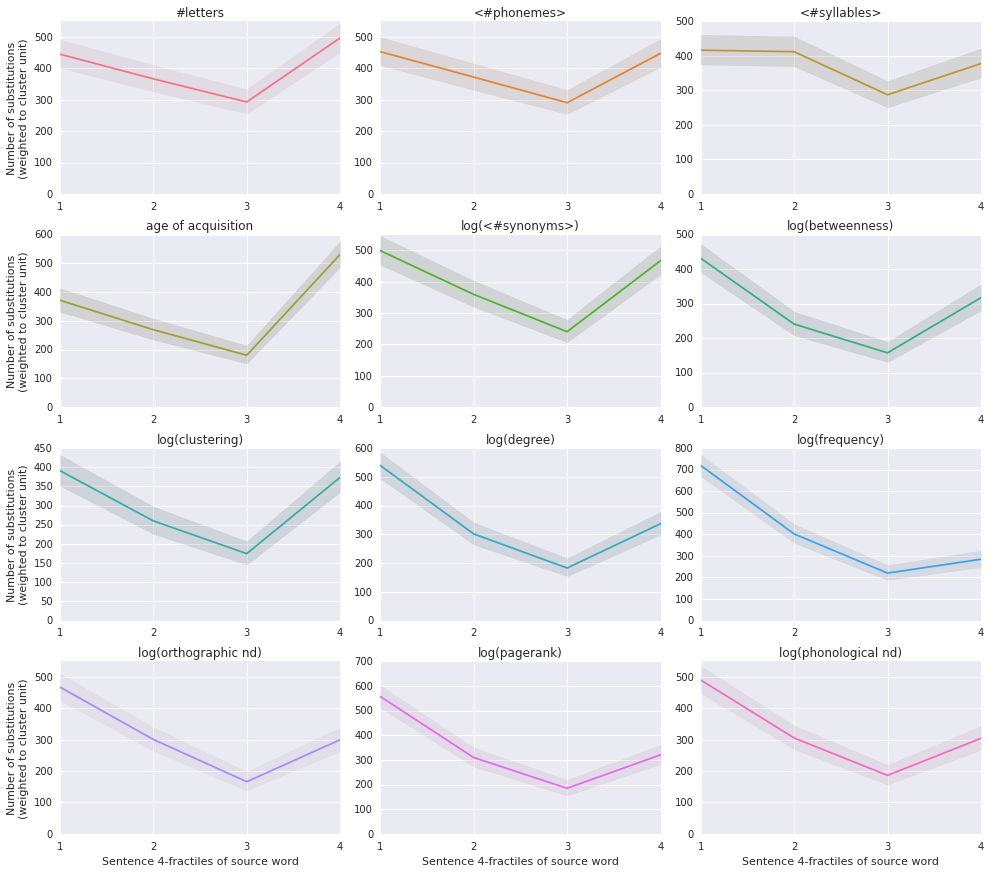

In [20]:
# Now plot.
g = sb.FacetGrid(data=fractiles, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're finally in a real multinomial sampling (and it's the only time). So we're going to use multinomial CIs.

### 5.2 Feature susceptibilities, reduced to features we expose in the paper

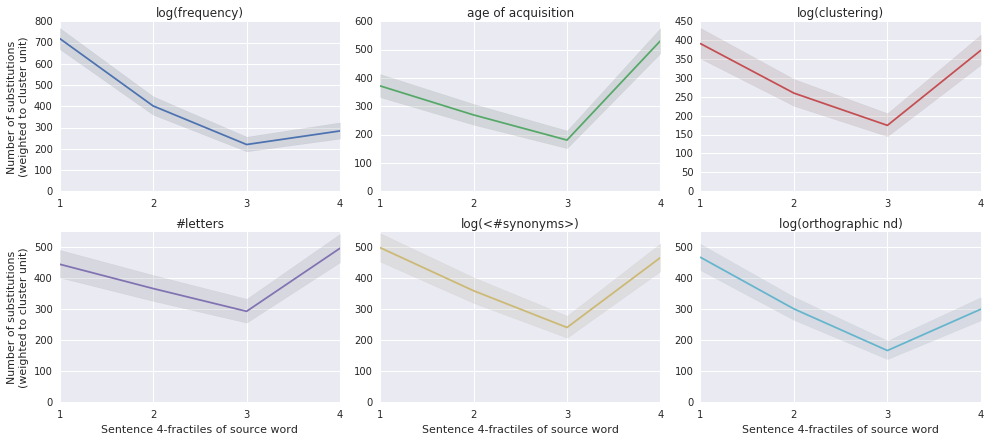

In [21]:
# Now plot.
g = sb.FacetGrid(data=fractiles[fractiles['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_fractile_distribution)
g.set_titles('{col_name}')
g.set_xlabels('Sentence {}-fractiles of source word'.format(BIN_COUNT))
g.set_ylabels('Number of substitutions\n(weighted to cluster unit)')
for ax in g.axes.ravel():
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-fractile_susceptibilities-relative'),
                  bbox_inches='tight', dpi=300)